# 0. Initialize

## 0.1. Import Libraries

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, glob
import gzip
import random
import tqdm
import json
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

from IPython import display
import matplotlib as mpl
from matplotlib import pyplot as plt

## 0.2. DEFINE VARIABLES 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [ ]:
DATA_PATH = '/content/drive/MyDrive/Datas/raw_data/' # '<insert-your-training-data-path-here>'

ROUND = 3 # This project will have 3 rounds of predictions: 1,2,3
STUDENT_ID = '28061'#'<insert-your-id-here>'
PROJECT_CODE = 'CS412e601e2294722'#'<insert-your-code-here>' # Same code for the annotation eg. CS412xxxxx

## 0.3. Read Training & Evaluation Data

### 0.3.1. Get the labels for tweets

In [ ]:
trainingTweetDf = pd.read_csv('{}training-tweet.csv'.format(DATA_PATH), dtype={'tweet_id': str, 'isPolitical': str})
trainingTweetDf

,tweet_id,isPolitical
0,1597170281545551872,Yes
1,1431700027471192069,No
2,1566035577090281472,Yes
3,1591538690869940225,Yes
4,1583898169238167554,Yes
...,...,...
2995,1593539327623151619,Yes
2996,1393886554062524418,No
2997,1597925615092764672,Yes
2998,1585291418616176640,Yes


In [ ]:
trainingTweetDf.isPolitical.value_counts()

Yes    2003
No      997
Name: isPolitical, dtype: int64

### 0.3.2. Get the labels for users

In [ ]:
trainingUserDf = pd.read_csv('{}training-user.csv'.format(DATA_PATH))
trainingUserDf

,screen_name,isBot
0,koftecancaddy,No
1,ahaber,No
2,selahat03949652,No
3,erdin06357062,No
4,bhct__necatii,No
...,...,...
2995,djblumenberg,No
2996,mel1sq,No
2997,eren_yz1,Yes
2998,ergnyildiz4,No


In [ ]:
trainingUserDf.isBot.value_counts()

No     2424
Yes     576
Name: isBot, dtype: int64

### 0.3.3. Expand your dataset with metadata and tweets

In [ ]:
# You can also expand training data by downloading your own labeled datasets following the link
# Download the documents under "Link to training data"

print('http://www.onurvarol.com/Annotation-CS412-202201/reports/report_{}.html'.format(PROJECT_CODE))

http://www.onurvarol.com/Annotation-CS412-202201/reports/report_CS412e601e2294722.html


# 1. EXTRACT FEATURES
Under *1.1. Political Tweet Detection* and *1.2. Bot Detection*, we firstly collect raw data for processing. We then combine some of them (total_interactions = num_favorites + num_retweets) or use them to extract features (whether the tweet has one of the political entities @meralaksener, @kilicdarogluk etc.).

We expect you to collect more raw data from **tweet_metadata**, **user_profiles** and **user_tweets** files by creating a function as shown in below examples such as *check_if_retweet()* and using it while iterating over data as shown under *Merge Collected Features*.

We also expect you to create new variables as much as you can from the data in order to make your predictions more accurate. For example, you may want to check:

- The tweet sources that a user frequently uses
- Whether the user is a verified account or not

...

to assess whether **a user is a bot or not** and whether **a tweet is political or not**.

In [ ]:
PATH_TO_DOWNLOADED = '/content/drive/MyDrive/Datas/raw_data/'

## 1.1. Political Tweet Detection
This part stands for the feature extraction of tweets. We start with collecting the raw data from *tweet_metadata*, then use some of them to extract features.

### 1.1.1. Get Raw Data

#### 1.1.1.1. Check if Retweet

In [ ]:
def check_if_retweet(tweet_metadata_line):
    is_retweet = 0
    retweeted_username = None

    try:
        tweet_metadata_line['retweeted_status']
        retweeted_username = tweet_metadata_line['retweeted_status']['user']['screen_name'].lower()
        is_retweet = 1

    except KeyError:
        pass

    return is_retweet, retweeted_username

#### 1.1.1.2. Get Tweet Text

In [ ]:
def get_tweet_text(tweet_metadata_line):
    text = tweet_metadata_line['text']
    
    return text

#### 1.1.1.3. Get Tweet ID

In [ ]:
def get_tweet_id(tweet_metadata_line):
    id_str = tweet_metadata_line['id_str']
    
    return id_str

#### 1.1.1.4. Get Number of Mentions and Hashtags

In [ ]:
def get_number_mentions_hashtags(tweet_metadata_line):
    num_mentions = len(tweet_metadata_line['entities']['user_mentions'])
    num_hashtags = len(tweet_metadata_line['entities']['hashtags'])
    #added round3
    has_url = len(tweet_metadata_line['entities']['urls'])

    return num_mentions, num_hashtags, has_url

#### 1.1.1.5. Get Number of Retweets and Favorites

In [ ]:
def get_number_retweets_favorites(tweet_metadata_line):
    retweet_count = tweet_metadata_line['retweet_count']
    favorite_count = tweet_metadata_line['favorite_count']
    
    return retweet_count, favorite_count

#### 1.1.1.6. Get User Info

In [ ]:
def get_user_info(tweet_metadata_line):
    id = tweet_metadata_line['user']['id_str']
    screen_name = tweet_metadata_line['user']['screen_name'].lower()
    description = tweet_metadata_line['user']['description']
    #added round3
    location = tweet_metadata_line['user']['location']
    followers_count = tweet_metadata_line['user']['followers_count']
    friends_count = tweet_metadata_line['user']['friends_count']
    favourites_count = tweet_metadata_line['user']['favourites_count']
    verified = tweet_metadata_line['user']['verified']
    statuses_count = tweet_metadata_line['user']['statuses_count']
    default_profile = tweet_metadata_line['user']['default_profile']
    default_profile_image = tweet_metadata_line['user']['default_profile_image']
    has_extended_profile = tweet_metadata_line['user']['has_extended_profile']

    return id, screen_name, description,location,followers_count,friends_count,favourites_count,verified,statuses_count,default_profile,default_profile_image,has_extended_profile

    return id, screen_name, description

1.1.1.7 check If media (video or picture)

In [ ]:
def check_if_media(tweet_metadata_line):
  is_video = 0
  is_photo = 0
  try:
    if(tweet_metadata_line['extended_entities']['media'][0]['type'] == 'video'):
      is_video = 1
    if(tweet_metadata_line['extended_entities']['media'][0]['type'] == 'photo'):
      is_photo = 1
  except KeyError:
    pass
  return is_video or is_photo

1.1.1.8 other features round3

In [ ]:
def created_at(tweet_metadata_line):
    date = tweet_metadata_line["created_at"]

    return date


def get_place(tweet_metadata_line):
    place = None

    try:
        tweet_metadata_line['place']['name']
        place = tweet_metadata_line['place']['name']

    except TypeError:
        pass

    return place


def is_sensitive(tweet_metadata_line):
    sensitive = None

    try:
        tweet_metadata_line['possibly_sensitive']
        sensitive = tweet_metadata_line['possibly_sensitive']


    except KeyError:
        pass

    return sensitive

def get_engagement_rate(retweet_count, favorite_count,followers_count):
    if followers_count ==0:
        return 0
    eng_rate = (retweet_count + favorite_count)/followers_count
    
    return eng_rate

def get_tweet_length(text):
    
    return len(text)

def get_how_influential(followers_count,friends_count):
    if friends_count ==0: return 0
    
    return followers_count/friends_count

### 1.1.2. Derive Manually Crafted Features

#### 1.1.2.1. Check for political entity in text

In [ ]:
def check_political_ent(text):
    
    # the list below can be modified and some new names may be added (or removed)
    list_of_entities = ['meral_aksener', 'kilicdarogluk', 'vekilince', 'RTErdogan', 'MevlutCavusoglu', 'umitozdag','kyk','atama','akp','chp','mhp','iyi parti','erdoğan', 'akşener' ,'kılıçdaroğlu'
    ,'@RTErdogan','RT','Sayın','suleymansoylu','vedatbilgn','umitozdag','dbdevletbahceli','kadro','atama','tcmeb','istiyoruz','Akparti','ekrem_imamoglu','Cumhurbaşkanımız','tcbestepe','tc'
    ,'Türkiye','Ziraat','Tayyip','Genel','Devlet','TCAytunCiray','06melihgokcek','kemal','Recep','vekilim','Mustafa_Destici','akaraismailoglu','fuatokay','bybekirbozdag','hdp','kyk']

    entities_in_text = [ent for ent in list_of_entities if ent.lower() in text.lower()]
    number_entities = len(entities_in_text)

    return number_entities

#### 1.1.2.2. Number of total interactions

In [ ]:
def total_interactions(retweet_count, favorite_count):
    total_num_interactions = retweet_count + favorite_count
    
    return total_num_interactions

1.1.2.3. Check for political entity in users description

In [ ]:
def check_political_description(text):
    
    # the list below can be modified and some new names may be added (or removed)
    list_of_entities = ['🇹🇷','Parti','Ziraat','Ak','Türk','Başkanı','Milletvekili','Üyesi','Türkiye','Başkan','Atatürk','Ak','Genel',
                        'Vatan','Kemal','CHP','Partisi','Komisyonu','Gençlik','Kolları','İyi','Yardımcısı']

    entities_in_text = [ent for ent in list_of_entities if ent.lower() in text.lower()]
    number_entities = len(entities_in_text)

    return number_entities

### 1.1.2. Collect data using the functions above and transform into a Pandas DataFrame

In [ ]:
dfPolitical = {'tweet_id':[],
              'is_retweet':[],
              'retweeted_username':[],
              'text':[],
              'num_mentions':[],
              'num_hashtags':[],
              'num_retweets':[],
              'num_favorites':[],
              #'place_name':[],
              'is_sensitive':[],
              'date':[],
              'lang':[],
              'truncated':[],
              'user_id':[],
              'user_screen_name':[],
              'user_description':[],
              'user_location':[],
              'followers_count':[],
              'friends_count':[],
              'favourites_count':[],
              'verified':[],
              'statuses_count':[],
              'default_profile':[],
              'default_profile_image':[],
              'has_extended_profile':[],
              'has_url':[],
              'num_political_entities':[],
              'total_interactions':[],
              'engagement_rate':[],
              'tweet_length':[],
              'how_influential':[],
              'is_media':[],
              'num_political_desc':[]
              }


with gzip.open(f"{PATH_TO_DOWNLOADED}tweet_metadata.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)
        
        # raw data:
        truncated = line["truncated"]
        lang = line["lang"]
        date = created_at(line)
        sensitive = is_sensitive(line)
        id_str = get_tweet_id(line) 
        is_retweet, retweeted_username = check_if_retweet(line) 
        text = get_tweet_text(line)
        num_mentions, num_hashtags, has_url = get_number_mentions_hashtags(line)
        retweet_count, favorite_count = get_number_retweets_favorites(line)
        place = get_place(line)
        user_id, screen_name, description,location,followers_count,friends_count,favourites_count,verified,statuses_count,default_profile,default_profile_image,has_extended_profile= get_user_info(line)
        
        # manually crafted data:
        num_political_entities = check_political_ent(text)
        total_num_interactions = total_interactions(retweet_count, favorite_count)
        engagement_rate = get_engagement_rate(retweet_count,favorite_count, followers_count)
        tweet_length = get_tweet_length(text)
        how_influential = get_how_influential(followers_count,friends_count)
        is_media = check_if_media(line)
        num_political_desc = check_political_description(description)
        
        
        
        dfPolitical['truncated'].append(truncated)
        dfPolitical['lang'].append(lang)
        dfPolitical['date'].append(date)
        dfPolitical['is_sensitive'].append(sensitive)
        #dfPolitical['place_name'].append(place)
        dfPolitical['tweet_id'].append(id_str)
        dfPolitical['is_retweet'].append(is_retweet)
        dfPolitical['retweeted_username'].append(retweeted_username)
        dfPolitical['text'].append(text)
        dfPolitical['num_mentions'].append(num_mentions)
        dfPolitical['num_hashtags'].append(num_hashtags)
        dfPolitical['num_retweets'].append(retweet_count)
        dfPolitical['num_favorites'].append(favorite_count)
        dfPolitical['user_id'].append(user_id)
        dfPolitical['user_screen_name'].append(screen_name)
        dfPolitical['user_description'].append(description)
        dfPolitical['user_location'].append(location)
        dfPolitical['followers_count'].append(followers_count)
        dfPolitical['friends_count'].append(friends_count)
        dfPolitical['favourites_count'].append(favourites_count)
        dfPolitical['verified'].append(verified)
        dfPolitical['statuses_count'].append(statuses_count)
        dfPolitical['default_profile'].append(default_profile)
        dfPolitical['default_profile_image'].append(default_profile_image)
        dfPolitical['has_extended_profile'].append(has_extended_profile)
        dfPolitical['has_url'].append(has_url)
        dfPolitical['num_political_entities'].append(num_political_entities)
        dfPolitical['total_interactions'].append(total_num_interactions)
        dfPolitical['engagement_rate'].append(engagement_rate)
        dfPolitical['tweet_length'].append(tweet_length)
        dfPolitical['how_influential'].append(how_influential)
        dfPolitical['is_media'].append(is_media)
        dfPolitical['num_political_desc'].append(num_political_desc)

In [ ]:
dfPolitical = pd.DataFrame(dfPolitical)
dfPolitical

,tweet_id,is_retweet,retweeted_username,text,num_mentions,num_hashtags,num_retweets,num_favorites,is_sensitive,date,lang,truncated,user_id,user_screen_name,user_description,user_location,followers_count,friends_count,favourites_count,verified,statuses_count,default_profile,default_profile_image,has_extended_profile,has_url,num_political_entities,total_interactions,engagement_rate,tweet_length,how_influential,is_media,num_political_desc
0,1588568792984346624,0,None,"Sosyal Hizmetin temelini çocuk oluşturur,çocuğ...",0,0,49,98,False,Fri Nov 04 16:28:09 +0000 2022,tr,True,920963718103650304,maviruh_,shu/\nburaya afilli bir söz yazdığımı varsayın,Ankara,284,539,35673,False,2638,True,False,False,1,0,147,0.517606,140,0.526902,0,0
1,1588452263047069697,0,None,"@mahirunal Gavur İzmir ya onlar, hani Cumhuriy...",1,0,0,0,None,Fri Nov 04 08:45:06 +0000 2022,tr,False,595514060,mtfdan,,,131,589,601,False,6647,True,False,False,0,0,0,0.000000,97,0.222411,0,0
2,1569589330544398336,0,None,#ŞehitAdayıUzmÇvşaKadro\nSiz İstesenizde Istem...,0,1,0,0,None,Tue Sep 13 07:30:32 +0000 2022,tr,True,1356375754561490947,ahsucilginuzman,Vatan Sevdalisi,,60,118,1230,False,2924,True,False,True,1,1,0,0.000000,140,0.508475,0,1
3,1570428119609139201,0,None,@ajans_muhbir Siz kaypak olmayıp onay vermesey...,1,0,0,0,None,Thu Sep 15 15:03:35 +0000 2022,tr,True,1478775431008595968,hamitelkelle,HighOne,,2,69,608,False,1783,True,False,False,1,0,0,0.000000,140,0.028986,0,0
4,1551163840368414722,0,None,Engelli öğretmenler olarak önümüzdeki engeller...,0,0,0,0,None,Sun Jul 24 11:14:13 +0000 2022,tr,True,1511976696337113088,sed58417690,,,119,166,2427,False,7559,True,False,True,1,0,0,0.000000,140,0.716867,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33528,1568595408233832448,0,None,Gerçek kimlik taşımayan hesaplara cevap vermem...,0,0,9,81,False,Sat Sep 10 13:41:03 +0000 2022,tr,True,576247173,ardanzenturk,RT ONAYLADIĞIM ANLAMINA GELMEZ\nArtık fikirler...,,171399,4147,4990,False,41342,True,False,True,1,0,90,0.000525,140,41.330842,0,0
33529,1584027427696959488,0,None,@umitozdag Neden Suriyelilerle ilgili bu kadar...,1,0,1,8,None,Sun Oct 23 03:42:23 +0000 2022,tr,True,162308585,ozgul_61,Bridge design engineer Yaay hesabı : dilfiruz,PAYİTAHT 🇹🇷,3936,3227,193138,False,52340,False,False,False,1,2,9,0.002287,140,1.219709,0,0
33530,1585945783307730945,0,None,@celebimehmeta Niye Türkiye yüzyılıda.Türkiye ...,1,0,0,1,None,Fri Oct 28 10:45:14 +0000 2022,tr,False,415025519,ladrekova,,,121,412,1418,False,1225,False,False,True,0,1,1,0.008264,76,0.293689,0,0
33531,1569748909521801221,1,muazzezeralp,RT @muazzezeralp: @Doan58213655 @denizkonur @N...,7,1,6,0,None,Tue Sep 13 18:04:39 +0000 2022,tr,False,1442125177727307781,yapikytgrivrlsn,,,591,1003,43990,False,153819,True,False,True,0,5,6,0.010152,140,0.589232,0,0


In [ ]:
#Most occured strings
from collections import Counter

Counter(" ".join(dfPolitical["text"]).split()).most_common(100)

[('@RTErdogan', 4701),
 ('RT', 4619),
 ('ve', 3663),
 ('bir', 2938),
 ('bu', 1991),
 ('için', 1711),
 ('Sayın', 1627),
 ('@kilicdarogluk', 1563),
 ('de', 1303),
 ('@drfahrettinkoca', 1293),
 ('ne', 1205),
 ('@meral_aksener', 1185),
 ('ile', 1084),
 ('da', 1056),
 ('olarak', 1000),
 ('çok', 982),
 ('Bu', 958),
 ('@suleymansoylu', 911),
 ('@vedatbilgn', 887),
 ('kadar', 802),
 ('@umitozdag', 744),
 ('atama', 735),
 ('gibi', 707),
 ('bin', 695),
 ('en', 680),
 ('@RTErdogan:', 674),
 ('olsun', 652),
 ('olan', 650),
 ('daha', 622),
 ('her', 605),
 ('var', 600),
 ('o', 567),
 ('ama', 567),
 ('@dbdevletbahceli', 555),
 ('@Akparti', 520),
 ('değil', 507),
 ('yok', 474),
 ('kadro', 469),
 ('Allah', 466),
 ('@ekrem_imamoglu', 463),
 ('biz', 463),
 ('mi', 437),
 ('ya', 429),
 ('ki', 415),
 ('artık', 415),
 ('sayın', 413),
 ('Cumhurbaşkanımız', 412),
 ('sen', 393),
 ('iyi', 390),
 ('@tcmeb', 390),
 ('diye', 389),
 ('istiyoruz', 387),
 ('@tcbestepe', 379),
 ('Bir', 373),
 ('15', 370),
 ('Biz', 369)

In [ ]:
#Most occured strings in user's descriptions
Counter(" ".join(dfPolitical["user_description"]).split()).most_common(100)

[('ve', 2441),
 ('bir', 1297),
 ('|', 935),
 ('-', 796),
 ('🇹🇷', 779),
 ('/', 597),
 ('Parti', 542),
 ('için', 488),
 ('Ziraat', 414),
 ('AK', 404),
 ('Mühendisi', 376),
 ('Türk', 324),
 ('Başkanı', 323),
 ('da', 319),
 ('•', 300),
 ('Üyesi', 293),
 ('bu', 286),
 ('de', 277),
 ('the', 276),
 ('Bir', 268),
 ('Twitter', 267),
 ('her', 264),
 ('Üniversitesi', 263),
 ('Öğretmeni', 262),
 ('and', 253),
 ('Türkiye', 247),
 ('ile', 247),
 ('kadar', 241),
 ('İlçe', 237),
 ('ne', 235),
 ('of', 234),
 ('İl', 231),
 ('mühendisi', 227),
 ('Milletvekili', 226),
 ('a', 224),
 ('.', 223),
 (',', 222),
 ('&', 220),
 ('Başkan', 218),
 ('en', 217),
 ('İstanbul', 208),
 ('Ak', 208),
 ('Ne', 207),
 ('is', 197),
 ('çok', 193),
 ('Genel', 192),
 ('Atatürk', 191),
 ('ATATÜRK', 189),
 ('takip', 184),
 ('Vatan', 182),
 ('I', 181),
 ('gibi', 181),
 ('in', 178),
 ('Her', 178),
 ('Yönetim', 175),
 ('Kemal', 175),
 ('CHP', 172),
 ('Partisi', 169),
 ('yok', 168),
 ('to', 167),
 ('PARTİ', 164),
 ('Bu', 163),
 ('Must

## 1.2. From Users

### 1.2.1. Get user metadata from user_profiles.jsons.gz

#### 1.2.1.1. Get user info metadata

In [ ]:
def get_user_info_metadata(user_metadata_line):
    
    user_id = user_metadata_line['id_str']
    user_name = user_metadata_line['name']
    user_screen_name = user_metadata_line['screen_name'].lower()
    user_location = user_metadata_line['location']
    user_description = user_metadata_line['description']
    user_followers_count = user_metadata_line['followers_count']
    user_friends_count = user_metadata_line['friends_count']
    #
    verified = user_metadata_line['verified']
    geo_enabled= user_metadata_line['geo_enabled']
    favourites_count = user_metadata_line['favourites_count']
    created_at = user_metadata_line['created_at']

    dictionary = {'user_id':user_id, 'user_name': user_name, 'user_screen_name':user_screen_name, 'user_location':user_location,
     'user_description':user_description, 'user_followers_count':user_followers_count, 'user_friends_count':user_friends_count, 
     'verified':verified, 'geo_enabled':geo_enabled, 'favourites_count': favourites_count,
     'created_at': created_at}

    return dictionary

#### 1.2.1.2. Get followers/(followers+friends) ratio

In [ ]:
def get_followers_all_ratio(user_followers_count, user_friends_count):
    
    if user_friends_count + user_followers_count == 0:
        followers_all_ratio = 0

    else:
        followers_all_ratio =  user_followers_count / (user_friends_count + user_followers_count)

    return followers_all_ratio

#### 1.2.1.3. Get description length

In [ ]:
def get_desc_len(user_description):
    
    description_len = len(user_description)

    return description_len

1.2.1.4 Get average daily favorites

In [ ]:
def get_daily_favorites(favourites_count, account_age_days):
    
    return(np.round(favorite_count / account_age_days), 3)

1.2.1.5 Get network

1.2.1.6 Get account age

In [ ]:
from time import strptime
from datetime import date

def get_account_age(created_at):
    lst=(created_at.split(' '))
    year = lst[5]
    month= lst[1]
    month= strptime(month,'%b').tm_mon
    day= lst[2]

    given = date(int(year), int(month), int(day))
    now = date(2023, 1, 24)
    delta = now- given
    return delta
  


In [ ]:
def get_network(user_friends_count, user_followers_count):
    
    return (user_friends_count + user_followers_count)

In [ ]:
dfBot = {'user_id':[],
         'user_name':[],
         'user_screen_name':[],
         'user_location':[],
         'user_description':[],
         'user_followers_count':[],
         'user_friends_count':[],
         'description_len':[],
         'followers_to_all_ratio':[],
         'verified':[], #added
         'geo_enabled':[],
         'favourites_count':[],
         'created_at': [],
         'account_age_days':[],
         #'avg_daily_favorites':[],
         'network':[],
         } 
         

with gzip.open(f"{PATH_TO_DOWNLOADED}user_profiles.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)

        dictionary = get_user_info_metadata(line)
        for k,v in dictionary.items():
            dfBot[k].append(v)

        
        # manually crafted data:
        description_len = get_desc_len(dictionary['user_description'])
        dfBot['description_len'].append(description_len)
        
        followers_all_ratio = get_followers_all_ratio(dictionary['user_followers_count'], 
                                                      dictionary['user_friends_count'])
        dfBot['followers_to_all_ratio'].append(followers_all_ratio)

        account_age_days= get_account_age(dictionary['created_at'])
        dfBot['account_age_days'].append(account_age_days)

        #avg_daily_favorites= get_daily_favorites(dictionary['favourites_count'], dictionary['account_age_days'])     
        #dfBot['avg_daily_favorites'].append(avg_daily_favorites)

        network= get_network(dictionary['user_friends_count'], 
                                                      dictionary['user_followers_count'])        
        dfBot['network'].append(network)

In [ ]:
dfBot = pd.DataFrame(dfBot)
dfBot

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,verified,geo_enabled,favourites_count,created_at,account_age_days,network
0,1431241870848450577,Nasreena Khan Wazir,nasreenakhan006,"Islamabad, Pakistan",Student,65,185,7,0.260000,False,True,17676,Fri Aug 27 13:07:30 +0000 2021,515 days,250
1,1304340303080386560,fania :((((,scorpiehoez,bogor,have a holly jolly🎄,8235,3011,19,0.732260,False,True,15474,Fri Sep 11 08:45:44 +0000 2020,865 days,11246
2,1116042038577958914,Yusuf Aksoy,yusufak63712920,,"Bir şeyden pişmanlık duymak istemiyorsan,her ş...",95,399,64,0.192308,False,False,18220,Wed Apr 10 18:15:31 +0000 2019,1385 days,494
3,4859899931,Be (VIXX6) ama oppalarının düğününe gidemiyor,nedenburdaysam,Hufflepuff ortak salon,"SMStan\n/St☆rlight ///come on girls,this is ou...",40,83,65,0.325203,False,False,26999,Fri Jan 29 11:01:25 +0000 2016,2552 days,123
4,2225373636,SLMDMR,biologselim,,BİYOLOG🔬🦠\nNanoteknoloji,100,98,23,0.505051,False,False,2179,Sun Dec 01 18:16:41 +0000 2013,3341 days,198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29665,1320834618220781569,islammm,islam_mrsj,,,229,217,0,0.513453,False,False,10820,Mon Oct 26 21:08:22 +0000 2020,820 days,446
29666,111074128,Melda Onur,meldaonur,,"Şekersiz çay, etsiz sofra, SAVAŞSIZ dünya... 🐌...",212457,5428,100,0.975088,False,True,36671,Wed Feb 03 18:39:01 +0000 2010,4738 days,217885
29667,36946875,ali ydm,ali_ydm,"İstanbul, Türkiye",hayat oyunsa bende jeton çok,116,141,28,0.451362,False,False,7389,Fri May 01 13:56:23 +0000 2009,5016 days,257
29668,2389587396,Türkan Usta,turkanusta,"Ankara, Türkiye",Ustaya sormuşlar; hayatta yaptığın en büyük is...,1669,3639,116,0.314431,False,True,140095,Fri Mar 14 18:05:09 +0000 2014,3238 days,5308


### 1.2.2. Get Tweet Info of Users in user_profiles.jsons.gz

#### 1.2.2.1. Check ratio of retweets to all tweets

In [ ]:
def get_retweet_tweet_ratio(line):
    number_retweets = 0
    number_original_tweets = 0

    for tweet in line['tweets']:
        try:
            tweet['retweeted_status']
            number_retweets += 1
                
        except:
            number_original_tweets += 1
            
    total_tweets = number_retweets + number_original_tweets
    
    if total_tweets == 0:
        retweet_total_ratio = None
    else:
        retweet_total_ratio = number_retweets/(total_tweets)
    
    return retweet_total_ratio

#### 1.2.2.2. Check median number of favorites

In [ ]:
def get_median_number_favorites(line):
    num_median_favorites = np.median([tweet['favorite_count'] for tweet in line['tweets']])

    return num_median_favorites

### 1.2.3. Collect data using the functions above and transform into a Pandas DataFrame

In [ ]:
dfBotTweets = {'user_id':[],
               'retweet_total_ratio':[],
               'num_median_favorites':[],
               'num_of_tweets':[],
              }

i = 0

with gzip.open(f"{PATH_TO_DOWNLOADED}user_tweets.jsons.gz", "rb") as f:
    for line in f:

        line = json.loads(line)

        user_id = line['user_id']
        dfBotTweets['user_id'].append(user_id)
        
        retweet_total_ratio = get_retweet_tweet_ratio(line)
        dfBotTweets['retweet_total_ratio'].append(retweet_total_ratio)
        
        num_median_favorites = get_median_number_favorites(line)
        dfBotTweets['num_median_favorites'].append(num_median_favorites)
        
        dfBotTweets['num_of_tweets'].append(len(line['tweets']))

        i += 1
        if i % 1000 == 0:
            print(i)

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000


In [ ]:
dfBotTweets = pd.DataFrame(dfBotTweets)
dfBotTweets

,user_id,retweet_total_ratio,num_median_favorites,num_of_tweets
0,594642154,0.115000,2.0,200
1,525600289,0.005025,1.0,199
2,931895965501534209,0.900000,0.0,200
3,1591543462746329088,0.185000,0.0,200
4,734801354749796352,1.000000,0.0,200
...,...,...,...,...
28310,1591370361488252928,0.800000,0.0,200
28311,1475272459616235525,0.825000,0.0,200
28312,1096753792731750401,0.051020,1.0,196
28313,1269527617687953409,0.095000,2.0,200


### 1.2.3. Merge dfBot and dfBotTweets

In [ ]:
dfBotAll = dfBot.merge(dfBotTweets,
                       how='left')

dfBotAll[['retweet_total_ratio', 'num_median_favorites']] = dfBotAll[['retweet_total_ratio', 'num_median_favorites']].fillna(0)

dfBotAll

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,verified,geo_enabled,favourites_count,created_at,account_age_days,network,retweet_total_ratio,num_median_favorites,num_of_tweets
0,1431241870848450577,Nasreena Khan Wazir,nasreenakhan006,"Islamabad, Pakistan",Student,65,185,7,0.260000,False,True,17676,Fri Aug 27 13:07:30 +0000 2021,515 days,250,0.395939,0.0,197.0
1,1304340303080386560,fania :((((,scorpiehoez,bogor,have a holly jolly🎄,8235,3011,19,0.732260,False,True,15474,Fri Sep 11 08:45:44 +0000 2020,865 days,11246,0.125000,0.0,200.0
2,1116042038577958914,Yusuf Aksoy,yusufak63712920,,"Bir şeyden pişmanlık duymak istemiyorsan,her ş...",95,399,64,0.192308,False,False,18220,Wed Apr 10 18:15:31 +0000 2019,1385 days,494,0.910000,0.0,200.0
3,4859899931,Be (VIXX6) ama oppalarının düğününe gidemiyor,nedenburdaysam,Hufflepuff ortak salon,"SMStan\n/St☆rlight ///come on girls,this is ou...",40,83,65,0.325203,False,False,26999,Fri Jan 29 11:01:25 +0000 2016,2552 days,123,0.015306,1.0,196.0
4,2225373636,SLMDMR,biologselim,,BİYOLOG🔬🦠\nNanoteknoloji,100,98,23,0.505051,False,False,2179,Sun Dec 01 18:16:41 +0000 2013,3341 days,198,0.659898,0.0,197.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29665,1320834618220781569,islammm,islam_mrsj,,,229,217,0,0.513453,False,False,10820,Mon Oct 26 21:08:22 +0000 2020,820 days,446,0.015000,1.0,200.0
29666,111074128,Melda Onur,meldaonur,,"Şekersiz çay, etsiz sofra, SAVAŞSIZ dünya... 🐌...",212457,5428,100,0.975088,False,True,36671,Wed Feb 03 18:39:01 +0000 2010,4738 days,217885,0.291457,2.0,199.0
29667,36946875,ali ydm,ali_ydm,"İstanbul, Türkiye",hayat oyunsa bende jeton çok,116,141,28,0.451362,False,False,7389,Fri May 01 13:56:23 +0000 2009,5016 days,257,0.061538,0.0,195.0
29668,2389587396,Türkan Usta,turkanusta,"Ankara, Türkiye",Ustaya sormuşlar; hayatta yaptığın en büyük is...,1669,3639,116,0.314431,False,True,140095,Fri Mar 14 18:05:09 +0000 2014,3238 days,5308,0.995000,0.0,200.0


# 2. TRAIN MODEL

## 2.1. Political Tweet Prediction

In [ ]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.compose import ColumnTransformer

### 2.1.1. Merge dfPolitical data with labels

In [ ]:
dfPoliticalAll_train = dfPolitical.merge(trainingTweetDf,
                                         on='tweet_id')

dfPoliticalAll_train.head()

,tweet_id,is_retweet,retweeted_username,text,num_mentions,num_hashtags,num_retweets,num_favorites,is_sensitive,date,lang,truncated,user_id,user_screen_name,user_description,user_location,followers_count,friends_count,favourites_count,verified,statuses_count,default_profile,default_profile_image,has_extended_profile,has_url,num_political_entities,total_interactions,engagement_rate,tweet_length,how_influential,is_media,num_political_desc,isPolitical
0,1585955683513798656,0,None,@AvOzlemZengin YüzüncüYıla YakışanGenelAf adli...,1,0,3,2,True,Fri Oct 28 11:24:35 +0000 2022,tr,False,1564992353168941058,zehra78231638,,,221,113,21242,False,25730,True,False,True,0,1,5,0.022624,126,1.955752,1,0,Yes
1,1597631718479261696,0,None,#TCYüzyılıÜcretliÖgrtKadro\n#TCYüzyılıÜcretliÖ...,0,2,30,28,None,Tue Nov 29 16:40:58 +0000 2022,tr,True,1324630334416297985,nurozguler,,"İzmir, Türkiye",455,420,11596,False,12427,True,False,True,1,3,58,0.127473,140,1.083333,0,0,Yes
2,1572522789948751874,0,None,Ekrem İmamoğlu davayı değerlendirdi. 'Boş işle...,0,0,5,66,False,Wed Sep 21 09:47:03 +0000 2022,tr,False,407597071,onediocom,Türkiye'nin ilk ve tek sosyal içerik sitesi ht...,Türkiye,735643,12,627,True,161123,False,False,False,1,0,71,0.000097,131,61303.583333,1,2,Yes
3,1591412481561624577,0,None,Sayın Bakanım @suleymansoylu POMEM önlisans er...,1,0,0,0,None,Sat Nov 12 12:47:57 +0000 2022,tr,True,1394789887073738753,buckybarnestr,...,,10,45,94,False,1595,True,False,True,1,2,0,0.000000,140,0.222222,0,0,Yes
4,1596914274907348992,0,None,"@varank Sayın bakanım, Bodrumdaki bu araziyi ...",1,0,0,0,False,Sun Nov 27 17:10:07 +0000 2022,tr,False,1586083256088371201,sayariahmet,,,6,6,2526,False,1251,True,False,True,0,1,0,0.000000,87,1.000000,1,0,Yes


### 2.1.2. Separate X and y values
We only use 3 features here to create a baseline model. However, it is not enough to get good results.

In [ ]:
dfPoliticalAll_train["user_location"]=dfPoliticalAll_train.user_location.apply(lambda x : 1 if x!= None else 0)
dfPoliticalAll_train.is_sensitive.fillna(dfPoliticalAll_train.is_sensitive.mode()[0],inplace=True)
dfPoliticalAll_train["month"]=pd.to_datetime(dfPoliticalAll_train.date).dt.month
dfPoliticalAll_train.user_screen_name = dfPoliticalAll_train.user_screen_name.apply(lambda x : len(x))
dfPoliticalAll_train.user_id = dfPoliticalAll_train.user_id.apply(lambda x : dfPoliticalAll_train.user_id.value_counts()[x])
dfPoliticalAll_train.user_description = dfPoliticalAll_train.user_description.apply(lambda x : len(x))
dfPoliticalAll_train.drop(["tweet_id","is_retweet","retweeted_username","text","date"],axis=1,inplace=True)


In [ ]:
dfPoliticalAll_train['isPolitical'] = dfPoliticalAll_train['isPolitical'].apply(lambda x: 1 if x=='Yes' else 0)
dfPoliticalAll_train['has_extended_profile'] = dfPoliticalAll_train['has_extended_profile'].apply(lambda x: 1 if x==True else 0)
dfPoliticalAll_train['default_profile_image'] = dfPoliticalAll_train['default_profile_image'].apply(lambda x: 1 if x==True else 0)
dfPoliticalAll_train['default_profile']= dfPoliticalAll_train['default_profile'].apply(lambda x: 1 if x==True else 0)
dfPoliticalAll_train['verified'] = dfPoliticalAll_train['verified'].apply(lambda x: 1 if x==True else 0)
dfPoliticalAll_train['truncated'] = dfPoliticalAll_train['truncated'].apply(lambda x: 1 if x==True else 0)
dfPoliticalAll_train['is_sensitive'] = dfPoliticalAll_train['is_sensitive'].apply(lambda x: 1 if x==True else 0)

dfPoliticalAll_train.head(10)

,num_mentions,num_hashtags,num_retweets,num_favorites,is_sensitive,lang,truncated,user_id,user_screen_name,user_description,user_location,followers_count,friends_count,favourites_count,verified,statuses_count,default_profile,default_profile_image,has_extended_profile,has_url,num_political_entities,total_interactions,engagement_rate,tweet_length,how_influential,is_media,num_political_desc,isPolitical,month
0,1,0,3,2,1,tr,0,1,13,0,1,221,113,21242,0,25730,1,0,1,0,1,5,0.022624,126,1.955752,1,0,1,10
1,0,2,30,28,0,tr,1,1,10,0,1,455,420,11596,0,12427,1,0,1,1,3,58,0.127473,140,1.083333,0,0,1,11
2,0,0,5,66,0,tr,0,1,9,120,1,735643,12,627,1,161123,0,0,0,1,0,71,0.000097,131,61303.583333,1,2,1,9
3,1,0,0,0,0,tr,1,1,13,3,1,10,45,94,0,1595,1,0,1,1,2,0,0.000000,140,0.222222,0,0,1,11
4,1,0,0,0,0,tr,0,1,11,0,1,6,6,2526,0,1251,1,0,1,0,1,0,0.000000,87,1.000000,1,0,1,11
5,1,0,1,3,0,tr,1,1,7,26,1,174,217,6693,0,5391,1,0,1,1,0,4,0.022989,140,0.801843,0,0,1,11
6,3,0,0,2,0,tr,1,1,9,62,1,110,527,1361,0,3296,1,0,0,1,1,2,0.018182,140,0.208729,0,2,1,11
7,0,0,0,0,0,tr,0,1,6,36,1,48,272,2514,0,5763,1,0,1,0,0,0,0.000000,50,0.176471,1,2,0,6
8,1,0,0,1,0,tr,0,1,11,0,1,83,290,1224,0,2123,1,0,1,0,0,1,0.012048,40,0.286207,0,0,1,11
9,1,0,0,0,0,tr,0,1,9,105,1,163,401,7896,0,10133,0,0,0,0,0,0,0.000000,60,0.406484,0,0,0,11


[]

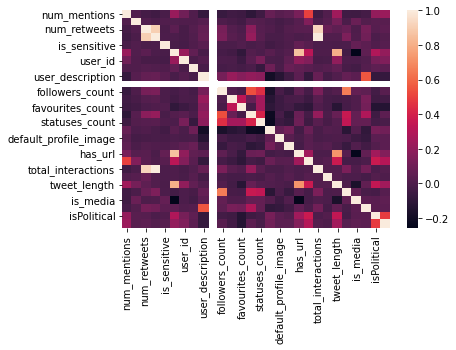

In [ ]:
sns.heatmap(pd.DataFrame(dfPoliticalAll_train).corr())
plt.plot()

In [ ]:
dfPoliticalAll_train.corr().isPolitical.sort_values(ascending=False)

isPolitical               1.000000
month                     0.487620
num_political_entities    0.371658
tweet_length              0.342970
truncated                 0.290642
has_url                   0.247528
num_mentions              0.207223
default_profile           0.127050
user_id                   0.122977
user_screen_name          0.050307
default_profile_image     0.042966
is_media                  0.038275
num_political_desc        0.034950
num_hashtags              0.029166
num_retweets              0.025894
has_extended_profile      0.015593
engagement_rate           0.014656
is_sensitive              0.005222
total_interactions       -0.000865
num_favorites            -0.004138
how_influential          -0.023892
statuses_count           -0.024928
followers_count          -0.032101
friends_count            -0.044635
verified                 -0.046945
user_description         -0.080709
favourites_count         -0.128922
user_location                  NaN
Name: isPolitical, d

In [ ]:
dfPoliticalAll_train

,num_mentions,num_hashtags,num_retweets,num_favorites,is_sensitive,lang,truncated,user_id,user_screen_name,user_description,user_location,followers_count,friends_count,favourites_count,verified,statuses_count,default_profile,default_profile_image,has_extended_profile,has_url,num_political_entities,total_interactions,engagement_rate,tweet_length,how_influential,is_media,num_political_desc,isPolitical,month
0,1,0,3,2,1,tr,0,1,13,0,1,221,113,21242,0,25730,1,0,1,0,1,5,0.022624,126,1.955752,1,0,1,10
1,0,2,30,28,0,tr,1,1,10,0,1,455,420,11596,0,12427,1,0,1,1,3,58,0.127473,140,1.083333,0,0,1,11
2,0,0,5,66,0,tr,0,1,9,120,1,735643,12,627,1,161123,0,0,0,1,0,71,0.000097,131,61303.583333,1,2,1,9
3,1,0,0,0,0,tr,1,1,13,3,1,10,45,94,0,1595,1,0,1,1,2,0,0.000000,140,0.222222,0,0,1,11
4,1,0,0,0,0,tr,0,1,11,0,1,6,6,2526,0,1251,1,0,1,0,1,0,0.000000,87,1.000000,1,0,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1,0,0,0,0,tr,0,1,11,0,1,28,201,12865,0,1158,1,0,1,0,2,0,0.000000,22,0.139303,0,0,0,9
2996,4,0,0,0,0,tr,1,1,12,0,1,221,234,2672,0,4063,1,0,1,1,4,0,0.000000,135,0.944444,0,0,1,10
2997,3,0,0,0,0,tr,1,1,7,0,1,3,32,172,0,2065,1,1,1,1,4,0,0.000000,140,0.093750,0,0,1,11
2998,1,0,0,0,0,tr,0,1,15,0,1,19,124,2601,0,1470,1,0,1,0,1,0,0.000000,40,0.153226,0,0,1,10


In [ ]:
list(dfPoliticalAll_train.columns)

['num_mentions',
 'num_hashtags',
 'num_retweets',
 'num_favorites',
 'is_sensitive',
 'lang',
 'truncated',
 'user_id',
 'user_screen_name',
 'user_description',
 'user_location',
 'followers_count',
 'friends_count',
 'favourites_count',
 'verified',
 'statuses_count',
 'default_profile',
 'default_profile_image',
 'has_extended_profile',
 'has_url',
 'num_political_entities',
 'total_interactions',
 'engagement_rate',
 'tweet_length',
 'how_influential',
 'is_media',
 'num_political_desc',
 'isPolitical',
 'month']

In [ ]:
X = dfPoliticalAll_train.drop("isPolitical",axis=1)
y = dfPoliticalAll_train['isPolitical']

In [ ]:
one_hot = pd.get_dummies(X['lang'])
X = X.drop('lang',axis = 1)
# Join the encoded df
X = X.join(one_hot)
X

,num_mentions,num_hashtags,num_retweets,num_favorites,is_sensitive,truncated,user_id,user_screen_name,user_description,user_location,followers_count,friends_count,favourites_count,verified,statuses_count,default_profile,default_profile_image,has_extended_profile,has_url,num_political_entities,total_interactions,engagement_rate,tweet_length,how_influential,is_media,num_political_desc,month,da,en,es,hu,in,pt,qam,qme,tl,tr,und
0,1,0,3,2,1,0,1,13,0,1,221,113,21242,0,25730,1,0,1,0,1,5,0.022624,126,1.955752,1,0,10,0,0,0,0,0,0,0,0,0,1,0
1,0,2,30,28,0,1,1,10,0,1,455,420,11596,0,12427,1,0,1,1,3,58,0.127473,140,1.083333,0,0,11,0,0,0,0,0,0,0,0,0,1,0
2,0,0,5,66,0,0,1,9,120,1,735643,12,627,1,161123,0,0,0,1,0,71,0.000097,131,61303.583333,1,2,9,0,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,1,1,13,3,1,10,45,94,0,1595,1,0,1,1,2,0,0.000000,140,0.222222,0,0,11,0,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,1,11,0,1,6,6,2526,0,1251,1,0,1,0,1,0,0.000000,87,1.000000,1,0,11,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1,0,0,0,0,0,1,11,0,1,28,201,12865,0,1158,1,0,1,0,2,0,0.000000,22,0.139303,0,0,9,0,0,0,0,0,0,0,0,0,1,0
2996,4,0,0,0,0,1,1,12,0,1,221,234,2672,0,4063,1,0,1,1,4,0,0.000000,135,0.944444,0,0,10,0,0,0,0,0,0,0,0,0,1,0
2997,3,0,0,0,0,1,1,7,0,1,3,32,172,0,2065,1,1,1,1,4,0,0.000000,140,0.093750,0,0,11,0,0,0,0,0,0,0,0,0,1,0
2998,1,0,0,0,0,0,1,15,0,1,19,124,2601,0,1470,1,0,1,0,1,0,0.000000,40,0.153226,0,0,10,0,0,0,0,0,0,0,0,0,1,0


### 2.1.3. Train - validation split

In [ ]:
#while submitting uncomment this cell, dont split data

X_train= X
y_train= y

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

Validation COMMENT

In [ ]:
#from sklearn.model_selection import train_test_split

#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_val = scaler.fit_transform(X_val)

In [ ]:
X_train

array([[-0.21223605, -0.29866641,  0.10877137, ..., -0.0258285 ,
         0.2607599 , -0.11915865],
       [-0.90657426,  3.58853201,  2.04259071, ..., -0.0258285 ,
         0.2607599 , -0.11915865],
       [-0.90657426, -0.29866641,  0.25201725, ..., -0.0258285 ,
         0.2607599 , -0.11915865],
       ...,
       [ 1.17644038, -0.29866641, -0.10609745, ..., -0.0258285 ,
         0.2607599 , -0.11915865],
       [-0.21223605, -0.29866641, -0.10609745, ..., -0.0258285 ,
         0.2607599 , -0.11915865],
       [ 1.17644038, -0.29866641, -0.03447451, ..., -0.0258285 ,
         0.2607599 , -0.11915865]])

### 2.1.4. Train the model

Here, you may use different models such as neural networks, XGBoost, AdaBoost, RandomForest, Linear Regression, Logistic Regression etc. to see which model does the best. Also, you can use grid_search_cv() or a basic for loop to optimize the hyperparameters of your model.

In [ ]:
#from xgboost import XGBClassifier

#model = XGBClassifier()
#model.fit(X_train, y_train)

# make predictions
#preds = model.predict(X_val)

# evaluate on validation set
#acc_score = accuracy_score(y_val, preds)
#confusion = confusion_matrix(y_val, preds)
#mse = mean_squared_error(y_val, preds)

#print("MSE:", mse, "\n",
     #"Accuracy Score:", acc_score, "\n",
      #"Confusion Matrix:", "\n", confusion)

MSE: 0.2 
 Accuracy Score: 0.8 
 Confusion Matrix: 
 [[105 104]
 [ 16 375]]


In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.3 MB/s eta 0:00:00


In [ ]:
"""def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 25),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),

    }

    # Fit the model
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_val)

    # Evaluate predictions
    accuracy = accuracy_score(y_val, y_pred)
    mse = mean_squared_error(y_val, preds)
    print(accuracy, mse)"""

In [ ]:
"""import optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)"""

[I 2023-01-24 12:48:30,100] A new study created in memory with name: no-name-f280402f-3f82-4e5f-bb02-fcca578c492a
[W 2023-01-24 12:48:30,742] Trial 0 failed with parameters: {'max_depth': 21, 'learning_rate': 0.8431071762016812, 'n_estimators': 84, 'min_child_weight': 10, 'gamma': 0.6376089383027745, 'subsample': 0.7947464227947241, 'colsample_bytree': 0.9054403123205749, 'reg_alpha': 0.41415802531495777, 'reg_lambda': 0.6020148979078261} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:30,743] Trial 0 failed with value None.
[W 2023-01-24 12:48:30,900] Trial 1 failed with parameters: {'max_depth': 6, 'learning_rate': 0.4427706137737914, 'n_estimators': 61, 'min_child_weight': 4, 'gamma': 0.2731510746994243, 'subsample': 0.6599984703742149, 'colsample_bytree': 0.141619751053954, 'reg_alpha': 0.15815794659088953, 'reg_lambda': 0.499953124550328} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:

0.7533333333333333 0.19333333333333333
0.7666666666666667 0.19333333333333333


[W 2023-01-24 12:48:31,260] Trial 2 failed with parameters: {'max_depth': 17, 'learning_rate': 0.6529787360514094, 'n_estimators': 52, 'min_child_weight': 2, 'gamma': 0.3230958893199733, 'subsample': 0.3885661729824339, 'colsample_bytree': 0.5868612164706624, 'reg_alpha': 0.32128879557971846, 'reg_lambda': 0.26683215047387115} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:31,262] Trial 2 failed with value None.
[W 2023-01-24 12:48:31,450] Trial 3 failed with parameters: {'max_depth': 19, 'learning_rate': 0.4791220389565457, 'n_estimators': 69, 'min_child_weight': 2, 'gamma': 0.2832610284481131, 'subsample': 0.14431814074925253, 'colsample_bytree': 0.2952013135523417, 'reg_alpha': 0.6822724150523225, 'reg_lambda': 0.5288103056461845} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:31,452] Trial 3 failed with value None.


0.6666666666666666 0.19333333333333333
0.5766666666666667 0.19333333333333333


[W 2023-01-24 12:48:31,921] Trial 4 failed with parameters: {'max_depth': 11, 'learning_rate': 0.05481923011051199, 'n_estimators': 68, 'min_child_weight': 2, 'gamma': 0.03332267943941173, 'subsample': 0.728650044032066, 'colsample_bytree': 0.41280892969009836, 'reg_alpha': 0.9606296739897663, 'reg_lambda': 0.8868165571627813} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:31,923] Trial 4 failed with value None.


0.7933333333333333 0.19333333333333333


[W 2023-01-24 12:48:32,252] Trial 5 failed with parameters: {'max_depth': 17, 'learning_rate': 0.7518487332675531, 'n_estimators': 64, 'min_child_weight': 3, 'gamma': 0.6838896564394958, 'subsample': 0.2946026608744194, 'colsample_bytree': 0.6406188162943773, 'reg_alpha': 0.6829361209584345, 'reg_lambda': 0.5559584523091534} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:32,255] Trial 5 failed with value None.


0.6833333333333333 0.19333333333333333


[W 2023-01-24 12:48:32,632] Trial 6 failed with parameters: {'max_depth': 16, 'learning_rate': 0.6217363695364326, 'n_estimators': 51, 'min_child_weight': 6, 'gamma': 0.8784600884701771, 'subsample': 0.63448644413904, 'colsample_bytree': 0.705456842069014, 'reg_alpha': 0.5045440845883871, 'reg_lambda': 0.9151444917144759} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:32,633] Trial 6 failed with value None.
[W 2023-01-24 12:48:32,828] Trial 7 failed with parameters: {'max_depth': 3, 'learning_rate': 0.9908770920367624, 'n_estimators': 85, 'min_child_weight': 6, 'gamma': 0.9552765355983357, 'subsample': 0.5574835136006588, 'colsample_bytree': 0.28811667874191216, 'reg_alpha': 0.6330003487191155, 'reg_lambda': 0.6492817359125344} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:32,830] Trial 7 failed with value None.


0.7483333333333333 0.19333333333333333
0.715 0.19333333333333333


[W 2023-01-24 12:48:32,975] Trial 8 failed with parameters: {'max_depth': 14, 'learning_rate': 0.2372666997485288, 'n_estimators': 64, 'min_child_weight': 8, 'gamma': 0.2821342487504057, 'subsample': 0.721452136866817, 'colsample_bytree': 0.09374051718702417, 'reg_alpha': 0.25344055298615725, 'reg_lambda': 0.9898241987847048} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:32,977] Trial 8 failed with value None.


0.7833333333333333 0.19333333333333333


[W 2023-01-24 12:48:33,518] Trial 9 failed with parameters: {'max_depth': 24, 'learning_rate': 0.10838960214475055, 'n_estimators': 52, 'min_child_weight': 1, 'gamma': 0.3618006423028439, 'subsample': 0.551648886720123, 'colsample_bytree': 0.5972404475157359, 'reg_alpha': 0.7049446404508569, 'reg_lambda': 0.1586912697068367} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:33,519] Trial 9 failed with value None.
[W 2023-01-24 12:48:33,630] Trial 10 failed with parameters: {'max_depth': 20, 'learning_rate': 0.31773104459732393, 'n_estimators': 71, 'min_child_weight': 4, 'gamma': 0.6095942111318992, 'subsample': 0.29987183527412153, 'colsample_bytree': 0.0259074836744191, 'reg_alpha': 0.17555710863767, 'reg_lambda': 0.47584662842870673} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:33,631] Trial 10 failed with value None.


0.795 0.19333333333333333
0.7766666666666666 0.19333333333333333


[W 2023-01-24 12:48:34,471] Trial 11 failed with parameters: {'max_depth': 22, 'learning_rate': 0.16856407566867526, 'n_estimators': 94, 'min_child_weight': 2, 'gamma': 0.44731309290191346, 'subsample': 0.47728763178747, 'colsample_bytree': 0.719883890506653, 'reg_alpha': 0.6247209946066297, 'reg_lambda': 0.899595437412179} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:34,473] Trial 11 failed with value None.


0.7816666666666666 0.19333333333333333


[W 2023-01-24 12:48:35,091] Trial 12 failed with parameters: {'max_depth': 8, 'learning_rate': 0.7582087857436814, 'n_estimators': 95, 'min_child_weight': 10, 'gamma': 0.74236925745672, 'subsample': 0.5256936266569417, 'colsample_bytree': 0.9822614885496345, 'reg_alpha': 0.03418296966562209, 'reg_lambda': 0.9509946985895912} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:35,095] Trial 12 failed with value None.


0.72 0.19333333333333333


[W 2023-01-24 12:48:35,604] Trial 13 failed with parameters: {'max_depth': 25, 'learning_rate': 0.45189436568281693, 'n_estimators': 84, 'min_child_weight': 6, 'gamma': 0.9126703588762598, 'subsample': 0.42432037091386254, 'colsample_bytree': 0.7952774386145789, 'reg_alpha': 0.877715097104066, 'reg_lambda': 0.8661397688296744} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:35,606] Trial 13 failed with value None.
[W 2023-01-24 12:48:35,798] Trial 14 failed with parameters: {'max_depth': 24, 'learning_rate': 0.18225917883363038, 'n_estimators': 82, 'min_child_weight': 4, 'gamma': 0.7441558282062599, 'subsample': 0.2715657991319555, 'colsample_bytree': 0.1333434868497717, 'reg_alpha': 0.18017815903346138, 'reg_lambda': 0.4127642913243487} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:35,801] Trial 14 failed with value None.


0.6983333333333334 0.19333333333333333
0.78 0.19333333333333333


[W 2023-01-24 12:48:36,070] Trial 15 failed with parameters: {'max_depth': 17, 'learning_rate': 0.9150306266924698, 'n_estimators': 55, 'min_child_weight': 2, 'gamma': 0.41031009589872147, 'subsample': 0.3342612620235828, 'colsample_bytree': 0.48638965680191737, 'reg_alpha': 0.33005283308717753, 'reg_lambda': 0.7235776633571082} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:36,071] Trial 15 failed with value None.
[W 2023-01-24 12:48:36,234] Trial 16 failed with parameters: {'max_depth': 19, 'learning_rate': 0.11926146030942439, 'n_estimators': 85, 'min_child_weight': 7, 'gamma': 0.8779692468283848, 'subsample': 0.1755613384678101, 'colsample_bytree': 0.15116916973191646, 'reg_alpha': 0.5876167315592341, 'reg_lambda': 0.8397552773424877} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:36,236] Trial 16 failed with value None.


0.6766666666666666 0.19333333333333333
0.7966666666666666 0.19333333333333333


[W 2023-01-24 12:48:36,429] Trial 17 failed with parameters: {'max_depth': 17, 'learning_rate': 0.5507186140706837, 'n_estimators': 73, 'min_child_weight': 10, 'gamma': 0.723628770144555, 'subsample': 0.15249915915887538, 'colsample_bytree': 0.8676920731976182, 'reg_alpha': 0.6611746996786517, 'reg_lambda': 0.9984667786609914} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:36,431] Trial 17 failed with value None.
[W 2023-01-24 12:48:36,604] Trial 18 failed with parameters: {'max_depth': 6, 'learning_rate': 0.9437588412691436, 'n_estimators': 62, 'min_child_weight': 4, 'gamma': 0.38802325957961786, 'subsample': 0.28542374515651614, 'colsample_bytree': 0.25265928605244553, 'reg_alpha': 0.8065190025129846, 'reg_lambda': 0.6247485311164291} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:36,606] Trial 18 failed with value None.


0.65 0.19333333333333333
0.6683333333333333 0.19333333333333333


[W 2023-01-24 12:48:37,116] Trial 19 failed with parameters: {'max_depth': 12, 'learning_rate': 0.6963387454367211, 'n_estimators': 80, 'min_child_weight': 1, 'gamma': 0.5375586934672941, 'subsample': 0.9451270319146833, 'colsample_bytree': 0.3969734946070898, 'reg_alpha': 0.03574100366540012, 'reg_lambda': 0.025427481534813945} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:37,118] Trial 19 failed with value None.
[W 2023-01-24 12:48:37,240] Trial 20 failed with parameters: {'max_depth': 5, 'learning_rate': 0.48757929316352305, 'n_estimators': 91, 'min_child_weight': 9, 'gamma': 0.2312563663881801, 'subsample': 0.04208037682960018, 'colsample_bytree': 0.4620318835988036, 'reg_alpha': 0.5649627614816629, 'reg_lambda': 0.20365963563417577} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:37,241] Trial 20 failed with value None.


0.725 0.19333333333333333
0.77 0.19333333333333333


[W 2023-01-24 12:48:37,924] Trial 21 failed with parameters: {'max_depth': 22, 'learning_rate': 0.9316767281552989, 'n_estimators': 97, 'min_child_weight': 7, 'gamma': 0.17236374327860063, 'subsample': 0.5945049656996004, 'colsample_bytree': 0.9970537444977017, 'reg_alpha': 0.11702971450884088, 'reg_lambda': 0.5714168164108823} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:37,926] Trial 21 failed with value None.


0.6133333333333333 0.19333333333333333


[W 2023-01-24 12:48:38,693] Trial 22 failed with parameters: {'max_depth': 11, 'learning_rate': 0.09767628850068065, 'n_estimators': 86, 'min_child_weight': 4, 'gamma': 0.8796774564356665, 'subsample': 0.7403428160822638, 'colsample_bytree': 0.6466342888999572, 'reg_alpha': 0.44080519135666085, 'reg_lambda': 0.1977104936671622} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:38,694] Trial 22 failed with value None.


0.8033333333333333 0.19333333333333333


[W 2023-01-24 12:48:38,971] Trial 23 failed with parameters: {'max_depth': 6, 'learning_rate': 0.35713926716959477, 'n_estimators': 78, 'min_child_weight': 5, 'gamma': 0.7789363447127795, 'subsample': 0.9367982352042605, 'colsample_bytree': 0.3368993333649828, 'reg_alpha': 0.5793321916653709, 'reg_lambda': 0.7002746202652665} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:38,973] Trial 23 failed with value None.
[W 2023-01-24 12:48:39,082] Trial 24 failed with parameters: {'max_depth': 4, 'learning_rate': 0.8751226722289834, 'n_estimators': 71, 'min_child_weight': 7, 'gamma': 0.2957694928807106, 'subsample': 0.08629903047722873, 'colsample_bytree': 0.34778433317346624, 'reg_alpha': 0.6035345316870875, 'reg_lambda': 0.2841076224739771} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:39,083] Trial 24 failed with value None.


0.765 0.19333333333333333
0.7533333333333333 0.19333333333333333


[W 2023-01-24 12:48:39,236] Trial 25 failed with parameters: {'max_depth': 1, 'learning_rate': 0.6218495206013999, 'n_estimators': 82, 'min_child_weight': 5, 'gamma': 0.4250798291554723, 'subsample': 0.23235039650220532, 'colsample_bytree': 0.9102621611755065, 'reg_alpha': 0.06322714384352773, 'reg_lambda': 0.7026034858291119} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:39,238] Trial 25 failed with value None.
[W 2023-01-24 12:48:39,377] Trial 26 failed with parameters: {'max_depth': 3, 'learning_rate': 0.8678921139392194, 'n_estimators': 93, 'min_child_weight': 7, 'gamma': 0.6631851847246751, 'subsample': 0.12613950536263172, 'colsample_bytree': 0.21144517892720835, 'reg_alpha': 0.858138680031837, 'reg_lambda': 0.9466896792345262} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:39,378] Trial 26 failed with value None.


0.7733333333333333 0.19333333333333333
0.6133333333333333 0.19333333333333333


[W 2023-01-24 12:48:40,093] Trial 27 failed with parameters: {'max_depth': 19, 'learning_rate': 0.701867570809767, 'n_estimators': 93, 'min_child_weight': 5, 'gamma': 0.031614356216850645, 'subsample': 0.8730669217134482, 'colsample_bytree': 0.8030267626979123, 'reg_alpha': 0.7190948149516903, 'reg_lambda': 0.5665514962419563} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:40,095] Trial 27 failed with value None.
[W 2023-01-24 12:48:40,277] Trial 28 failed with parameters: {'max_depth': 19, 'learning_rate': 0.1306729126436614, 'n_estimators': 50, 'min_child_weight': 8, 'gamma': 0.9074372652644324, 'subsample': 0.35210031957669097, 'colsample_bytree': 0.36238346356641477, 'reg_alpha': 0.6607038103099008, 'reg_lambda': 0.4385371553646286} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:40,278] Trial 28 failed with value None.


0.765 0.19333333333333333
0.8083333333333333 0.19333333333333333


[W 2023-01-24 12:48:41,092] Trial 29 failed with parameters: {'max_depth': 9, 'learning_rate': 0.35516144163583907, 'n_estimators': 98, 'min_child_weight': 8, 'gamma': 0.8687969337327361, 'subsample': 0.8113851109025486, 'colsample_bytree': 0.9031738548014968, 'reg_alpha': 0.8342427141869195, 'reg_lambda': 0.35792735303839895} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:41,095] Trial 29 failed with value None.


0.7983333333333333 0.19333333333333333


[W 2023-01-24 12:48:41,382] Trial 30 failed with parameters: {'max_depth': 9, 'learning_rate': 0.8520142959615319, 'n_estimators': 97, 'min_child_weight': 2, 'gamma': 0.9743815109003306, 'subsample': 0.1177615987434756, 'colsample_bytree': 0.7872103988777902, 'reg_alpha': 0.6886054687268255, 'reg_lambda': 0.7787746412242382} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:41,383] Trial 30 failed with value None.
[W 2023-01-24 12:48:41,529] Trial 31 failed with parameters: {'max_depth': 9, 'learning_rate': 0.579511688771331, 'n_estimators': 56, 'min_child_weight': 6, 'gamma': 0.18703980358412212, 'subsample': 0.20111637248982472, 'colsample_bytree': 0.34900885374558627, 'reg_alpha': 0.5505167008502029, 'reg_lambda': 0.4841135978678975} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:41,531] Trial 31 failed with value None.


0.6316666666666667 0.19333333333333333
0.735 0.19333333333333333


[W 2023-01-24 12:48:41,803] Trial 32 failed with parameters: {'max_depth': 8, 'learning_rate': 0.7689666444876433, 'n_estimators': 55, 'min_child_weight': 1, 'gamma': 0.5283581553055182, 'subsample': 0.16126518685849808, 'colsample_bytree': 0.8421127758251256, 'reg_alpha': 0.594671447734753, 'reg_lambda': 0.8147264665849872} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:41,805] Trial 32 failed with value None.


0.6333333333333333 0.19333333333333333


[W 2023-01-24 12:48:42,213] Trial 33 failed with parameters: {'max_depth': 11, 'learning_rate': 0.6976935668185997, 'n_estimators': 78, 'min_child_weight': 2, 'gamma': 0.7281316354380246, 'subsample': 0.24044160675560397, 'colsample_bytree': 0.8098721448198185, 'reg_alpha': 0.7978785728981485, 'reg_lambda': 0.48053111687982214} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:42,216] Trial 33 failed with value None.


0.6383333333333333 0.19333333333333333


[W 2023-01-24 12:48:42,691] Trial 34 failed with parameters: {'max_depth': 6, 'learning_rate': 0.8596606016985072, 'n_estimators': 88, 'min_child_weight': 10, 'gamma': 0.7840930373643283, 'subsample': 0.5777536318407547, 'colsample_bytree': 0.7177539373885731, 'reg_alpha': 0.19931872895553315, 'reg_lambda': 0.3045352433535823} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:42,693] Trial 34 failed with value None.


0.695 0.19333333333333333


[W 2023-01-24 12:48:42,927] Trial 35 failed with parameters: {'max_depth': 3, 'learning_rate': 0.6907982957077289, 'n_estimators': 87, 'min_child_weight': 2, 'gamma': 0.2060026090638812, 'subsample': 0.36954950335551207, 'colsample_bytree': 0.4734806275753843, 'reg_alpha': 0.2608865386378077, 'reg_lambda': 0.21216273946120828} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:42,929] Trial 35 failed with value None.


0.6516666666666666 0.19333333333333333


[W 2023-01-24 12:48:43,533] Trial 36 failed with parameters: {'max_depth': 25, 'learning_rate': 0.4329222526443167, 'n_estimators': 88, 'min_child_weight': 3, 'gamma': 0.6732640981633419, 'subsample': 0.3535992660652786, 'colsample_bytree': 0.8430051206604072, 'reg_alpha': 0.17711957158027664, 'reg_lambda': 0.2314366056135709} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:43,535] Trial 36 failed with value None.
[W 2023-01-24 12:48:43,614] Trial 37 failed with parameters: {'max_depth': 2, 'learning_rate': 0.3639631946303462, 'n_estimators': 54, 'min_child_weight': 4, 'gamma': 0.9338665335939917, 'subsample': 0.022401101484433503, 'colsample_bytree': 0.5649242470569614, 'reg_alpha': 0.7770788602788306, 'reg_lambda': 0.42603453965037386} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:43,616] Trial 37 failed with value None.


0.6316666666666667 0.19333333333333333
0.7983333333333333 0.19333333333333333


[W 2023-01-24 12:48:43,820] Trial 38 failed with parameters: {'max_depth': 4, 'learning_rate': 0.2393570807383997, 'n_estimators': 83, 'min_child_weight': 3, 'gamma': 0.766787831170611, 'subsample': 0.45001172360060204, 'colsample_bytree': 0.18556762270567465, 'reg_alpha': 0.4565453443043985, 'reg_lambda': 0.5403047292561757} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:43,822] Trial 38 failed with value None.


0.77 0.19333333333333333


[W 2023-01-24 12:48:44,197] Trial 39 failed with parameters: {'max_depth': 7, 'learning_rate': 0.3679018997951724, 'n_estimators': 70, 'min_child_weight': 4, 'gamma': 0.15196958333830302, 'subsample': 0.6063657874959856, 'colsample_bytree': 0.498233572992818, 'reg_alpha': 0.16238353365498, 'reg_lambda': 0.9415511778307137} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:44,209] Trial 39 failed with value None.


0.7666666666666667 0.19333333333333333


[W 2023-01-24 12:48:44,748] Trial 40 failed with parameters: {'max_depth': 13, 'learning_rate': 0.3061403279573964, 'n_estimators': 54, 'min_child_weight': 7, 'gamma': 0.2612713076324472, 'subsample': 0.3840562034913177, 'colsample_bytree': 0.7886047733777765, 'reg_alpha': 0.023104520894381884, 'reg_lambda': 0.853827430620861} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:44,764] Trial 40 failed with value None.


0.75 0.19333333333333333


[W 2023-01-24 12:48:45,440] Trial 41 failed with parameters: {'max_depth': 24, 'learning_rate': 0.5030039541227773, 'n_estimators': 76, 'min_child_weight': 5, 'gamma': 0.6069017039437741, 'subsample': 0.45761756162270784, 'colsample_bytree': 0.4834267376983008, 'reg_alpha': 0.8125729878480972, 'reg_lambda': 0.4462897340444868} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:45,447] Trial 41 failed with value None.


0.7533333333333333 0.19333333333333333


[W 2023-01-24 12:48:46,192] Trial 42 failed with parameters: {'max_depth': 21, 'learning_rate': 0.9770453670645505, 'n_estimators': 100, 'min_child_weight': 2, 'gamma': 0.930757831658972, 'subsample': 0.7588237230081198, 'colsample_bytree': 0.4700074113429408, 'reg_alpha': 0.40656665884953325, 'reg_lambda': 0.6829848242444255} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:46,193] Trial 42 failed with value None.
[W 2023-01-24 12:48:46,274] Trial 43 failed with parameters: {'max_depth': 20, 'learning_rate': 0.6084947648828336, 'n_estimators': 50, 'min_child_weight': 10, 'gamma': 0.09887232407628788, 'subsample': 0.07603649678320679, 'colsample_bytree': 0.3449613873375397, 'reg_alpha': 0.6664186747673195, 'reg_lambda': 0.9374348278983878} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:46,278] Trial 43 failed with value None.


0.71 0.19333333333333333
0.7783333333333333 0.19333333333333333


[W 2023-01-24 12:48:46,540] Trial 44 failed with parameters: {'max_depth': 24, 'learning_rate': 0.03594414550426597, 'n_estimators': 69, 'min_child_weight': 3, 'gamma': 0.6493206952060063, 'subsample': 0.18293659148721012, 'colsample_bytree': 0.49868039224576205, 'reg_alpha': 0.1055588780642834, 'reg_lambda': 0.9956270941974498} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:46,541] Trial 44 failed with value None.
[W 2023-01-24 12:48:46,621] Trial 45 failed with parameters: {'max_depth': 18, 'learning_rate': 0.7035125083222168, 'n_estimators': 61, 'min_child_weight': 7, 'gamma': 0.38184661086361316, 'subsample': 0.01853294416992689, 'colsample_bytree': 0.30901696588473904, 'reg_alpha': 0.7993678712604403, 'reg_lambda': 0.27729302434267045} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:46,622] Trial 45 failed with value None.


0.81 0.19333333333333333
0.6516666666666666 0.19333333333333333


[W 2023-01-24 12:48:46,969] Trial 46 failed with parameters: {'max_depth': 7, 'learning_rate': 0.4202336405314782, 'n_estimators': 53, 'min_child_weight': 5, 'gamma': 0.07636694511099744, 'subsample': 0.5151316732609657, 'colsample_bytree': 0.6975016732697256, 'reg_alpha': 0.06855079736657747, 'reg_lambda': 0.11967896223321668} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:46,970] Trial 46 failed with value None.


0.7833333333333333 0.19333333333333333


[W 2023-01-24 12:48:47,362] Trial 47 failed with parameters: {'max_depth': 16, 'learning_rate': 0.99209672435054, 'n_estimators': 84, 'min_child_weight': 1, 'gamma': 0.4014028016433378, 'subsample': 0.991177596679595, 'colsample_bytree': 0.25522597286785337, 'reg_alpha': 0.17413514713255013, 'reg_lambda': 0.1238705727481929} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:47,364] Trial 47 failed with value None.


0.7583333333333333 0.19333333333333333


[W 2023-01-24 12:48:47,615] Trial 48 failed with parameters: {'max_depth': 15, 'learning_rate': 0.45172545363796696, 'n_estimators': 88, 'min_child_weight': 1, 'gamma': 0.6280577493816447, 'subsample': 0.08537696409600533, 'colsample_bytree': 0.44712230958922394, 'reg_alpha': 0.32184416235699753, 'reg_lambda': 0.9479886179529411} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:47,616] Trial 48 failed with value None.


0.6266666666666667 0.19333333333333333


[W 2023-01-24 12:48:47,935] Trial 49 failed with parameters: {'max_depth': 19, 'learning_rate': 0.36427563269203433, 'n_estimators': 64, 'min_child_weight': 3, 'gamma': 0.524333088271238, 'subsample': 0.5133260799502839, 'colsample_bytree': 0.29467404767123984, 'reg_alpha': 0.09955208105838043, 'reg_lambda': 0.4562074820196369} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:47,937] Trial 49 failed with value None.
[W 2023-01-24 12:48:48,034] Trial 50 failed with parameters: {'max_depth': 1, 'learning_rate': 0.6052596553897484, 'n_estimators': 57, 'min_child_weight': 10, 'gamma': 0.6245206483707676, 'subsample': 0.09563081644470567, 'colsample_bytree': 0.6784403093091566, 'reg_alpha': 0.3182210969661237, 'reg_lambda': 0.5957128596516826} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:48,035] Trial 50 failed with value None.


0.7416666666666667 0.19333333333333333
0.7666666666666667 0.19333333333333333


[W 2023-01-24 12:48:48,159] Trial 51 failed with parameters: {'max_depth': 18, 'learning_rate': 0.18502238031612042, 'n_estimators': 63, 'min_child_weight': 8, 'gamma': 0.9490098787139696, 'subsample': 0.31217944107319023, 'colsample_bytree': 0.0845074269511053, 'reg_alpha': 0.7193670875631704, 'reg_lambda': 0.1501279025899059} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:48,161] Trial 51 failed with value None.


0.795 0.19333333333333333


[W 2023-01-24 12:48:48,849] Trial 52 failed with parameters: {'max_depth': 15, 'learning_rate': 0.03864392219332935, 'n_estimators': 89, 'min_child_weight': 7, 'gamma': 0.5707430426187611, 'subsample': 0.4097832543383324, 'colsample_bytree': 0.9740787682080212, 'reg_alpha': 0.23739081175110285, 'reg_lambda': 0.5033864908294866} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:48,850] Trial 52 failed with value None.


0.82 0.19333333333333333


[W 2023-01-24 12:48:49,140] Trial 53 failed with parameters: {'max_depth': 10, 'learning_rate': 0.708238057847784, 'n_estimators': 58, 'min_child_weight': 6, 'gamma': 0.29521296748167714, 'subsample': 0.653240588665775, 'colsample_bytree': 0.36476198442051316, 'reg_alpha': 0.1448757045983766, 'reg_lambda': 0.5890163104385278} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:49,147] Trial 53 failed with value None.


0.7433333333333333 0.19333333333333333


[W 2023-01-24 12:48:49,378] Trial 54 failed with parameters: {'max_depth': 12, 'learning_rate': 0.6253350856522567, 'n_estimators': 90, 'min_child_weight': 2, 'gamma': 0.12875712525464428, 'subsample': 0.0876349066146967, 'colsample_bytree': 0.5927263864574062, 'reg_alpha': 0.8360782440763991, 'reg_lambda': 0.96252177729897} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:49,380] Trial 54 failed with value None.


0.6783333333333333 0.19333333333333333


[W 2023-01-24 12:48:49,753] Trial 55 failed with parameters: {'max_depth': 6, 'learning_rate': 0.5591832668826278, 'n_estimators': 73, 'min_child_weight': 1, 'gamma': 0.25685017443215874, 'subsample': 0.39967640298852625, 'colsample_bytree': 0.5119591777188629, 'reg_alpha': 0.6337472802548745, 'reg_lambda': 0.015273144212859179} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:49,754] Trial 55 failed with value None.


0.75 0.19333333333333333


[W 2023-01-24 12:48:50,000] Trial 56 failed with parameters: {'max_depth': 4, 'learning_rate': 0.6191686088347145, 'n_estimators': 68, 'min_child_weight': 3, 'gamma': 0.9592097007596468, 'subsample': 0.8336347637285983, 'colsample_bytree': 0.5362620596343652, 'reg_alpha': 0.34649854589571677, 'reg_lambda': 0.45255400031492987} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:50,002] Trial 56 failed with value None.


0.7683333333333333 0.19333333333333333


[W 2023-01-24 12:48:50,781] Trial 57 failed with parameters: {'max_depth': 17, 'learning_rate': 0.5454300013239116, 'n_estimators': 75, 'min_child_weight': 6, 'gamma': 0.7348559807591001, 'subsample': 0.9571129991760325, 'colsample_bytree': 0.9899299652317965, 'reg_alpha': 0.25331442529055637, 'reg_lambda': 0.41560736735151804} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:50,782] Trial 57 failed with value None.
[W 2023-01-24 12:48:50,958] Trial 58 failed with parameters: {'max_depth': 21, 'learning_rate': 0.0738407922004526, 'n_estimators': 79, 'min_child_weight': 4, 'gamma': 0.06078667409181354, 'subsample': 0.48588214199887736, 'colsample_bytree': 0.09115781549210544, 'reg_alpha': 0.9718559615372186, 'reg_lambda': 0.23057579507031653} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:50,960] Trial 58 failed with value None.


0.7816666666666666 0.19333333333333333
0.7766666666666666 0.19333333333333333


[W 2023-01-24 12:48:51,163] Trial 59 failed with parameters: {'max_depth': 21, 'learning_rate': 0.20106125328869073, 'n_estimators': 82, 'min_child_weight': 5, 'gamma': 0.7435730594119869, 'subsample': 0.21309041236909887, 'colsample_bytree': 0.22619626704318543, 'reg_alpha': 0.6676006422755901, 'reg_lambda': 0.6149412888064617} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:51,165] Trial 59 failed with value None.
[W 2023-01-24 12:48:51,308] Trial 60 failed with parameters: {'max_depth': 18, 'learning_rate': 0.3437033081022843, 'n_estimators': 93, 'min_child_weight': 10, 'gamma': 0.9705169118653388, 'subsample': 0.3511355748573959, 'colsample_bytree': 0.07210619510792476, 'reg_alpha': 0.806089971278061, 'reg_lambda': 0.5016309626739907} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:51,310] Trial 60 failed with value None.


0.79 0.19333333333333333
0.7816666666666666 0.19333333333333333


[W 2023-01-24 12:48:51,439] Trial 61 failed with parameters: {'max_depth': 7, 'learning_rate': 0.6452471552402165, 'n_estimators': 84, 'min_child_weight': 9, 'gamma': 0.19430302181816625, 'subsample': 0.4160578884090086, 'colsample_bytree': 0.02409032062815296, 'reg_alpha': 0.9159752787777092, 'reg_lambda': 0.4145162501817543} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:51,441] Trial 61 failed with value None.


0.7766666666666666 0.19333333333333333


[W 2023-01-24 12:48:51,645] Trial 62 failed with parameters: {'max_depth': 4, 'learning_rate': 0.03381651110670063, 'n_estimators': 60, 'min_child_weight': 1, 'gamma': 0.5522688308668732, 'subsample': 0.3291704736467092, 'colsample_bytree': 0.34730055760299644, 'reg_alpha': 0.9174506002364138, 'reg_lambda': 0.42596573894383327} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:51,652] Trial 62 failed with value None.


0.79 0.19333333333333333


[W 2023-01-24 12:48:51,999] Trial 63 failed with parameters: {'max_depth': 5, 'learning_rate': 0.1810164622892869, 'n_estimators': 57, 'min_child_weight': 1, 'gamma': 0.0039919278790507325, 'subsample': 0.45327823641004733, 'colsample_bytree': 0.7594064554188363, 'reg_alpha': 0.47758097711131436, 'reg_lambda': 0.7543255105686598} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:52,001] Trial 63 failed with value None.
[W 2023-01-24 12:48:52,191] Trial 64 failed with parameters: {'max_depth': 6, 'learning_rate': 0.738934740593768, 'n_estimators': 99, 'min_child_weight': 3, 'gamma': 0.875038894592345, 'subsample': 0.2215455472095361, 'colsample_bytree': 0.13391130372235863, 'reg_alpha': 0.626635255948618, 'reg_lambda': 0.9972411550569616} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:52,192] Trial 64 failed with value None.


0.8066666666666666 0.19333333333333333
0.7083333333333334 0.19333333333333333


[W 2023-01-24 12:48:52,850] Trial 65 failed with parameters: {'max_depth': 19, 'learning_rate': 0.5691812362303064, 'n_estimators': 100, 'min_child_weight': 1, 'gamma': 0.1625164227947893, 'subsample': 0.9584075229128981, 'colsample_bytree': 0.40645455267381575, 'reg_alpha': 0.3329262831657071, 'reg_lambda': 0.6127936723782365} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:52,853] Trial 65 failed with value None.
[W 2023-01-24 12:48:53,020] Trial 66 failed with parameters: {'max_depth': 8, 'learning_rate': 0.3945951470620811, 'n_estimators': 85, 'min_child_weight': 9, 'gamma': 0.22256124418662862, 'subsample': 0.3794406548399048, 'colsample_bytree': 0.09240673478012862, 'reg_alpha': 0.6802935229112141, 'reg_lambda': 0.48274584226959183} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:53,021] Trial 66 failed with value None.


0.7766666666666666 0.19333333333333333
0.7716666666666666 0.19333333333333333


[W 2023-01-24 12:48:53,614] Trial 67 failed with parameters: {'max_depth': 13, 'learning_rate': 0.19992952427220176, 'n_estimators': 56, 'min_child_weight': 6, 'gamma': 0.9737614542005131, 'subsample': 0.8228416573815149, 'colsample_bytree': 0.7967539646690603, 'reg_alpha': 0.08378907871146002, 'reg_lambda': 0.4028025573423233} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:53,622] Trial 67 failed with value None.


0.7966666666666666 0.19333333333333333


[W 2023-01-24 12:48:54,002] Trial 68 failed with parameters: {'max_depth': 8, 'learning_rate': 0.5939981191640161, 'n_estimators': 80, 'min_child_weight': 4, 'gamma': 0.9303343495637223, 'subsample': 0.8384395046133093, 'colsample_bytree': 0.33334203575596416, 'reg_alpha': 0.8944902314664733, 'reg_lambda': 0.010212924627999716} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:54,004] Trial 68 failed with value None.


0.7716666666666666 0.19333333333333333


[W 2023-01-24 12:48:54,266] Trial 69 failed with parameters: {'max_depth': 4, 'learning_rate': 0.9620287436410687, 'n_estimators': 56, 'min_child_weight': 7, 'gamma': 0.6439913881061026, 'subsample': 0.9641028516864854, 'colsample_bytree': 0.7163498362448955, 'reg_alpha': 0.9455165003524171, 'reg_lambda': 0.13809456250763427} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:54,267] Trial 69 failed with value None.
[W 2023-01-24 12:48:54,399] Trial 70 failed with parameters: {'max_depth': 23, 'learning_rate': 0.7356957831653512, 'n_estimators': 70, 'min_child_weight': 2, 'gamma': 0.8642719047184024, 'subsample': 0.500221881636235, 'colsample_bytree': 0.03863703830018292, 'reg_alpha': 0.47148328628820874, 'reg_lambda': 0.9870544522504544} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:54,401] Trial 70 failed with value None.


0.765 0.19333333333333333
0.745 0.19333333333333333


[W 2023-01-24 12:48:54,614] Trial 71 failed with parameters: {'max_depth': 2, 'learning_rate': 0.014400392781660705, 'n_estimators': 99, 'min_child_weight': 7, 'gamma': 0.9748628428693432, 'subsample': 0.588076839728697, 'colsample_bytree': 0.3430922690361708, 'reg_alpha': 0.9401040391736394, 'reg_lambda': 0.6042894145852156} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:54,616] Trial 71 failed with value None.
[W 2023-01-24 12:48:54,750] Trial 72 failed with parameters: {'max_depth': 24, 'learning_rate': 0.1354473253734291, 'n_estimators': 91, 'min_child_weight': 7, 'gamma': 0.1497144852169783, 'subsample': 0.028634908533793323, 'colsample_bytree': 0.25967454565870624, 'reg_alpha': 0.6768307423255185, 'reg_lambda': 0.41624915603927315} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:54,751] Trial 72 failed with value None.


0.78 0.19333333333333333
0.7866666666666666 0.19333333333333333


[W 2023-01-24 12:48:54,885] Trial 73 failed with parameters: {'max_depth': 3, 'learning_rate': 0.12501451092635976, 'n_estimators': 64, 'min_child_weight': 6, 'gamma': 0.9930752383026257, 'subsample': 0.7411409622834129, 'colsample_bytree': 0.1267859826390223, 'reg_alpha': 0.013279550788251696, 'reg_lambda': 0.6061964127562236} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:54,887] Trial 73 failed with value None.


0.7833333333333333 0.19333333333333333


[W 2023-01-24 12:48:55,149] Trial 74 failed with parameters: {'max_depth': 14, 'learning_rate': 0.8219268241604178, 'n_estimators': 92, 'min_child_weight': 10, 'gamma': 0.36738448764285625, 'subsample': 0.2729565973767311, 'colsample_bytree': 0.47032029375210477, 'reg_alpha': 0.17415328788160728, 'reg_lambda': 0.9191831431165459} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:55,151] Trial 74 failed with value None.


0.7133333333333334 0.19333333333333333


[W 2023-01-24 12:48:55,536] Trial 75 failed with parameters: {'max_depth': 14, 'learning_rate': 0.6788793332763902, 'n_estimators': 91, 'min_child_weight': 9, 'gamma': 0.727802023259666, 'subsample': 0.7907072524540808, 'colsample_bytree': 0.35643892681723927, 'reg_alpha': 0.9850812982362412, 'reg_lambda': 0.6947676837022716} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:55,537] Trial 75 failed with value None.


0.7683333333333333 0.19333333333333333


[W 2023-01-24 12:48:55,787] Trial 76 failed with parameters: {'max_depth': 20, 'learning_rate': 0.48503612017373327, 'n_estimators': 76, 'min_child_weight': 3, 'gamma': 0.1631124672161798, 'subsample': 0.19797194195011308, 'colsample_bytree': 0.39197769577819336, 'reg_alpha': 0.996734919241581, 'reg_lambda': 0.008499890066588401} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:55,790] Trial 76 failed with value None.


0.735 0.19333333333333333


[W 2023-01-24 12:48:56,081] Trial 77 failed with parameters: {'max_depth': 16, 'learning_rate': 0.4556904962439863, 'n_estimators': 92, 'min_child_weight': 8, 'gamma': 0.3712721233580949, 'subsample': 0.34250039605526283, 'colsample_bytree': 0.3669354952487205, 'reg_alpha': 0.7339711061067955, 'reg_lambda': 0.6086160820044779} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:56,082] Trial 77 failed with value None.


0.7966666666666666 0.19333333333333333


[W 2023-01-24 12:48:56,426] Trial 78 failed with parameters: {'max_depth': 6, 'learning_rate': 0.6150929364835175, 'n_estimators': 74, 'min_child_weight': 1, 'gamma': 0.6275330992024302, 'subsample': 0.4922619746466727, 'colsample_bytree': 0.4015705961977494, 'reg_alpha': 0.6690398642706075, 'reg_lambda': 0.6068135255284847} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:56,428] Trial 78 failed with value None.


0.73 0.19333333333333333


[W 2023-01-24 12:48:56,890] Trial 79 failed with parameters: {'max_depth': 15, 'learning_rate': 0.49459255867563406, 'n_estimators': 74, 'min_child_weight': 8, 'gamma': 0.7484697718193312, 'subsample': 0.6273355753200666, 'colsample_bytree': 0.5466075580675945, 'reg_alpha': 0.9982268979662094, 'reg_lambda': 0.9380807222024756} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:56,893] Trial 79 failed with value None.


0.7566666666666667 0.19333333333333333


[W 2023-01-24 12:48:57,319] Trial 80 failed with parameters: {'max_depth': 9, 'learning_rate': 0.09200249756296917, 'n_estimators': 93, 'min_child_weight': 7, 'gamma': 0.9843380877406133, 'subsample': 0.7781135167542469, 'colsample_bytree': 0.28051756569419684, 'reg_alpha': 0.3082626408880826, 'reg_lambda': 0.3647726080037375} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:57,321] Trial 80 failed with value None.


0.7983333333333333 0.19333333333333333


[W 2023-01-24 12:48:57,858] Trial 81 failed with parameters: {'max_depth': 12, 'learning_rate': 0.309454210357587, 'n_estimators': 51, 'min_child_weight': 5, 'gamma': 0.3560186975622596, 'subsample': 0.7943317812695743, 'colsample_bytree': 0.9007244625144158, 'reg_alpha': 0.603619410918893, 'reg_lambda': 0.03734079403684084} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:57,860] Trial 81 failed with value None.
[W 2023-01-24 12:48:58,053] Trial 82 failed with parameters: {'max_depth': 2, 'learning_rate': 0.22888199709490828, 'n_estimators': 97, 'min_child_weight': 3, 'gamma': 0.3204912281293501, 'subsample': 0.1374899083577993, 'colsample_bytree': 0.8968168041727302, 'reg_alpha': 0.731966629007725, 'reg_lambda': 0.835267590006235} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:58,056] Trial 82 failed with value None.


0.7966666666666666 0.19333333333333333
0.81 0.19333333333333333


[W 2023-01-24 12:48:58,161] Trial 83 failed with parameters: {'max_depth': 17, 'learning_rate': 0.4906668676812384, 'n_estimators': 70, 'min_child_weight': 10, 'gamma': 0.8722796101241068, 'subsample': 0.15979989854594073, 'colsample_bytree': 0.06396316199220131, 'reg_alpha': 0.8576133022326475, 'reg_lambda': 0.9820498004891296} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:58,162] Trial 83 failed with value None.
[W 2023-01-24 12:48:58,302] Trial 84 failed with parameters: {'max_depth': 8, 'learning_rate': 0.15992430993350445, 'n_estimators': 67, 'min_child_weight': 4, 'gamma': 0.20975117975748075, 'subsample': 0.1366721043626778, 'colsample_bytree': 0.17405331115473427, 'reg_alpha': 0.6309399639590639, 'reg_lambda': 0.5266753845386097} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:58,303] Trial 84 failed with value None.


0.76 0.19333333333333333
0.7983333333333333 0.19333333333333333


[W 2023-01-24 12:48:58,420] Trial 85 failed with parameters: {'max_depth': 9, 'learning_rate': 0.6548776866911591, 'n_estimators': 98, 'min_child_weight': 5, 'gamma': 0.7238369962739325, 'subsample': 0.022911660280784778, 'colsample_bytree': 0.3190593472595728, 'reg_alpha': 0.866731929692976, 'reg_lambda': 0.5770056656581877} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:58,422] Trial 85 failed with value None.
[W 2023-01-24 12:48:58,538] Trial 86 failed with parameters: {'max_depth': 15, 'learning_rate': 0.4480049114560892, 'n_estimators': 51, 'min_child_weight': 4, 'gamma': 0.1905595926424074, 'subsample': 0.560577229041455, 'colsample_bytree': 0.06351727222498828, 'reg_alpha': 0.17088973771751825, 'reg_lambda': 0.4926567622289059} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:58,539] Trial 86 failed with value None.


0.695 0.19333333333333333
0.77 0.19333333333333333


[W 2023-01-24 12:48:59,191] Trial 87 failed with parameters: {'max_depth': 24, 'learning_rate': 0.23291954201662374, 'n_estimators': 97, 'min_child_weight': 5, 'gamma': 0.5211099290184726, 'subsample': 0.40913973454770514, 'colsample_bytree': 0.7948119926017668, 'reg_alpha': 0.8355414865512555, 'reg_lambda': 0.13010681989647063} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:59,192] Trial 87 failed with value None.
[W 2023-01-24 12:48:59,361] Trial 88 failed with parameters: {'max_depth': 9, 'learning_rate': 0.41225088827106, 'n_estimators': 97, 'min_child_weight': 9, 'gamma': 0.9913880714749449, 'subsample': 0.9607289702061026, 'colsample_bytree': 0.05195163041010754, 'reg_alpha': 0.45048825062012937, 'reg_lambda': 0.4171320430303827} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:59,362] Trial 88 failed with value None.


0.7916666666666666 0.19333333333333333
0.7733333333333333 0.19333333333333333


[W 2023-01-24 12:48:59,655] Trial 89 failed with parameters: {'max_depth': 17, 'learning_rate': 0.4302857722792439, 'n_estimators': 81, 'min_child_weight': 6, 'gamma': 0.32165516287965207, 'subsample': 0.25731469425343684, 'colsample_bytree': 0.5784233050508275, 'reg_alpha': 0.045094200112648856, 'reg_lambda': 0.21385754147903438} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:59,657] Trial 89 failed with value None.


0.7666666666666667 0.19333333333333333


[W 2023-01-24 12:48:59,896] Trial 90 failed with parameters: {'max_depth': 18, 'learning_rate': 0.6308710128735687, 'n_estimators': 89, 'min_child_weight': 8, 'gamma': 0.6048584015332966, 'subsample': 0.4567641273758842, 'colsample_bytree': 0.19647313899775187, 'reg_alpha': 0.07161464814181942, 'reg_lambda': 0.6312133508831477} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:48:59,897] Trial 90 failed with value None.


0.7183333333333334 0.19333333333333333


[W 2023-01-24 12:49:00,261] Trial 91 failed with parameters: {'max_depth': 9, 'learning_rate': 0.6642762323697622, 'n_estimators': 80, 'min_child_weight': 5, 'gamma': 0.8477770856414211, 'subsample': 0.7348915526645844, 'colsample_bytree': 0.3640843057766243, 'reg_alpha': 0.8962291263702598, 'reg_lambda': 0.25142827713903937} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:00,264] Trial 91 failed with value None.


0.7666666666666667 0.19333333333333333
0.6916666666666667 0.19333333333333333


[W 2023-01-24 12:49:00,461] Trial 92 failed with parameters: {'max_depth': 17, 'learning_rate': 0.9554640980292078, 'n_estimators': 50, 'min_child_weight': 1, 'gamma': 0.05555885878569003, 'subsample': 0.27344751684584667, 'colsample_bytree': 0.3288062236774788, 'reg_alpha': 0.40500052843752704, 'reg_lambda': 0.1799505572831247} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:00,466] Trial 92 failed with value None.
[W 2023-01-24 12:49:00,569] Trial 93 failed with parameters: {'max_depth': 16, 'learning_rate': 0.6151241730349494, 'n_estimators': 63, 'min_child_weight': 9, 'gamma': 0.5000481498132868, 'subsample': 0.07801144748982981, 'colsample_bytree': 0.3606894473411516, 'reg_alpha': 0.42249863688050826, 'reg_lambda': 0.22278046847432892} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:00,570] Trial 93 failed with value None.


0.6683333333333333 0.19333333333333333


[W 2023-01-24 12:49:00,913] Trial 94 failed with parameters: {'max_depth': 21, 'learning_rate': 0.4253113635303868, 'n_estimators': 85, 'min_child_weight': 1, 'gamma': 0.5811727831628059, 'subsample': 0.12873227573189078, 'colsample_bytree': 0.5840326099609044, 'reg_alpha': 0.5636664429087171, 'reg_lambda': 0.06913665046281475} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:00,915] Trial 94 failed with value None.
[W 2023-01-24 12:49:01,051] Trial 95 failed with parameters: {'max_depth': 23, 'learning_rate': 0.2937519406063373, 'n_estimators': 84, 'min_child_weight': 9, 'gamma': 0.6192823049423046, 'subsample': 0.1917982617422637, 'colsample_bytree': 0.08987370077047313, 'reg_alpha': 0.4371981314921597, 'reg_lambda': 0.7296161291447316} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:01,053] Trial 95 failed with value None.


0.6466666666666666 0.19333333333333333
0.785 0.19333333333333333


[W 2023-01-24 12:49:01,224] Trial 96 failed with parameters: {'max_depth': 9, 'learning_rate': 0.4140407449398749, 'n_estimators': 70, 'min_child_weight': 10, 'gamma': 0.6638216112786519, 'subsample': 0.4486020833916492, 'colsample_bytree': 0.1338788899819541, 'reg_alpha': 0.20943291243153955, 'reg_lambda': 0.21262256691731948} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:01,225] Trial 96 failed with value None.
[W 2023-01-24 12:49:01,411] Trial 97 failed with parameters: {'max_depth': 1, 'learning_rate': 0.14487820925671696, 'n_estimators': 97, 'min_child_weight': 7, 'gamma': 0.5399643208386586, 'subsample': 0.6005172288957821, 'colsample_bytree': 0.6819113660623958, 'reg_alpha': 0.10644611363577636, 'reg_lambda': 0.7919276726818766} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:01,413] Trial 97 failed with value None.


0.7583333333333333 0.19333333333333333
0.7933333333333333 0.19333333333333333


[W 2023-01-24 12:49:01,656] Trial 98 failed with parameters: {'max_depth': 2, 'learning_rate': 0.06493257272123863, 'n_estimators': 84, 'min_child_weight': 2, 'gamma': 0.17525120595361096, 'subsample': 0.7558191359655129, 'colsample_bytree': 0.8986973822337004, 'reg_alpha': 0.7302976626510875, 'reg_lambda': 0.10411391721815957} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:01,657] Trial 98 failed with value None.
[W 2023-01-24 12:49:01,743] Trial 99 failed with parameters: {'max_depth': 1, 'learning_rate': 0.05566723669459035, 'n_estimators': 54, 'min_child_weight': 3, 'gamma': 0.5777656246911271, 'subsample': 0.18205246338694167, 'colsample_bytree': 0.5084796312455275, 'reg_alpha': 0.7703510476203589, 'reg_lambda': 0.5442927628974427} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:01,745] Trial 99 failed with value None.


0.8016666666666666 0.19333333333333333
0.795 0.19333333333333333


[W 2023-01-24 12:49:02,695] Trial 100 failed with parameters: {'max_depth': 19, 'learning_rate': 0.01859714983680462, 'n_estimators': 90, 'min_child_weight': 3, 'gamma': 0.743148605924053, 'subsample': 0.9697626117380237, 'colsample_bytree': 0.6674464184708444, 'reg_alpha': 0.1669718995287895, 'reg_lambda': 0.8213397132334068} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:02,696] Trial 100 failed with value None.


0.79 0.19333333333333333


[W 2023-01-24 12:49:03,189] Trial 101 failed with parameters: {'max_depth': 23, 'learning_rate': 0.31994652520898037, 'n_estimators': 65, 'min_child_weight': 10, 'gamma': 0.13069676263169244, 'subsample': 0.7019765915321909, 'colsample_bytree': 0.7946996245144171, 'reg_alpha': 0.07285367956048308, 'reg_lambda': 0.017123607391914097} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:03,190] Trial 101 failed with value None.


0.7833333333333333 0.19333333333333333


[W 2023-01-24 12:49:03,898] Trial 102 failed with parameters: {'max_depth': 11, 'learning_rate': 0.8425079478931485, 'n_estimators': 94, 'min_child_weight': 8, 'gamma': 0.6628926678275423, 'subsample': 0.6946117988107955, 'colsample_bytree': 0.9728903701558027, 'reg_alpha': 0.8664710199897305, 'reg_lambda': 0.14740903061003707} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:03,900] Trial 102 failed with value None.


0.75 0.19333333333333333


[W 2023-01-24 12:49:04,389] Trial 103 failed with parameters: {'max_depth': 20, 'learning_rate': 0.7163624600448711, 'n_estimators': 50, 'min_child_weight': 1, 'gamma': 0.5655059125847572, 'subsample': 0.5189419205532854, 'colsample_bytree': 0.7525190842270506, 'reg_alpha': 0.6154963735694373, 'reg_lambda': 0.4166380336766534} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:04,390] Trial 103 failed with value None.


0.7166666666666667 0.19333333333333333


[W 2023-01-24 12:49:05,038] Trial 104 failed with parameters: {'max_depth': 24, 'learning_rate': 0.061592292520176846, 'n_estimators': 58, 'min_child_weight': 2, 'gamma': 0.5289476200237636, 'subsample': 0.7194247434175988, 'colsample_bytree': 0.7703224171065113, 'reg_alpha': 0.7172598125641964, 'reg_lambda': 0.6189578262103019} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:05,039] Trial 104 failed with value None.
[W 2023-01-24 12:49:05,207] Trial 105 failed with parameters: {'max_depth': 20, 'learning_rate': 0.5422607120050409, 'n_estimators': 72, 'min_child_weight': 6, 'gamma': 0.4268966835564716, 'subsample': 0.3645675951530697, 'colsample_bytree': 0.13204530796869168, 'reg_alpha': 0.6011953883176333, 'reg_lambda': 0.7737178218648627} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:05,209] Trial 105 failed with value None.


0.7983333333333333 0.19333333333333333
0.77 0.19333333333333333


[W 2023-01-24 12:49:05,367] Trial 106 failed with parameters: {'max_depth': 1, 'learning_rate': 0.8731240585517268, 'n_estimators': 78, 'min_child_weight': 8, 'gamma': 0.648706010321494, 'subsample': 0.9243417122938665, 'colsample_bytree': 0.9704612894903732, 'reg_alpha': 0.5768561149238491, 'reg_lambda': 0.5866900508889497} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:05,368] Trial 106 failed with value None.
[W 2023-01-24 12:49:05,517] Trial 107 failed with parameters: {'max_depth': 7, 'learning_rate': 0.7306065879193661, 'n_estimators': 74, 'min_child_weight': 3, 'gamma': 0.3214205450803299, 'subsample': 0.4190755249817058, 'colsample_bytree': 0.07875888283939085, 'reg_alpha': 0.5230921751533707, 'reg_lambda': 0.3684502284821272} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:05,519] Trial 107 failed with value None.


0.7883333333333333 0.19333333333333333
0.7366666666666667 0.19333333333333333


[W 2023-01-24 12:49:05,628] Trial 108 failed with parameters: {'max_depth': 2, 'learning_rate': 0.6104987303083227, 'n_estimators': 76, 'min_child_weight': 10, 'gamma': 0.2980517194085673, 'subsample': 0.5775183617409464, 'colsample_bytree': 0.04768668967109153, 'reg_alpha': 0.6980291842738204, 'reg_lambda': 0.8923901135137065} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:05,629] Trial 108 failed with value None.


0.7783333333333333 0.19333333333333333


[W 2023-01-24 12:49:05,832] Trial 109 failed with parameters: {'max_depth': 14, 'learning_rate': 0.8420423823705047, 'n_estimators': 59, 'min_child_weight': 5, 'gamma': 0.9272482963004686, 'subsample': 0.39128868803898204, 'colsample_bytree': 0.3161406820706516, 'reg_alpha': 0.7261148184205398, 'reg_lambda': 0.08637435873777528} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:05,836] Trial 109 failed with value None.
[W 2023-01-24 12:49:05,917] Trial 110 failed with parameters: {'max_depth': 1, 'learning_rate': 0.7731484260425431, 'n_estimators': 60, 'min_child_weight': 8, 'gamma': 0.951966060785897, 'subsample': 0.1874579723906377, 'colsample_bytree': 0.15546026175883584, 'reg_alpha': 0.08949161994132823, 'reg_lambda': 0.8395355302864856} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:05,922] Trial 110 failed with value None.


0.7083333333333334 0.19333333333333333
0.7683333333333333 0.19333333333333333


[W 2023-01-24 12:49:06,522] Trial 111 failed with parameters: {'max_depth': 17, 'learning_rate': 0.3608496623828698, 'n_estimators': 60, 'min_child_weight': 9, 'gamma': 0.6241688279674099, 'subsample': 0.9241007887572364, 'colsample_bytree': 0.9574191182396184, 'reg_alpha': 0.27209232751541956, 'reg_lambda': 0.7690314985404401} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:06,524] Trial 111 failed with value None.
[W 2023-01-24 12:49:06,649] Trial 112 failed with parameters: {'max_depth': 2, 'learning_rate': 0.07504139815398776, 'n_estimators': 66, 'min_child_weight': 4, 'gamma': 0.8449886512061727, 'subsample': 0.9868929667072776, 'colsample_bytree': 0.3997621659050489, 'reg_alpha': 0.7349789936455048, 'reg_lambda': 0.4787707967402317} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:06,651] Trial 112 failed with value None.


0.7833333333333333 0.19333333333333333
0.805 0.19333333333333333


[W 2023-01-24 12:49:07,005] Trial 113 failed with parameters: {'max_depth': 17, 'learning_rate': 0.8983766522817208, 'n_estimators': 92, 'min_child_weight': 8, 'gamma': 0.8679345215161403, 'subsample': 0.7783534695036314, 'colsample_bytree': 0.31987107143789495, 'reg_alpha': 0.7426038831733911, 'reg_lambda': 0.20406217799943807} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:07,007] Trial 113 failed with value None.


0.7466666666666667 0.19333333333333333


[W 2023-01-24 12:49:07,436] Trial 114 failed with parameters: {'max_depth': 8, 'learning_rate': 0.6564750728312961, 'n_estimators': 59, 'min_child_weight': 10, 'gamma': 0.02635809028646993, 'subsample': 0.67921066729183, 'colsample_bytree': 0.9225577028543719, 'reg_alpha': 0.8198384995929187, 'reg_lambda': 0.7656057866432193} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:07,438] Trial 114 failed with value None.


0.7266666666666667 0.19333333333333333


[W 2023-01-24 12:49:08,311] Trial 115 failed with parameters: {'max_depth': 14, 'learning_rate': 0.5338722832352509, 'n_estimators': 94, 'min_child_weight': 3, 'gamma': 0.14436872470822087, 'subsample': 0.6348305364972086, 'colsample_bytree': 0.8986466898094804, 'reg_alpha': 0.14851949809212006, 'reg_lambda': 0.7119681931695291} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:08,313] Trial 115 failed with value None.


0.7116666666666667 0.19333333333333333


[W 2023-01-24 12:49:08,520] Trial 116 failed with parameters: {'max_depth': 9, 'learning_rate': 0.2192364248238836, 'n_estimators': 76, 'min_child_weight': 2, 'gamma': 0.5543524546988082, 'subsample': 0.05985232934677699, 'colsample_bytree': 0.8078784515107298, 'reg_alpha': 0.08279178419655002, 'reg_lambda': 0.5914044787263335} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:08,522] Trial 116 failed with value None.
[W 2023-01-24 12:49:08,654] Trial 117 failed with parameters: {'max_depth': 13, 'learning_rate': 0.17010164516953152, 'n_estimators': 57, 'min_child_weight': 5, 'gamma': 0.9883928517284227, 'subsample': 0.2895416751554319, 'colsample_bytree': 0.14141336983442454, 'reg_alpha': 0.18670435405885855, 'reg_lambda': 0.9444167637989472} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:08,656] Trial 117 failed with value None.


0.7533333333333333 0.19333333333333333
0.79 0.19333333333333333


[W 2023-01-24 12:49:08,767] Trial 118 failed with parameters: {'max_depth': 16, 'learning_rate': 0.7151360268860615, 'n_estimators': 76, 'min_child_weight': 8, 'gamma': 0.6660179458006242, 'subsample': 0.08168594791921446, 'colsample_bytree': 0.23475656178207752, 'reg_alpha': 0.44708526122852316, 'reg_lambda': 0.7800312610333721} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:08,768] Trial 118 failed with value None.
[W 2023-01-24 12:49:08,862] Trial 119 failed with parameters: {'max_depth': 12, 'learning_rate': 0.6034290807073024, 'n_estimators': 50, 'min_child_weight': 5, 'gamma': 0.4472553084684362, 'subsample': 0.053040883940216395, 'colsample_bytree': 0.3977404343450636, 'reg_alpha': 0.1624666795972318, 'reg_lambda': 0.45305179041703086} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:08,864] Trial 119 failed with value None.


0.6383333333333333 0.19333333333333333
0.6666666666666666 0.19333333333333333


[W 2023-01-24 12:49:09,181] Trial 120 failed with parameters: {'max_depth': 6, 'learning_rate': 0.6153431187334326, 'n_estimators': 87, 'min_child_weight': 2, 'gamma': 0.6127608915555083, 'subsample': 0.9538368537571144, 'colsample_bytree': 0.3436876282192348, 'reg_alpha': 0.89294293272002, 'reg_lambda': 0.1973329125558117} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:09,182] Trial 120 failed with value None.
[W 2023-01-24 12:49:09,285] Trial 121 failed with parameters: {'max_depth': 8, 'learning_rate': 0.04280440445903713, 'n_estimators': 66, 'min_child_weight': 2, 'gamma': 0.33729732805732854, 'subsample': 0.32620035545508164, 'colsample_bytree': 0.04362761692766103, 'reg_alpha': 0.42744826540714165, 'reg_lambda': 0.5256873978797184} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:09,286] Trial 121 failed with value None.


0.7933333333333333 0.19333333333333333
0.6566666666666666 0.19333333333333333


[W 2023-01-24 12:49:09,687] Trial 122 failed with parameters: {'max_depth': 17, 'learning_rate': 0.8810902719509944, 'n_estimators': 70, 'min_child_weight': 3, 'gamma': 0.6072466232351236, 'subsample': 0.3518364952846233, 'colsample_bytree': 0.7489778909302027, 'reg_alpha': 0.5248501742022367, 'reg_lambda': 0.34606878099052124} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:09,689] Trial 122 failed with value None.
[W 2023-01-24 12:49:09,789] Trial 123 failed with parameters: {'max_depth': 19, 'learning_rate': 0.371065934654502, 'n_estimators': 74, 'min_child_weight': 8, 'gamma': 0.48113145156738724, 'subsample': 0.10125084938002464, 'colsample_bytree': 0.03608251033167012, 'reg_alpha': 0.2009361299649462, 'reg_lambda': 0.2240232989997714} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:09,791] Trial 123 failed with value None.


0.7066666666666667 0.19333333333333333
0.7966666666666666 0.19333333333333333


[W 2023-01-24 12:49:10,725] Trial 124 failed with parameters: {'max_depth': 23, 'learning_rate': 0.5112976512266965, 'n_estimators': 70, 'min_child_weight': 1, 'gamma': 0.849081648050385, 'subsample': 0.8724595945737791, 'colsample_bytree': 0.8845326658101692, 'reg_alpha': 0.9486400241169506, 'reg_lambda': 0.855443999820486} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:10,726] Trial 124 failed with value None.


0.7816666666666666 0.19333333333333333


[W 2023-01-24 12:49:10,964] Trial 125 failed with parameters: {'max_depth': 9, 'learning_rate': 0.7287034937899279, 'n_estimators': 80, 'min_child_weight': 8, 'gamma': 0.7751648016324891, 'subsample': 0.8355503429447038, 'colsample_bytree': 0.18502301995103515, 'reg_alpha': 0.724699829057539, 'reg_lambda': 0.6942802649641922} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:10,966] Trial 125 failed with value None.
[W 2023-01-24 12:49:11,083] Trial 126 failed with parameters: {'max_depth': 1, 'learning_rate': 0.0837719256866354, 'n_estimators': 51, 'min_child_weight': 9, 'gamma': 0.5103773583091651, 'subsample': 0.5118556395269668, 'colsample_bytree': 0.9067117803272917, 'reg_alpha': 0.058112487899981115, 'reg_lambda': 0.15914789354518402} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:11,084] Trial 126 failed with value None.


0.7633333333333333 0.19333333333333333
0.8083333333333333 0.19333333333333333


[W 2023-01-24 12:49:11,298] Trial 127 failed with parameters: {'max_depth': 21, 'learning_rate': 0.7304497818979582, 'n_estimators': 84, 'min_child_weight': 8, 'gamma': 0.0896270176794133, 'subsample': 0.32763795837354737, 'colsample_bytree': 0.2663840597679736, 'reg_alpha': 0.8741601267000817, 'reg_lambda': 0.19349839373803493} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:11,301] Trial 127 failed with value None.
[W 2023-01-24 12:49:11,490] Trial 128 failed with parameters: {'max_depth': 1, 'learning_rate': 0.2525357036221542, 'n_estimators': 94, 'min_child_weight': 7, 'gamma': 0.16182316629371998, 'subsample': 0.6104323911260945, 'colsample_bytree': 0.9971001913891339, 'reg_alpha': 0.6334947170173052, 'reg_lambda': 0.7670356338031471} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:11,492] Trial 128 failed with value None.


0.7716666666666666 0.19333333333333333
0.7983333333333333 0.19333333333333333


[W 2023-01-24 12:49:11,680] Trial 129 failed with parameters: {'max_depth': 20, 'learning_rate': 0.953050128768987, 'n_estimators': 81, 'min_child_weight': 6, 'gamma': 0.35336927594325795, 'subsample': 0.419192400735089, 'colsample_bytree': 0.12748124185512721, 'reg_alpha': 0.6109119799685614, 'reg_lambda': 0.6385276277730793} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:11,681] Trial 129 failed with value None.


0.72 0.19333333333333333


[W 2023-01-24 12:49:11,930] Trial 130 failed with parameters: {'max_depth': 13, 'learning_rate': 0.9347215132167109, 'n_estimators': 51, 'min_child_weight': 4, 'gamma': 0.733911470008047, 'subsample': 0.9360780422039138, 'colsample_bytree': 0.27641591917693864, 'reg_alpha': 0.8981406808546724, 'reg_lambda': 0.6957497466818453} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:11,931] Trial 130 failed with value None.
[W 2023-01-24 12:49:12,042] Trial 131 failed with parameters: {'max_depth': 3, 'learning_rate': 0.07731830163207146, 'n_estimators': 52, 'min_child_weight': 4, 'gamma': 0.44505554221506366, 'subsample': 0.16356609216540277, 'colsample_bytree': 0.3328255599208523, 'reg_alpha': 0.17209596035094554, 'reg_lambda': 0.6039066555648854} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:12,043] Trial 131 failed with value None.


0.7683333333333333 0.19333333333333333
0.82 0.19333333333333333


[W 2023-01-24 12:49:12,607] Trial 132 failed with parameters: {'max_depth': 6, 'learning_rate': 0.8440487511815981, 'n_estimators': 76, 'min_child_weight': 5, 'gamma': 0.3849849850058582, 'subsample': 0.659832844908588, 'colsample_bytree': 0.9522875361968421, 'reg_alpha': 0.5569243113245039, 'reg_lambda': 0.1437590266687178} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:12,609] Trial 132 failed with value None.


0.6883333333333334 0.19333333333333333


[W 2023-01-24 12:49:12,872] Trial 133 failed with parameters: {'max_depth': 7, 'learning_rate': 0.05288753814028024, 'n_estimators': 57, 'min_child_weight': 5, 'gamma': 0.6335684649958483, 'subsample': 0.3127808601069002, 'colsample_bytree': 0.5363530366089437, 'reg_alpha': 0.08081540305185929, 'reg_lambda': 0.698617559283584} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:12,873] Trial 133 failed with value None.
[W 2023-01-24 12:49:13,004] Trial 134 failed with parameters: {'max_depth': 4, 'learning_rate': 0.17422508817078525, 'n_estimators': 87, 'min_child_weight': 7, 'gamma': 0.8666240514438118, 'subsample': 0.10040386364129122, 'colsample_bytree': 0.16638930186535372, 'reg_alpha': 0.5919460361741692, 'reg_lambda': 0.1529195865914126} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:13,006] Trial 134 failed with value None.


0.7983333333333333 0.19333333333333333
0.7783333333333333 0.19333333333333333


[W 2023-01-24 12:49:13,190] Trial 135 failed with parameters: {'max_depth': 24, 'learning_rate': 0.38050914459203483, 'n_estimators': 55, 'min_child_weight': 10, 'gamma': 0.9908978205092351, 'subsample': 0.6352141446785444, 'colsample_bytree': 0.17851020303873633, 'reg_alpha': 0.6802736248002142, 'reg_lambda': 0.5417062028750286} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:13,192] Trial 135 failed with value None.


0.7783333333333333 0.19333333333333333


[W 2023-01-24 12:49:13,429] Trial 136 failed with parameters: {'max_depth': 10, 'learning_rate': 0.5155106381197435, 'n_estimators': 66, 'min_child_weight': 2, 'gamma': 0.5258897139968243, 'subsample': 0.1549766766756469, 'colsample_bytree': 0.4581390029374829, 'reg_alpha': 0.5854871013447761, 'reg_lambda': 0.32322565032010525} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:13,433] Trial 136 failed with value None.


0.7383333333333333 0.19333333333333333


[W 2023-01-24 12:49:13,767] Trial 137 failed with parameters: {'max_depth': 3, 'learning_rate': 0.45766574921048964, 'n_estimators': 87, 'min_child_weight': 4, 'gamma': 0.737523020142354, 'subsample': 0.9145395969805088, 'colsample_bytree': 0.996706030463933, 'reg_alpha': 0.80748109843854, 'reg_lambda': 0.9291302876313811} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:13,769] Trial 137 failed with value None.
[W 2023-01-24 12:49:13,898] Trial 138 failed with parameters: {'max_depth': 8, 'learning_rate': 0.6501531345158834, 'n_estimators': 80, 'min_child_weight': 4, 'gamma': 0.6403420342188397, 'subsample': 0.09951791817342301, 'colsample_bytree': 0.12990009450404288, 'reg_alpha': 0.12632644838939436, 'reg_lambda': 0.907323048534829} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:13,899] Trial 138 failed with value None.


0.77 0.19333333333333333
0.7016666666666667 0.19333333333333333


[W 2023-01-24 12:49:14,244] Trial 139 failed with parameters: {'max_depth': 7, 'learning_rate': 0.5206804237924396, 'n_estimators': 56, 'min_child_weight': 9, 'gamma': 0.32120260855963856, 'subsample': 0.8613489229897006, 'colsample_bytree': 0.6402113271899614, 'reg_alpha': 0.04226682788955649, 'reg_lambda': 0.8513650766506069} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:14,246] Trial 139 failed with value None.
[W 2023-01-24 12:49:14,340] Trial 140 failed with parameters: {'max_depth': 5, 'learning_rate': 0.20153832550011552, 'n_estimators': 53, 'min_child_weight': 2, 'gamma': 0.8481713818527549, 'subsample': 0.4650037241146945, 'colsample_bytree': 0.03579694991324496, 'reg_alpha': 0.40417146939553633, 'reg_lambda': 0.09644301942409554} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:14,342] Trial 140 failed with value None.


0.735 0.19333333333333333
0.735 0.19333333333333333


[W 2023-01-24 12:49:14,551] Trial 141 failed with parameters: {'max_depth': 12, 'learning_rate': 0.6520200282946917, 'n_estimators': 75, 'min_child_weight': 4, 'gamma': 0.7066062023929313, 'subsample': 0.7579425255932445, 'colsample_bytree': 0.12115269875107242, 'reg_alpha': 0.16670142345398373, 'reg_lambda': 0.8110210565089204} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:14,554] Trial 141 failed with value None.
[W 2023-01-24 12:49:14,743] Trial 142 failed with parameters: {'max_depth': 18, 'learning_rate': 0.9127216841847697, 'n_estimators': 83, 'min_child_weight': 10, 'gamma': 0.06754485216799365, 'subsample': 0.8414576987032246, 'colsample_bytree': 0.11766916469456776, 'reg_alpha': 0.5919906059390128, 'reg_lambda': 0.0986695039485122} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:14,745] Trial 142 failed with value None.


0.7166666666666667 0.19333333333333333
0.71 0.19333333333333333


[W 2023-01-24 12:49:14,854] Trial 143 failed with parameters: {'max_depth': 3, 'learning_rate': 0.07255145522744362, 'n_estimators': 56, 'min_child_weight': 7, 'gamma': 0.4773701631724442, 'subsample': 0.7756892078629843, 'colsample_bytree': 0.14776807343317, 'reg_alpha': 0.9153264668987945, 'reg_lambda': 0.8698389519895396} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:14,855] Trial 143 failed with value None.
[W 2023-01-24 12:49:15,034] Trial 144 failed with parameters: {'max_depth': 8, 'learning_rate': 0.9614198165318526, 'n_estimators': 65, 'min_child_weight': 10, 'gamma': 0.31977379959544566, 'subsample': 0.1700975332582223, 'colsample_bytree': 0.8840247043194576, 'reg_alpha': 0.6468167548060907, 'reg_lambda': 0.5993862556448021} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:15,036] Trial 144 failed with value None.


0.7833333333333333 0.19333333333333333
0.7383333333333333 0.19333333333333333


[W 2023-01-24 12:49:15,303] Trial 145 failed with parameters: {'max_depth': 14, 'learning_rate': 0.07548069223227642, 'n_estimators': 57, 'min_child_weight': 9, 'gamma': 0.5503788138531972, 'subsample': 0.2646671824042054, 'colsample_bytree': 0.8235309414826488, 'reg_alpha': 0.38871987351155973, 'reg_lambda': 0.07075430892357434} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:15,304] Trial 145 failed with value None.
[W 2023-01-24 12:49:15,475] Trial 146 failed with parameters: {'max_depth': 2, 'learning_rate': 0.607893597621687, 'n_estimators': 94, 'min_child_weight': 4, 'gamma': 0.2588902734788559, 'subsample': 0.3110732981085912, 'colsample_bytree': 0.2607280356037357, 'reg_alpha': 0.9246255306512922, 'reg_lambda': 0.18163826155003449} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:15,477] Trial 146 failed with value None.


0.8033333333333333 0.19333333333333333
0.76 0.19333333333333333


[W 2023-01-24 12:49:15,669] Trial 147 failed with parameters: {'max_depth': 3, 'learning_rate': 0.3884868920025362, 'n_estimators': 67, 'min_child_weight': 1, 'gamma': 0.7460371479038473, 'subsample': 0.9991279214066199, 'colsample_bytree': 0.6372111611856559, 'reg_alpha': 0.28029056576012273, 'reg_lambda': 0.5489160852247587} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:15,670] Trial 147 failed with value None.


0.785 0.19333333333333333


[W 2023-01-24 12:49:15,882] Trial 148 failed with parameters: {'max_depth': 2, 'learning_rate': 0.7565339970973566, 'n_estimators': 87, 'min_child_weight': 8, 'gamma': 0.5005134428730051, 'subsample': 0.6882149122500901, 'colsample_bytree': 0.6394224274845144, 'reg_alpha': 0.7417708095199288, 'reg_lambda': 0.3053645273472472} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:15,884] Trial 148 failed with value None.


0.71 0.19333333333333333


[W 2023-01-24 12:49:16,402] Trial 149 failed with parameters: {'max_depth': 24, 'learning_rate': 0.2210269666513159, 'n_estimators': 93, 'min_child_weight': 9, 'gamma': 0.6433543582455424, 'subsample': 0.4800140563026353, 'colsample_bytree': 0.6665096364306983, 'reg_alpha': 0.9147017852654635, 'reg_lambda': 0.6544113179672569} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:16,403] Trial 149 failed with value None.


0.8 0.19333333333333333


[W 2023-01-24 12:49:17,056] Trial 150 failed with parameters: {'max_depth': 12, 'learning_rate': 0.09509274510753829, 'n_estimators': 88, 'min_child_weight': 10, 'gamma': 0.2532965141941658, 'subsample': 0.9215998263306726, 'colsample_bytree': 0.641626366558839, 'reg_alpha': 0.07364105401048947, 'reg_lambda': 0.058397721542047726} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:17,058] Trial 150 failed with value None.
[W 2023-01-24 12:49:17,242] Trial 151 failed with parameters: {'max_depth': 4, 'learning_rate': 0.9764431504407348, 'n_estimators': 95, 'min_child_weight': 8, 'gamma': 0.7187979155064128, 'subsample': 0.18025264921820308, 'colsample_bytree': 0.3408501822241657, 'reg_alpha': 0.08818130187956061, 'reg_lambda': 0.3197401262717488} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:17,244] Trial 151 failed with value None.


0.8016666666666666 0.19333333333333333
0.695 0.19333333333333333


[W 2023-01-24 12:49:17,346] Trial 152 failed with parameters: {'max_depth': 13, 'learning_rate': 0.25945936324939817, 'n_estimators': 58, 'min_child_weight': 7, 'gamma': 0.16934398010948465, 'subsample': 0.7722782530798157, 'colsample_bytree': 0.04886040696762155, 'reg_alpha': 0.12530116781132655, 'reg_lambda': 0.9736009197699013} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:17,347] Trial 152 failed with value None.


0.7816666666666666 0.19333333333333333


[W 2023-01-24 12:49:17,554] Trial 153 failed with parameters: {'max_depth': 10, 'learning_rate': 0.024826341263315413, 'n_estimators': 61, 'min_child_weight': 8, 'gamma': 0.7161821387610504, 'subsample': 0.3049212682018222, 'colsample_bytree': 0.325266288663016, 'reg_alpha': 0.7830764177709124, 'reg_lambda': 0.6811518504519393} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:17,558] Trial 153 failed with value None.
[W 2023-01-24 12:49:17,690] Trial 154 failed with parameters: {'max_depth': 4, 'learning_rate': 0.9448844637810584, 'n_estimators': 64, 'min_child_weight': 10, 'gamma': 0.7140495601381, 'subsample': 0.7692863104292859, 'colsample_bytree': 0.13849946076870753, 'reg_alpha': 0.4027940035577197, 'reg_lambda': 0.8920590030824225} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:17,692] Trial 154 failed with value None.


0.7966666666666666 0.19333333333333333
0.7633333333333333 0.19333333333333333


[W 2023-01-24 12:49:17,842] Trial 155 failed with parameters: {'max_depth': 9, 'learning_rate': 0.27487642807600215, 'n_estimators': 83, 'min_child_weight': 8, 'gamma': 0.8822162559818869, 'subsample': 0.07853360791418391, 'colsample_bytree': 0.6702955126021307, 'reg_alpha': 0.7739812656551595, 'reg_lambda': 0.9876809161260537} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:17,844] Trial 155 failed with value None.
[W 2023-01-24 12:49:18,029] Trial 156 failed with parameters: {'max_depth': 12, 'learning_rate': 0.8332369618676413, 'n_estimators': 76, 'min_child_weight': 1, 'gamma': 0.27771460325776537, 'subsample': 0.4153209479976351, 'colsample_bytree': 0.07682834865668127, 'reg_alpha': 0.13198522679947186, 'reg_lambda': 0.8953466397492813} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:18,030] Trial 156 failed with value None.


0.7933333333333333 0.19333333333333333
0.6933333333333334 0.19333333333333333


[W 2023-01-24 12:49:18,520] Trial 157 failed with parameters: {'max_depth': 17, 'learning_rate': 0.9413921427807804, 'n_estimators': 70, 'min_child_weight': 6, 'gamma': 0.7185715780835169, 'subsample': 0.5594678942804044, 'colsample_bytree': 0.8484001548946891, 'reg_alpha': 0.6233068263421215, 'reg_lambda': 0.9348765300392833} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:18,522] Trial 157 failed with value None.


0.6966666666666667 0.19333333333333333


[W 2023-01-24 12:49:18,745] Trial 158 failed with parameters: {'max_depth': 23, 'learning_rate': 0.6873253012964914, 'n_estimators': 91, 'min_child_weight': 9, 'gamma': 0.41179610400811806, 'subsample': 0.6404594194837402, 'colsample_bytree': 0.13991065113653298, 'reg_alpha': 0.5559485621205215, 'reg_lambda': 0.1949457789828482} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:18,746] Trial 158 failed with value None.
[W 2023-01-24 12:49:18,849] Trial 159 failed with parameters: {'max_depth': 16, 'learning_rate': 0.21653083519620506, 'n_estimators': 69, 'min_child_weight': 9, 'gamma': 0.9933424966306404, 'subsample': 0.43860174987681877, 'colsample_bytree': 0.03278131389195217, 'reg_alpha': 0.3939610542622464, 'reg_lambda': 0.5780464259222116} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:18,850] Trial 159 failed with value None.


0.7566666666666667 0.19333333333333333
0.7733333333333333 0.19333333333333333


[W 2023-01-24 12:49:18,993] Trial 160 failed with parameters: {'max_depth': 2, 'learning_rate': 0.08906518720053862, 'n_estimators': 87, 'min_child_weight': 1, 'gamma': 0.16640106502205895, 'subsample': 0.9900437585194816, 'colsample_bytree': 0.21687440011479545, 'reg_alpha': 0.47070706362793696, 'reg_lambda': 0.5826960666366655} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:18,995] Trial 160 failed with value None.


0.785 0.19333333333333333


[W 2023-01-24 12:49:19,248] Trial 161 failed with parameters: {'max_depth': 6, 'learning_rate': 0.8541100945574832, 'n_estimators': 99, 'min_child_weight': 5, 'gamma': 0.7773804161774046, 'subsample': 0.13138754734664285, 'colsample_bytree': 0.8026067091067673, 'reg_alpha': 0.5402551963928192, 'reg_lambda': 0.633962054571782} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:19,251] Trial 161 failed with value None.


0.6416666666666667 0.19333333333333333


[W 2023-01-24 12:49:19,792] Trial 162 failed with parameters: {'max_depth': 18, 'learning_rate': 0.18773511821879257, 'n_estimators': 80, 'min_child_weight': 10, 'gamma': 0.7388742252955686, 'subsample': 0.5247605584449828, 'colsample_bytree': 0.869110141116924, 'reg_alpha': 0.8813195726130916, 'reg_lambda': 0.03575000330555782} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:19,793] Trial 162 failed with value None.
[W 2023-01-24 12:49:19,963] Trial 163 failed with parameters: {'max_depth': 19, 'learning_rate': 0.38700962584769477, 'n_estimators': 99, 'min_child_weight': 4, 'gamma': 0.7669320034669355, 'subsample': 0.33972931501908227, 'colsample_bytree': 0.054742872674743495, 'reg_alpha': 0.8174889902846766, 'reg_lambda': 0.7708624796891375} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:19,965] Trial 163 failed with value None.


0.7983333333333333 0.19333333333333333
0.7633333333333333 0.19333333333333333


[W 2023-01-24 12:49:20,547] Trial 164 failed with parameters: {'max_depth': 21, 'learning_rate': 0.9150799365076828, 'n_estimators': 94, 'min_child_weight': 1, 'gamma': 0.5366584219465512, 'subsample': 0.39381611927989985, 'colsample_bytree': 0.5831012947534665, 'reg_alpha': 0.8075787469967641, 'reg_lambda': 0.6011416856297704} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:20,548] Trial 164 failed with value None.


0.6616666666666666 0.19333333333333333


[W 2023-01-24 12:49:21,068] Trial 165 failed with parameters: {'max_depth': 6, 'learning_rate': 0.3468943537542515, 'n_estimators': 83, 'min_child_weight': 2, 'gamma': 0.2677377347460552, 'subsample': 0.4155703461869337, 'colsample_bytree': 0.7541102798854449, 'reg_alpha': 0.4555652066846374, 'reg_lambda': 0.8702580575443454} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:21,070] Trial 165 failed with value None.
[W 2023-01-24 12:49:21,208] Trial 166 failed with parameters: {'max_depth': 19, 'learning_rate': 0.10221505853585905, 'n_estimators': 70, 'min_child_weight': 8, 'gamma': 0.3466995088323322, 'subsample': 0.10453186399658858, 'colsample_bytree': 0.37883107688626927, 'reg_alpha': 0.3193434862957737, 'reg_lambda': 0.49084221555560154} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:21,210] Trial 166 failed with value None.


0.7716666666666666 0.19333333333333333
0.8 0.19333333333333333


[W 2023-01-24 12:49:21,343] Trial 167 failed with parameters: {'max_depth': 19, 'learning_rate': 0.9215142361245829, 'n_estimators': 92, 'min_child_weight': 3, 'gamma': 0.09082341838198993, 'subsample': 0.012848157820158985, 'colsample_bytree': 0.8766153897822119, 'reg_alpha': 0.8252548393570642, 'reg_lambda': 0.17677740063680497} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:21,344] Trial 167 failed with value None.


0.7133333333333334 0.19333333333333333


[W 2023-01-24 12:49:21,593] Trial 168 failed with parameters: {'max_depth': 23, 'learning_rate': 0.8551844380109789, 'n_estimators': 65, 'min_child_weight': 7, 'gamma': 0.7933562951225088, 'subsample': 0.899310264129292, 'colsample_bytree': 0.231811691901371, 'reg_alpha': 0.3040017359126812, 'reg_lambda': 0.5204823758859196} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:21,597] Trial 168 failed with value None.
[W 2023-01-24 12:49:21,701] Trial 169 failed with parameters: {'max_depth': 1, 'learning_rate': 0.012741839883742865, 'n_estimators': 65, 'min_child_weight': 7, 'gamma': 0.3891256838019135, 'subsample': 0.6279813241793866, 'colsample_bytree': 0.37286398707343565, 'reg_alpha': 0.8748173208121403, 'reg_lambda': 0.03579177824358844} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:21,703] Trial 169 failed with value None.


0.7533333333333333 0.19333333333333333
0.755 0.19333333333333333


[W 2023-01-24 12:49:21,833] Trial 170 failed with parameters: {'max_depth': 2, 'learning_rate': 0.07868801675796691, 'n_estimators': 67, 'min_child_weight': 8, 'gamma': 0.25896433256969403, 'subsample': 0.32591939004968234, 'colsample_bytree': 0.30758577116083885, 'reg_alpha': 0.8771299533143463, 'reg_lambda': 0.024373539451152188} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:21,834] Trial 170 failed with value None.
[W 2023-01-24 12:49:21,978] Trial 171 failed with parameters: {'max_depth': 1, 'learning_rate': 0.5885876083684249, 'n_estimators': 79, 'min_child_weight': 8, 'gamma': 0.1377014668695565, 'subsample': 0.8256679939841187, 'colsample_bytree': 0.8072730213095594, 'reg_alpha': 0.493318313892512, 'reg_lambda': 0.3994467042937266} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:21,980] Trial 171 failed with value None.


0.8 0.19333333333333333
0.7983333333333333 0.19333333333333333


[W 2023-01-24 12:49:22,117] Trial 172 failed with parameters: {'max_depth': 10, 'learning_rate': 0.15529142850458652, 'n_estimators': 89, 'min_child_weight': 7, 'gamma': 0.7044692310531192, 'subsample': 0.9531624891846081, 'colsample_bytree': 0.013423371269965375, 'reg_alpha': 0.5174209813887141, 'reg_lambda': 0.6526848570282224} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:22,118] Trial 172 failed with value None.


0.79 0.19333333333333333


[W 2023-01-24 12:49:23,453] Trial 173 failed with parameters: {'max_depth': 17, 'learning_rate': 0.2559668171053512, 'n_estimators': 97, 'min_child_weight': 2, 'gamma': 0.36779418818195636, 'subsample': 0.9523664321356724, 'colsample_bytree': 0.9182827940536525, 'reg_alpha': 0.039879134490038694, 'reg_lambda': 0.2971592460463954} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:23,456] Trial 173 failed with value None.


0.7783333333333333 0.19333333333333333


[W 2023-01-24 12:49:24,241] Trial 174 failed with parameters: {'max_depth': 18, 'learning_rate': 0.09500380808823235, 'n_estimators': 62, 'min_child_weight': 4, 'gamma': 0.4529281434468521, 'subsample': 0.7257605524427228, 'colsample_bytree': 0.9806424713084102, 'reg_alpha': 0.4393783564762638, 'reg_lambda': 0.8407717335651181} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:24,242] Trial 174 failed with value None.
[W 2023-01-24 12:49:24,413] Trial 175 failed with parameters: {'max_depth': 17, 'learning_rate': 0.7498440025229892, 'n_estimators': 67, 'min_child_weight': 6, 'gamma': 0.3063860345367098, 'subsample': 0.1869046160659632, 'colsample_bytree': 0.42407115552160074, 'reg_alpha': 0.41948010230349553, 'reg_lambda': 0.18644250137935964} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:24,415] Trial 175 failed with value None.


0.8 0.19333333333333333
0.7016666666666667 0.19333333333333333


[W 2023-01-24 12:49:24,623] Trial 176 failed with parameters: {'max_depth': 10, 'learning_rate': 0.9128538732341175, 'n_estimators': 77, 'min_child_weight': 5, 'gamma': 0.5702635411689133, 'subsample': 0.6252704447957751, 'colsample_bytree': 0.12817047971427678, 'reg_alpha': 0.6839848997977492, 'reg_lambda': 0.7938477726128171} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:24,625] Trial 176 failed with value None.


0.725 0.19333333333333333


[W 2023-01-24 12:49:24,842] Trial 177 failed with parameters: {'max_depth': 6, 'learning_rate': 0.7140733947809599, 'n_estimators': 51, 'min_child_weight': 3, 'gamma': 0.22419938487610377, 'subsample': 0.8235360003543494, 'colsample_bytree': 0.35455195419406926, 'reg_alpha': 0.7399127790194607, 'reg_lambda': 0.30631025929547145} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:24,849] Trial 177 failed with value None.


0.765 0.19333333333333333


[W 2023-01-24 12:49:25,614] Trial 178 failed with parameters: {'max_depth': 22, 'learning_rate': 0.5962842620399453, 'n_estimators': 96, 'min_child_weight': 3, 'gamma': 0.9818542928295638, 'subsample': 0.4054330742345999, 'colsample_bytree': 0.9028662167947401, 'reg_alpha': 0.6068760623110077, 'reg_lambda': 0.4959837611656104} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:25,616] Trial 178 failed with value None.


0.5766666666666667 0.19333333333333333


[W 2023-01-24 12:49:26,067] Trial 179 failed with parameters: {'max_depth': 4, 'learning_rate': 0.3228000276383354, 'n_estimators': 94, 'min_child_weight': 5, 'gamma': 0.14268488116209818, 'subsample': 0.7331422240555344, 'colsample_bytree': 0.8116661702689741, 'reg_alpha': 0.6186519256982255, 'reg_lambda': 0.22165514975591372} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:26,068] Trial 179 failed with value None.
[W 2023-01-24 12:49:26,241] Trial 180 failed with parameters: {'max_depth': 3, 'learning_rate': 0.2211355944541953, 'n_estimators': 68, 'min_child_weight': 10, 'gamma': 0.2681263206557323, 'subsample': 0.27049914264976604, 'colsample_bytree': 0.5145776690823142, 'reg_alpha': 0.7293139164304004, 'reg_lambda': 0.6743350369612654} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:26,243] Trial 180 failed with value None.


0.7816666666666666 0.19333333333333333
0.8016666666666666 0.19333333333333333


[W 2023-01-24 12:49:26,602] Trial 181 failed with parameters: {'max_depth': 4, 'learning_rate': 0.8757195933251342, 'n_estimators': 82, 'min_child_weight': 8, 'gamma': 0.9073525368917866, 'subsample': 0.379961212451945, 'colsample_bytree': 0.8350626937308872, 'reg_alpha': 0.7695734559441515, 'reg_lambda': 0.6330684328894781} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:26,604] Trial 181 failed with value None.
[W 2023-01-24 12:49:26,730] Trial 182 failed with parameters: {'max_depth': 17, 'learning_rate': 0.03867832476351005, 'n_estimators': 83, 'min_child_weight': 9, 'gamma': 0.4418199285218773, 'subsample': 0.036815895249764884, 'colsample_bytree': 0.7415397104019475, 'reg_alpha': 0.8941186712908724, 'reg_lambda': 0.19329010438708608} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:26,732] Trial 182 failed with value None.


0.7183333333333334 0.19333333333333333
0.7883333333333333 0.19333333333333333


[W 2023-01-24 12:49:26,884] Trial 183 failed with parameters: {'max_depth': 2, 'learning_rate': 0.374507512680273, 'n_estimators': 59, 'min_child_weight': 2, 'gamma': 0.11188547595012316, 'subsample': 0.5382321805392858, 'colsample_bytree': 0.5432007456204392, 'reg_alpha': 0.4331144157955686, 'reg_lambda': 0.31854669830643934} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:26,886] Trial 183 failed with value None.


0.7733333333333333 0.19333333333333333


[W 2023-01-24 12:49:27,097] Trial 184 failed with parameters: {'max_depth': 3, 'learning_rate': 0.2533961172233892, 'n_estimators': 56, 'min_child_weight': 8, 'gamma': 0.5191677811252455, 'subsample': 0.3419850699913719, 'colsample_bytree': 0.9649144979902221, 'reg_alpha': 0.17397616322244586, 'reg_lambda': 0.39929098042472116} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:27,099] Trial 184 failed with value None.


0.8 0.19333333333333333


[W 2023-01-24 12:49:27,710] Trial 185 failed with parameters: {'max_depth': 18, 'learning_rate': 0.26146602549834974, 'n_estimators': 89, 'min_child_weight': 1, 'gamma': 0.8599454637727723, 'subsample': 0.2674277794638605, 'colsample_bytree': 0.6822284295203942, 'reg_alpha': 0.18559421349293986, 'reg_lambda': 0.2906652255758021} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:27,716] Trial 185 failed with value None.


0.7 0.19333333333333333


[W 2023-01-24 12:49:27,931] Trial 186 failed with parameters: {'max_depth': 8, 'learning_rate': 0.9493242726500075, 'n_estimators': 50, 'min_child_weight': 7, 'gamma': 0.4273946267605856, 'subsample': 0.32460303189111245, 'colsample_bytree': 0.7147409405381725, 'reg_alpha': 0.7513834867916575, 'reg_lambda': 0.4098641285262432} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:27,933] Trial 186 failed with value None.


0.71 0.19333333333333333


[W 2023-01-24 12:49:28,217] Trial 187 failed with parameters: {'max_depth': 10, 'learning_rate': 0.8873055749239662, 'n_estimators': 60, 'min_child_weight': 9, 'gamma': 0.9707283077225385, 'subsample': 0.40748472520537016, 'colsample_bytree': 0.7662731362502586, 'reg_alpha': 0.46414878171853124, 'reg_lambda': 0.12095566297792533} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:28,219] Trial 187 failed with value None.


0.6716666666666666 0.19333333333333333


[W 2023-01-24 12:49:28,812] Trial 188 failed with parameters: {'max_depth': 20, 'learning_rate': 0.7492221638944876, 'n_estimators': 84, 'min_child_weight': 9, 'gamma': 0.391607379837999, 'subsample': 0.6261799083357631, 'colsample_bytree': 0.9142487436759424, 'reg_alpha': 0.6069307300948366, 'reg_lambda': 0.49318420668246327} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:28,814] Trial 188 failed with value None.
[W 2023-01-24 12:49:28,985] Trial 189 failed with parameters: {'max_depth': 9, 'learning_rate': 0.4581193299300139, 'n_estimators': 93, 'min_child_weight': 6, 'gamma': 0.35449254182155715, 'subsample': 0.05595217032531553, 'colsample_bytree': 0.9660910194310661, 'reg_alpha': 0.29133739318185875, 'reg_lambda': 0.6799275989494943} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:28,987] Trial 189 failed with value None.


0.6866666666666666 0.19333333333333333
0.695 0.19333333333333333


[W 2023-01-24 12:49:29,182] Trial 190 failed with parameters: {'max_depth': 7, 'learning_rate': 0.8967253886691489, 'n_estimators': 55, 'min_child_weight': 1, 'gamma': 0.12269743642911941, 'subsample': 0.175576554240587, 'colsample_bytree': 0.7432340251544026, 'reg_alpha': 0.6289811938839596, 'reg_lambda': 0.09606041942411069} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:29,186] Trial 190 failed with value None.


0.735 0.19333333333333333


[W 2023-01-24 12:49:29,600] Trial 191 failed with parameters: {'max_depth': 9, 'learning_rate': 0.2839476082827929, 'n_estimators': 91, 'min_child_weight': 6, 'gamma': 0.18395445782465508, 'subsample': 0.23364162764533558, 'colsample_bytree': 0.933427209086853, 'reg_alpha': 0.2692136114984612, 'reg_lambda': 0.9703486047486165} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:29,602] Trial 191 failed with value None.


0.77 0.19333333333333333


[W 2023-01-24 12:49:29,863] Trial 192 failed with parameters: {'max_depth': 10, 'learning_rate': 0.6226132528971928, 'n_estimators': 63, 'min_child_weight': 10, 'gamma': 0.5907758029731387, 'subsample': 0.3310624793822629, 'colsample_bytree': 0.75905764427786, 'reg_alpha': 0.045478257579053896, 'reg_lambda': 0.398257958591111} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:29,864] Trial 192 failed with value None.


0.76 0.19333333333333333


[W 2023-01-24 12:49:30,352] Trial 193 failed with parameters: {'max_depth': 13, 'learning_rate': 0.7187242451774113, 'n_estimators': 94, 'min_child_weight': 4, 'gamma': 0.5684674305576113, 'subsample': 0.28127466246059013, 'colsample_bytree': 0.9464333354549135, 'reg_alpha': 0.7570893921983153, 'reg_lambda': 0.043475721219010395} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:30,354] Trial 193 failed with value None.


0.665 0.19333333333333333


[W 2023-01-24 12:49:31,011] Trial 194 failed with parameters: {'max_depth': 11, 'learning_rate': 0.20960917507404575, 'n_estimators': 68, 'min_child_weight': 5, 'gamma': 0.9344818930863082, 'subsample': 0.6874057758168893, 'colsample_bytree': 0.7918253991901721, 'reg_alpha': 0.15468606301724222, 'reg_lambda': 0.5734924786595305} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:31,012] Trial 194 failed with value None.


0.785 0.19333333333333333


[W 2023-01-24 12:49:31,604] Trial 195 failed with parameters: {'max_depth': 15, 'learning_rate': 0.2983953928412015, 'n_estimators': 90, 'min_child_weight': 2, 'gamma': 0.388786608386629, 'subsample': 0.4717345530990199, 'colsample_bytree': 0.4597253864943155, 'reg_alpha': 0.01299839407229277, 'reg_lambda': 0.7334525737073678} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:31,606] Trial 195 failed with value None.


0.7716666666666666 0.19333333333333333


[W 2023-01-24 12:49:32,164] Trial 196 failed with parameters: {'max_depth': 7, 'learning_rate': 0.6900452619545985, 'n_estimators': 75, 'min_child_weight': 9, 'gamma': 0.5279530581475016, 'subsample': 0.9818799615728121, 'colsample_bytree': 0.9672115167980472, 'reg_alpha': 0.7795285583973849, 'reg_lambda': 0.7103209175069962} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:32,165] Trial 196 failed with value None.


0.7283333333333334 0.19333333333333333


[W 2023-01-24 12:49:32,551] Trial 197 failed with parameters: {'max_depth': 20, 'learning_rate': 0.7323116073434033, 'n_estimators': 57, 'min_child_weight': 1, 'gamma': 0.19894599133813676, 'subsample': 0.6565469626529223, 'colsample_bytree': 0.41788939998346325, 'reg_alpha': 0.9817571595002621, 'reg_lambda': 0.07065654801932633} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:32,554] Trial 197 failed with value None.


0.7133333333333334 0.19333333333333333


[W 2023-01-24 12:49:32,761] Trial 198 failed with parameters: {'max_depth': 11, 'learning_rate': 0.43059629956428713, 'n_estimators': 77, 'min_child_weight': 8, 'gamma': 0.8462464144065763, 'subsample': 0.23070542360500332, 'colsample_bytree': 0.35387425949684614, 'reg_alpha': 0.09668840195805375, 'reg_lambda': 0.7875354760658815} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:32,768] Trial 198 failed with value None.


0.7283333333333334 0.19333333333333333


[W 2023-01-24 12:49:33,503] Trial 199 failed with parameters: {'max_depth': 19, 'learning_rate': 0.07656596539950376, 'n_estimators': 69, 'min_child_weight': 2, 'gamma': 0.3219616494211774, 'subsample': 0.4501869122754124, 'colsample_bytree': 0.8430627310172647, 'reg_alpha': 0.4732669310477487, 'reg_lambda': 0.13647359995169941} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:33,505] Trial 199 failed with value None.


0.815 0.19333333333333333


[W 2023-01-24 12:49:33,870] Trial 200 failed with parameters: {'max_depth': 18, 'learning_rate': 0.7646337949629329, 'n_estimators': 61, 'min_child_weight': 4, 'gamma': 0.6410344224943242, 'subsample': 0.31273575884590477, 'colsample_bytree': 0.9057895150336718, 'reg_alpha': 0.26561835296560604, 'reg_lambda': 0.40104656521453647} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:33,873] Trial 200 failed with value None.


0.6433333333333333 0.19333333333333333


[W 2023-01-24 12:49:34,286] Trial 201 failed with parameters: {'max_depth': 22, 'learning_rate': 0.7447298483050397, 'n_estimators': 92, 'min_child_weight': 1, 'gamma': 0.591645958044586, 'subsample': 0.565142072011313, 'colsample_bytree': 0.21270858199499187, 'reg_alpha': 0.1938008743929768, 'reg_lambda': 0.6880292045277878} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:34,288] Trial 201 failed with value None.


0.69 0.19333333333333333


[W 2023-01-24 12:49:34,662] Trial 202 failed with parameters: {'max_depth': 11, 'learning_rate': 0.9438881215383694, 'n_estimators': 99, 'min_child_weight': 10, 'gamma': 0.010732575969815132, 'subsample': 0.6436509858459629, 'colsample_bytree': 0.3703789877361376, 'reg_alpha': 0.7669709821300162, 'reg_lambda': 0.9323949233331126} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:34,664] Trial 202 failed with value None.
[W 2023-01-24 12:49:34,816] Trial 203 failed with parameters: {'max_depth': 5, 'learning_rate': 0.35642921906208763, 'n_estimators': 95, 'min_child_weight': 3, 'gamma': 0.2967935624385822, 'subsample': 0.7615094475570232, 'colsample_bytree': 0.07023804909053813, 'reg_alpha': 0.14474830282357457, 'reg_lambda': 0.5435997522969195} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:34,818] Trial 203 failed with value None.


0.6983333333333334 0.19333333333333333
0.7666666666666667 0.19333333333333333


[W 2023-01-24 12:49:35,190] Trial 204 failed with parameters: {'max_depth': 14, 'learning_rate': 0.43491798261157966, 'n_estimators': 96, 'min_child_weight': 8, 'gamma': 0.7887177337954233, 'subsample': 0.5556450858609605, 'colsample_bytree': 0.3313907214310972, 'reg_alpha': 0.7963901899874566, 'reg_lambda': 0.04812297072064071} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:35,191] Trial 204 failed with value None.


0.775 0.19333333333333333


[W 2023-01-24 12:49:35,731] Trial 205 failed with parameters: {'max_depth': 15, 'learning_rate': 0.36232795093027464, 'n_estimators': 95, 'min_child_weight': 10, 'gamma': 0.054539743994156176, 'subsample': 0.6683364968648813, 'colsample_bytree': 0.5772144302974006, 'reg_alpha': 0.7126143843260704, 'reg_lambda': 0.1328479670652235} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:35,733] Trial 205 failed with value None.


0.7616666666666667 0.19333333333333333


[W 2023-01-24 12:49:35,947] Trial 206 failed with parameters: {'max_depth': 4, 'learning_rate': 0.20855418953808827, 'n_estimators': 53, 'min_child_weight': 6, 'gamma': 0.33545739956373427, 'subsample': 0.3545486397699025, 'colsample_bytree': 0.7447128061457945, 'reg_alpha': 0.9560697391277192, 'reg_lambda': 0.5127695935878959} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:35,949] Trial 206 failed with value None.


0.7983333333333333 0.19333333333333333


[W 2023-01-24 12:49:36,198] Trial 207 failed with parameters: {'max_depth': 18, 'learning_rate': 0.19218401326715462, 'n_estimators': 73, 'min_child_weight': 5, 'gamma': 0.4110831378539706, 'subsample': 0.3704003926054091, 'colsample_bytree': 0.23667326823148188, 'reg_alpha': 0.32492616241039673, 'reg_lambda': 0.5430591708116259} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:36,203] Trial 207 failed with value None.
[W 2023-01-24 12:49:36,348] Trial 208 failed with parameters: {'max_depth': 2, 'learning_rate': 0.4649409392155009, 'n_estimators': 69, 'min_child_weight': 1, 'gamma': 0.5243932235090936, 'subsample': 0.8584218482161441, 'colsample_bytree': 0.41709500012249895, 'reg_alpha': 0.8529525007252272, 'reg_lambda': 0.6727747427953117} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:36,350] Trial 208 failed with value None.


0.7833333333333333 0.19333333333333333
0.775 0.19333333333333333


[W 2023-01-24 12:49:36,526] Trial 209 failed with parameters: {'max_depth': 5, 'learning_rate': 0.12972498921969736, 'n_estimators': 52, 'min_child_weight': 1, 'gamma': 0.573533137714877, 'subsample': 0.39992140461415965, 'colsample_bytree': 0.2855920502621545, 'reg_alpha': 0.7957935271087887, 'reg_lambda': 0.8509919017296553} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:36,528] Trial 209 failed with value None.


0.7816666666666666 0.19333333333333333


[W 2023-01-24 12:49:36,897] Trial 210 failed with parameters: {'max_depth': 21, 'learning_rate': 0.8852538169139635, 'n_estimators': 62, 'min_child_weight': 3, 'gamma': 0.4266531658500843, 'subsample': 0.6122702121733794, 'colsample_bytree': 0.43725401908099853, 'reg_alpha': 0.5513506928699944, 'reg_lambda': 0.9182502192580717} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:36,899] Trial 210 failed with value None.


0.72 0.19333333333333333


[W 2023-01-24 12:49:37,309] Trial 211 failed with parameters: {'max_depth': 8, 'learning_rate': 0.1417450699751504, 'n_estimators': 56, 'min_child_weight': 3, 'gamma': 0.6763791607047883, 'subsample': 0.8301932824176397, 'colsample_bytree': 0.6728105758690668, 'reg_alpha': 0.20538650655228965, 'reg_lambda': 0.9238958711292097} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:37,311] Trial 211 failed with value None.
[W 2023-01-24 12:49:37,399] Trial 212 failed with parameters: {'max_depth': 1, 'learning_rate': 0.9688849181595779, 'n_estimators': 51, 'min_child_weight': 1, 'gamma': 0.34664252226241765, 'subsample': 0.7325590254292755, 'colsample_bytree': 0.36951505958995573, 'reg_alpha': 0.5152823966712036, 'reg_lambda': 0.4712878993080733} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:37,401] Trial 212 failed with value None.


0.7983333333333333 0.19333333333333333
0.7816666666666666 0.19333333333333333


[W 2023-01-24 12:49:37,623] Trial 213 failed with parameters: {'max_depth': 11, 'learning_rate': 0.8400958674554768, 'n_estimators': 64, 'min_child_weight': 7, 'gamma': 0.013740292468984772, 'subsample': 0.4520276910378446, 'colsample_bytree': 0.284589358138705, 'reg_alpha': 0.9718979348781862, 'reg_lambda': 0.7780959397351217} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:37,625] Trial 213 failed with value None.
[W 2023-01-24 12:49:37,815] Trial 214 failed with parameters: {'max_depth': 3, 'learning_rate': 0.23984953160735112, 'n_estimators': 64, 'min_child_weight': 6, 'gamma': 0.08883865858085108, 'subsample': 0.23094360778683792, 'colsample_bytree': 0.6099881043566355, 'reg_alpha': 0.5154093795246496, 'reg_lambda': 0.32565530888935973} because of the following error: The value None could not be cast to float..


0.765 0.19333333333333333
0.805 0.19333333333333333


[W 2023-01-24 12:49:37,822] Trial 214 failed with value None.
[W 2023-01-24 12:49:38,214] Trial 215 failed with parameters: {'max_depth': 9, 'learning_rate': 0.793801565680099, 'n_estimators': 92, 'min_child_weight': 2, 'gamma': 0.76743941381331, 'subsample': 0.17079714829108333, 'colsample_bytree': 0.9753769759634726, 'reg_alpha': 0.41638983797115053, 'reg_lambda': 0.9700156737291884} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:38,216] Trial 215 failed with value None.


0.635 0.19333333333333333


[W 2023-01-24 12:49:38,641] Trial 216 failed with parameters: {'max_depth': 9, 'learning_rate': 0.6845294482516383, 'n_estimators': 97, 'min_child_weight': 7, 'gamma': 0.7801367611482418, 'subsample': 0.38022047777858076, 'colsample_bytree': 0.6416409562978331, 'reg_alpha': 0.21434177723880501, 'reg_lambda': 0.24792021894342975} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:38,647] Trial 216 failed with value None.


0.68 0.19333333333333333


[W 2023-01-24 12:49:39,116] Trial 217 failed with parameters: {'max_depth': 19, 'learning_rate': 0.6996276758040731, 'n_estimators': 67, 'min_child_weight': 4, 'gamma': 0.8313420255150641, 'subsample': 0.7069734000993578, 'colsample_bytree': 0.5987963615030892, 'reg_alpha': 0.9849140953004564, 'reg_lambda': 0.23871140955263478} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:39,118] Trial 217 failed with value None.


0.7133333333333334 0.19333333333333333


[W 2023-01-24 12:49:39,470] Trial 218 failed with parameters: {'max_depth': 6, 'learning_rate': 0.4083118641573597, 'n_estimators': 56, 'min_child_weight': 2, 'gamma': 0.7521746293465983, 'subsample': 0.7025415515827381, 'colsample_bytree': 0.6542665458877326, 'reg_alpha': 0.30427485422398676, 'reg_lambda': 0.3498250997119926} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:39,472] Trial 218 failed with value None.


0.7216666666666667 0.19333333333333333


[W 2023-01-24 12:49:39,837] Trial 219 failed with parameters: {'max_depth': 9, 'learning_rate': 0.6634423551450184, 'n_estimators': 71, 'min_child_weight': 4, 'gamma': 0.5074744719417583, 'subsample': 0.8463992059889811, 'colsample_bytree': 0.3762168570463249, 'reg_alpha': 0.8810072027369138, 'reg_lambda': 0.2631948667911731} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:39,839] Trial 219 failed with value None.


0.7716666666666666 0.19333333333333333


[W 2023-01-24 12:49:40,196] Trial 220 failed with parameters: {'max_depth': 12, 'learning_rate': 0.28302335211099094, 'n_estimators': 81, 'min_child_weight': 9, 'gamma': 0.8860352884806171, 'subsample': 0.3558489590890329, 'colsample_bytree': 0.6718513588929425, 'reg_alpha': 0.5436987281191236, 'reg_lambda': 0.8706010977145303} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:40,197] Trial 220 failed with value None.


0.7766666666666666 0.19333333333333333


[W 2023-01-24 12:49:40,571] Trial 221 failed with parameters: {'max_depth': 25, 'learning_rate': 0.12752161358899783, 'n_estimators': 58, 'min_child_weight': 10, 'gamma': 0.5209041823728947, 'subsample': 0.7503146104416656, 'colsample_bytree': 0.5850471891438442, 'reg_alpha': 0.6421160248485228, 'reg_lambda': 0.680048588122281} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:40,572] Trial 221 failed with value None.
[W 2023-01-24 12:49:40,715] Trial 222 failed with parameters: {'max_depth': 3, 'learning_rate': 0.2164906639204095, 'n_estimators': 67, 'min_child_weight': 1, 'gamma': 0.8207189752579275, 'subsample': 0.7055792118965156, 'colsample_bytree': 0.2275425182897969, 'reg_alpha': 0.1357116252078999, 'reg_lambda': 0.019578296236340362} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:40,716] Trial 222 failed with value None.


0.8216666666666667 0.19333333333333333
0.785 0.19333333333333333


[W 2023-01-24 12:49:41,004] Trial 223 failed with parameters: {'max_depth': 17, 'learning_rate': 0.3904857950713358, 'n_estimators': 60, 'min_child_weight': 3, 'gamma': 0.8414670871020263, 'subsample': 0.2550106684249838, 'colsample_bytree': 0.6203417971930235, 'reg_alpha': 0.7889890791870325, 'reg_lambda': 0.9591702770489033} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:41,006] Trial 223 failed with value None.
[W 2023-01-24 12:49:41,098] Trial 224 failed with parameters: {'max_depth': 21, 'learning_rate': 0.5947243008325394, 'n_estimators': 58, 'min_child_weight': 10, 'gamma': 0.5751338472914201, 'subsample': 0.8777394658821782, 'colsample_bytree': 0.04251883875170888, 'reg_alpha': 0.6375601891008269, 'reg_lambda': 0.06965161742261954} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:41,099] Trial 224 failed with value None.


0.76 0.19333333333333333
0.7783333333333333 0.19333333333333333


[W 2023-01-24 12:49:41,331] Trial 225 failed with parameters: {'max_depth': 24, 'learning_rate': 0.4770999134420316, 'n_estimators': 54, 'min_child_weight': 5, 'gamma': 0.03119972674998782, 'subsample': 0.2841452309338028, 'colsample_bytree': 0.5749122853184606, 'reg_alpha': 0.5811508636446239, 'reg_lambda': 0.5859653451215906} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:41,333] Trial 225 failed with value None.


0.7433333333333333 0.19333333333333333


[W 2023-01-24 12:49:41,617] Trial 226 failed with parameters: {'max_depth': 21, 'learning_rate': 0.298225615924016, 'n_estimators': 57, 'min_child_weight': 10, 'gamma': 0.5809382611619478, 'subsample': 0.4160495263830471, 'colsample_bytree': 0.6693305082384103, 'reg_alpha': 0.009575870691968046, 'reg_lambda': 0.7372210995390951} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:41,618] Trial 226 failed with value None.


0.7783333333333333 0.19333333333333333


[W 2023-01-24 12:49:42,177] Trial 227 failed with parameters: {'max_depth': 18, 'learning_rate': 0.5361103269120812, 'n_estimators': 89, 'min_child_weight': 3, 'gamma': 0.13518215728913774, 'subsample': 0.47572240058576004, 'colsample_bytree': 0.566300205271053, 'reg_alpha': 0.26966508522369476, 'reg_lambda': 0.23021223396401308} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:42,179] Trial 227 failed with value None.
[W 2023-01-24 12:49:42,303] Trial 228 failed with parameters: {'max_depth': 24, 'learning_rate': 0.2603923571273377, 'n_estimators': 84, 'min_child_weight': 8, 'gamma': 0.24213340316389498, 'subsample': 0.04131198669214104, 'colsample_bytree': 0.5765043756841383, 'reg_alpha': 0.7012414619654649, 'reg_lambda': 0.8592348502919351} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:42,304] Trial 228 failed with value None.


0.695 0.19333333333333333
0.7733333333333333 0.19333333333333333


[W 2023-01-24 12:49:42,515] Trial 229 failed with parameters: {'max_depth': 19, 'learning_rate': 0.06422058150092598, 'n_estimators': 54, 'min_child_weight': 8, 'gamma': 0.6705509458672169, 'subsample': 0.8547823737934663, 'colsample_bytree': 0.23131774550344328, 'reg_alpha': 0.7838847356352988, 'reg_lambda': 0.8883777389008531} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:42,517] Trial 229 failed with value None.


0.7833333333333333 0.19333333333333333


[W 2023-01-24 12:49:42,905] Trial 230 failed with parameters: {'max_depth': 10, 'learning_rate': 0.8103682986436533, 'n_estimators': 99, 'min_child_weight': 8, 'gamma': 0.7097319161076886, 'subsample': 0.7680593926510854, 'colsample_bytree': 0.32339381382604443, 'reg_alpha': 0.8385603709859348, 'reg_lambda': 0.797645722039416} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:42,906] Trial 230 failed with value None.


0.7616666666666667 0.19333333333333333


[W 2023-01-24 12:49:43,132] Trial 231 failed with parameters: {'max_depth': 23, 'learning_rate': 0.9194572905855676, 'n_estimators': 75, 'min_child_weight': 10, 'gamma': 0.6034105041331264, 'subsample': 0.4066076169196523, 'colsample_bytree': 0.3615090242018264, 'reg_alpha': 0.7861066899043161, 'reg_lambda': 0.7594736838094682} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:43,134] Trial 231 failed with value None.
[W 2023-01-24 12:49:43,249] Trial 232 failed with parameters: {'max_depth': 2, 'learning_rate': 0.6317631557019451, 'n_estimators': 65, 'min_child_weight': 5, 'gamma': 0.48964100019221346, 'subsample': 0.9840774059559567, 'colsample_bytree': 0.31913381564633914, 'reg_alpha': 0.04034428553450756, 'reg_lambda': 0.2651392884870415} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:43,250] Trial 232 failed with value None.


0.7383333333333333 0.19333333333333333
0.7816666666666666 0.19333333333333333


[W 2023-01-24 12:49:43,402] Trial 233 failed with parameters: {'max_depth': 15, 'learning_rate': 0.27630142661084145, 'n_estimators': 91, 'min_child_weight': 1, 'gamma': 0.6589031605412407, 'subsample': 0.6027033458671751, 'colsample_bytree': 0.043102233620692355, 'reg_alpha': 0.776560682255049, 'reg_lambda': 0.8874838673006421} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:43,403] Trial 233 failed with value None.
[W 2023-01-24 12:49:43,550] Trial 234 failed with parameters: {'max_depth': 21, 'learning_rate': 0.6872185126847313, 'n_estimators': 95, 'min_child_weight': 6, 'gamma': 0.8829713252931312, 'subsample': 0.4135907311222332, 'colsample_bytree': 0.027292510147449947, 'reg_alpha': 0.45727156497937826, 'reg_lambda': 0.27737481530233693} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:43,552] Trial 234 failed with value None.


0.7783333333333333 0.19333333333333333
0.755 0.19333333333333333


[W 2023-01-24 12:49:44,089] Trial 235 failed with parameters: {'max_depth': 23, 'learning_rate': 0.5066806845019368, 'n_estimators': 54, 'min_child_weight': 4, 'gamma': 0.5641165624454919, 'subsample': 0.7669875772298412, 'colsample_bytree': 0.8660431145839564, 'reg_alpha': 0.8961819041067489, 'reg_lambda': 0.3130021929095954} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:44,091] Trial 235 failed with value None.


0.7333333333333333 0.19333333333333333
0.76 0.19333333333333333


[W 2023-01-24 12:49:44,291] Trial 236 failed with parameters: {'max_depth': 4, 'learning_rate': 0.26995349218940146, 'n_estimators': 68, 'min_child_weight': 1, 'gamma': 0.15189959776106163, 'subsample': 0.8141366174094244, 'colsample_bytree': 0.36103524727278086, 'reg_alpha': 0.36791059094443845, 'reg_lambda': 0.06989415094610539} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:44,293] Trial 236 failed with value None.
[W 2023-01-24 12:49:44,454] Trial 237 failed with parameters: {'max_depth': 6, 'learning_rate': 0.3791212232853249, 'n_estimators': 66, 'min_child_weight': 1, 'gamma': 0.04879280846453448, 'subsample': 0.185524973636494, 'colsample_bytree': 0.16435971270121927, 'reg_alpha': 0.8062370965920949, 'reg_lambda': 0.9864100861567067} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:44,456] Trial 237 failed with value None.


0.7733333333333333 0.19333333333333333


[W 2023-01-24 12:49:44,882] Trial 238 failed with parameters: {'max_depth': 15, 'learning_rate': 0.8988435126374393, 'n_estimators': 100, 'min_child_weight': 4, 'gamma': 0.12153090759447185, 'subsample': 0.43784325494751, 'colsample_bytree': 0.43011538735929467, 'reg_alpha': 0.393609901717565, 'reg_lambda': 0.6130758801049866} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:44,884] Trial 238 failed with value None.
[W 2023-01-24 12:49:45,067] Trial 239 failed with parameters: {'max_depth': 10, 'learning_rate': 0.050666289782612194, 'n_estimators': 52, 'min_child_weight': 10, 'gamma': 0.7136624394853599, 'subsample': 0.5316250768939316, 'colsample_bytree': 0.23054909616710076, 'reg_alpha': 0.46886112657049217, 'reg_lambda': 0.7922313573510449} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:45,068] Trial 239 failed with value None.


0.73 0.19333333333333333
0.7816666666666666 0.19333333333333333


[W 2023-01-24 12:49:45,290] Trial 240 failed with parameters: {'max_depth': 11, 'learning_rate': 0.7943080126416584, 'n_estimators': 82, 'min_child_weight': 3, 'gamma': 0.9686029440174382, 'subsample': 0.9017723489595836, 'colsample_bytree': 0.10843380722931924, 'reg_alpha': 0.4192828613467744, 'reg_lambda': 0.46374904603742195} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:45,291] Trial 240 failed with value None.


0.7016666666666667 0.19333333333333333


[W 2023-01-24 12:49:45,957] Trial 241 failed with parameters: {'max_depth': 7, 'learning_rate': 0.22357924196853635, 'n_estimators': 81, 'min_child_weight': 1, 'gamma': 0.8578810572606005, 'subsample': 0.4161246148982294, 'colsample_bytree': 0.835750339410782, 'reg_alpha': 0.9393948732565325, 'reg_lambda': 0.47077972481798} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:45,960] Trial 241 failed with value None.


0.7733333333333333 0.19333333333333333


[W 2023-01-24 12:49:46,174] Trial 242 failed with parameters: {'max_depth': 23, 'learning_rate': 0.38637824502978724, 'n_estimators': 65, 'min_child_weight': 9, 'gamma': 0.8462375699632089, 'subsample': 0.8254038631690759, 'colsample_bytree': 0.17502419713927128, 'reg_alpha': 0.687447843367932, 'reg_lambda': 0.4419218217109584} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:46,177] Trial 242 failed with value None.


0.7883333333333333 0.19333333333333333


[W 2023-01-24 12:49:46,452] Trial 243 failed with parameters: {'max_depth': 6, 'learning_rate': 0.6266976110014439, 'n_estimators': 86, 'min_child_weight': 2, 'gamma': 0.053731046308468144, 'subsample': 0.7898880792484209, 'colsample_bytree': 0.24127413147308938, 'reg_alpha': 0.8927256400886416, 'reg_lambda': 0.1447430146349839} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:46,453] Trial 243 failed with value None.


0.7466666666666667 0.19333333333333333


[W 2023-01-24 12:49:47,130] Trial 244 failed with parameters: {'max_depth': 20, 'learning_rate': 0.43562561521533677, 'n_estimators': 64, 'min_child_weight': 4, 'gamma': 0.30160703763316965, 'subsample': 0.8992131133847393, 'colsample_bytree': 0.8333073336409927, 'reg_alpha': 0.1274714997546941, 'reg_lambda': 0.9118046086328773} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:47,131] Trial 244 failed with value None.
[W 2023-01-24 12:49:47,264] Trial 245 failed with parameters: {'max_depth': 7, 'learning_rate': 0.1763878865255543, 'n_estimators': 64, 'min_child_weight': 1, 'gamma': 0.10279299879176396, 'subsample': 0.02033863180015783, 'colsample_bytree': 0.6250470357951383, 'reg_alpha': 0.731141398837659, 'reg_lambda': 0.34256943111425325} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:47,265] Trial 245 failed with value None.


0.7783333333333333 0.19333333333333333
0.7683333333333333 0.19333333333333333


[W 2023-01-24 12:49:47,678] Trial 246 failed with parameters: {'max_depth': 5, 'learning_rate': 0.3397518731117924, 'n_estimators': 75, 'min_child_weight': 2, 'gamma': 0.7018730393912418, 'subsample': 0.5491880203301857, 'colsample_bytree': 0.6794037134978553, 'reg_alpha': 0.5184140955665225, 'reg_lambda': 0.8994075801348292} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:47,680] Trial 246 failed with value None.


0.7666666666666667 0.19333333333333333


[W 2023-01-24 12:49:47,941] Trial 247 failed with parameters: {'max_depth': 25, 'learning_rate': 0.6200024662120548, 'n_estimators': 92, 'min_child_weight': 2, 'gamma': 0.17269222366934617, 'subsample': 0.570077273559126, 'colsample_bytree': 0.12358557941933301, 'reg_alpha': 0.8652236631598076, 'reg_lambda': 0.15493024015990917} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:47,945] Trial 247 failed with value None.


0.715 0.19333333333333333


[W 2023-01-24 12:49:48,312] Trial 248 failed with parameters: {'max_depth': 8, 'learning_rate': 0.48529314588632505, 'n_estimators': 81, 'min_child_weight': 8, 'gamma': 0.4501730510636097, 'subsample': 0.6148507313412566, 'colsample_bytree': 0.3697874510540717, 'reg_alpha': 0.33050646873390344, 'reg_lambda': 0.9349024832922728} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:48,314] Trial 248 failed with value None.
[W 2023-01-24 12:49:48,432] Trial 249 failed with parameters: {'max_depth': 16, 'learning_rate': 0.9250760799227471, 'n_estimators': 84, 'min_child_weight': 7, 'gamma': 0.36669022730649065, 'subsample': 0.01730856651107125, 'colsample_bytree': 0.9749135413806431, 'reg_alpha': 0.8650916045332131, 'reg_lambda': 0.9611984262572013} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:48,433] Trial 249 failed with value None.


0.7533333333333333 0.19333333333333333
0.6516666666666666 0.19333333333333333


[W 2023-01-24 12:49:49,375] Trial 250 failed with parameters: {'max_depth': 22, 'learning_rate': 0.21884547056386894, 'n_estimators': 95, 'min_child_weight': 7, 'gamma': 0.7327734969703362, 'subsample': 0.7952020569482667, 'colsample_bytree': 0.982926327310544, 'reg_alpha': 0.6127209694206097, 'reg_lambda': 0.8914452418607021} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:49,376] Trial 250 failed with value None.


0.7866666666666666 0.19333333333333333


[W 2023-01-24 12:49:50,189] Trial 251 failed with parameters: {'max_depth': 20, 'learning_rate': 0.16205209897418418, 'n_estimators': 94, 'min_child_weight': 6, 'gamma': 0.808020705374554, 'subsample': 0.6274558542781951, 'colsample_bytree': 0.8149341207385253, 'reg_alpha': 0.4473373406812583, 'reg_lambda': 0.621270122114982} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:50,192] Trial 251 failed with value None.


0.785 0.19333333333333333


[W 2023-01-24 12:49:50,446] Trial 252 failed with parameters: {'max_depth': 25, 'learning_rate': 0.4110912999325551, 'n_estimators': 68, 'min_child_weight': 9, 'gamma': 0.9965458729605736, 'subsample': 0.7760211595317186, 'colsample_bytree': 0.24397108841604234, 'reg_alpha': 0.4282731578932454, 'reg_lambda': 0.5960512004266733} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:50,449] Trial 252 failed with value None.


0.7666666666666667 0.19333333333333333


[W 2023-01-24 12:49:50,654] Trial 253 failed with parameters: {'max_depth': 11, 'learning_rate': 0.9485491879832154, 'n_estimators': 78, 'min_child_weight': 9, 'gamma': 0.979160022022842, 'subsample': 0.2559966441903674, 'colsample_bytree': 0.41981952492230173, 'reg_alpha': 0.3524965565211761, 'reg_lambda': 0.14574466581680343} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:50,657] Trial 253 failed with value None.
[W 2023-01-24 12:49:50,790] Trial 254 failed with parameters: {'max_depth': 2, 'learning_rate': 0.6106104543110331, 'n_estimators': 79, 'min_child_weight': 4, 'gamma': 0.5239718789820134, 'subsample': 0.8474773238336766, 'colsample_bytree': 0.1375953300373046, 'reg_alpha': 0.2352153699052274, 'reg_lambda': 0.9997285734482284} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:50,792] Trial 254 failed with value None.


0.6633333333333333 0.19333333333333333
0.7716666666666666 0.19333333333333333


[W 2023-01-24 12:49:50,968] Trial 255 failed with parameters: {'max_depth': 2, 'learning_rate': 0.25679032235219296, 'n_estimators': 81, 'min_child_weight': 6, 'gamma': 0.3660227931185244, 'subsample': 0.49215024108872996, 'colsample_bytree': 0.27851503429502544, 'reg_alpha': 0.09851655530163127, 'reg_lambda': 0.9510600460159121} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:50,970] Trial 255 failed with value None.


0.7966666666666666 0.19333333333333333


[W 2023-01-24 12:49:51,634] Trial 256 failed with parameters: {'max_depth': 17, 'learning_rate': 0.06366928471646807, 'n_estimators': 85, 'min_child_weight': 2, 'gamma': 0.21355030354956503, 'subsample': 0.8329803174543722, 'colsample_bytree': 0.38681325027082825, 'reg_alpha': 0.5886810961642547, 'reg_lambda': 0.21034662490620765} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:51,635] Trial 256 failed with value None.
[W 2023-01-24 12:49:51,759] Trial 257 failed with parameters: {'max_depth': 2, 'learning_rate': 0.889406574947271, 'n_estimators': 78, 'min_child_weight': 1, 'gamma': 0.8849020732286149, 'subsample': 0.7189673803667204, 'colsample_bytree': 0.059869700722043215, 'reg_alpha': 0.6695445638996157, 'reg_lambda': 0.03054535713477538} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:51,761] Trial 257 failed with value None.


0.7833333333333333 0.19333333333333333
0.7816666666666666 0.19333333333333333


[W 2023-01-24 12:49:52,127] Trial 258 failed with parameters: {'max_depth': 10, 'learning_rate': 0.8172530485860023, 'n_estimators': 65, 'min_child_weight': 9, 'gamma': 0.09121516773603804, 'subsample': 0.9012107624478126, 'colsample_bytree': 0.45304659707204514, 'reg_alpha': 0.09079769523323333, 'reg_lambda': 0.37048911265724843} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:52,129] Trial 258 failed with value None.


0.76 0.19333333333333333


[W 2023-01-24 12:49:52,618] Trial 259 failed with parameters: {'max_depth': 21, 'learning_rate': 0.02754027024779393, 'n_estimators': 63, 'min_child_weight': 9, 'gamma': 0.7719746238371221, 'subsample': 0.6026304808512529, 'colsample_bytree': 0.8826805095387241, 'reg_alpha': 0.8182816126600932, 'reg_lambda': 0.8834301022164532} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:52,620] Trial 259 failed with value None.


0.8183333333333334 0.19333333333333333


[W 2023-01-24 12:49:53,209] Trial 260 failed with parameters: {'max_depth': 14, 'learning_rate': 0.9528383221898711, 'n_estimators': 96, 'min_child_weight': 6, 'gamma': 0.5882990110745945, 'subsample': 0.6008043515093365, 'colsample_bytree': 0.6811659285165269, 'reg_alpha': 0.75656490753696, 'reg_lambda': 0.27760128789524063} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:53,210] Trial 260 failed with value None.


0.6783333333333333 0.19333333333333333


[W 2023-01-24 12:49:53,484] Trial 261 failed with parameters: {'max_depth': 5, 'learning_rate': 0.5520929046997738, 'n_estimators': 58, 'min_child_weight': 8, 'gamma': 0.7601053620537586, 'subsample': 0.9358796426635981, 'colsample_bytree': 0.6794697056368022, 'reg_alpha': 0.8474136845917892, 'reg_lambda': 0.3601050995148827} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:53,485] Trial 261 failed with value None.


0.7766666666666666 0.19333333333333333


[W 2023-01-24 12:49:54,067] Trial 262 failed with parameters: {'max_depth': 6, 'learning_rate': 0.6345016305235787, 'n_estimators': 86, 'min_child_weight': 10, 'gamma': 0.09230020330647515, 'subsample': 0.6796707850312999, 'colsample_bytree': 0.942575552478683, 'reg_alpha': 0.42602182369102665, 'reg_lambda': 0.3063848183394253} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:54,068] Trial 262 failed with value None.
[W 2023-01-24 12:49:54,266] Trial 263 failed with parameters: {'max_depth': 5, 'learning_rate': 0.3966458737154897, 'n_estimators': 69, 'min_child_weight': 6, 'gamma': 0.7633378599783196, 'subsample': 0.42436172712646686, 'colsample_bytree': 0.2258669186749009, 'reg_alpha': 0.5216152609710519, 'reg_lambda': 0.38377129520458736} because of the following error: The value None could not be cast to float..


0.77 0.19333333333333333
0.7766666666666666 0.19333333333333333


[W 2023-01-24 12:49:54,268] Trial 263 failed with value None.
[W 2023-01-24 12:49:54,436] Trial 264 failed with parameters: {'max_depth': 3, 'learning_rate': 0.3818987384624755, 'n_estimators': 83, 'min_child_weight': 4, 'gamma': 0.3974352240389312, 'subsample': 0.1151656067085455, 'colsample_bytree': 0.4446407018779486, 'reg_alpha': 0.8313290779908721, 'reg_lambda': 0.7614579728386935} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:54,437] Trial 264 failed with value None.


0.755 0.19333333333333333


[W 2023-01-24 12:49:54,803] Trial 265 failed with parameters: {'max_depth': 23, 'learning_rate': 0.15119758451176585, 'n_estimators': 68, 'min_child_weight': 1, 'gamma': 0.2867244480035332, 'subsample': 0.26679356070357735, 'colsample_bytree': 0.3775394720461082, 'reg_alpha': 0.6938908884890583, 'reg_lambda': 0.6837415225515284} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:54,805] Trial 265 failed with value None.


0.77 0.19333333333333333


[W 2023-01-24 12:49:55,117] Trial 266 failed with parameters: {'max_depth': 19, 'learning_rate': 0.050057804996521744, 'n_estimators': 73, 'min_child_weight': 2, 'gamma': 0.8406264973896114, 'subsample': 0.3372964831381212, 'colsample_bytree': 0.23888082567791627, 'reg_alpha': 0.5200768475542421, 'reg_lambda': 0.8525633756941647} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:55,119] Trial 266 failed with value None.


0.7966666666666666 0.19333333333333333
0.7833333333333333 0.19333333333333333


[W 2023-01-24 12:49:55,319] Trial 267 failed with parameters: {'max_depth': 18, 'learning_rate': 0.23292185190290385, 'n_estimators': 66, 'min_child_weight': 6, 'gamma': 0.7877980882918122, 'subsample': 0.3561298324849648, 'colsample_bytree': 0.1591932708377169, 'reg_alpha': 0.3011315957519869, 'reg_lambda': 0.3097289125015427} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:55,326] Trial 267 failed with value None.
[W 2023-01-24 12:49:55,601] Trial 268 failed with parameters: {'max_depth': 20, 'learning_rate': 0.1713253385237625, 'n_estimators': 54, 'min_child_weight': 4, 'gamma': 0.14184491680815248, 'subsample': 0.17976815722476058, 'colsample_bytree': 0.8676000486643372, 'reg_alpha': 0.4610094421391501, 'reg_lambda': 0.2208616907654864} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:55,602] Trial 268 failed with value None.


0.7883333333333333 0.19333333333333333


[W 2023-01-24 12:49:55,852] Trial 269 failed with parameters: {'max_depth': 9, 'learning_rate': 0.26112711962191276, 'n_estimators': 54, 'min_child_weight': 1, 'gamma': 0.281707829998524, 'subsample': 0.16622080084980173, 'colsample_bytree': 0.5883938033295597, 'reg_alpha': 0.9592297420929665, 'reg_lambda': 0.1981799762141546} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:55,854] Trial 269 failed with value None.


0.745 0.19333333333333333


[W 2023-01-24 12:49:56,392] Trial 270 failed with parameters: {'max_depth': 21, 'learning_rate': 0.7495012625991286, 'n_estimators': 90, 'min_child_weight': 8, 'gamma': 0.2786629413379354, 'subsample': 0.6414588862601229, 'colsample_bytree': 0.6721205774987942, 'reg_alpha': 0.265848929623265, 'reg_lambda': 0.37085084685018743} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:56,393] Trial 270 failed with value None.


0.6633333333333333 0.19333333333333333


[W 2023-01-24 12:49:56,669] Trial 271 failed with parameters: {'max_depth': 7, 'learning_rate': 0.5321296340239535, 'n_estimators': 99, 'min_child_weight': 5, 'gamma': 0.407768099600822, 'subsample': 0.2831181674830794, 'colsample_bytree': 0.25726694029031844, 'reg_alpha': 0.16486539228708805, 'reg_lambda': 0.42964635874723367} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:56,671] Trial 271 failed with value None.


0.7016666666666667 0.19333333333333333


[W 2023-01-24 12:49:57,082] Trial 272 failed with parameters: {'max_depth': 11, 'learning_rate': 0.533131918237177, 'n_estimators': 84, 'min_child_weight': 5, 'gamma': 0.47504338781647243, 'subsample': 0.29944418838443987, 'colsample_bytree': 0.7514512374087161, 'reg_alpha': 0.899870895736039, 'reg_lambda': 0.6854920871149243} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:57,084] Trial 272 failed with value None.


0.7583333333333333 0.19333333333333333


[W 2023-01-24 12:49:57,701] Trial 273 failed with parameters: {'max_depth': 24, 'learning_rate': 0.923999711911375, 'n_estimators': 59, 'min_child_weight': 1, 'gamma': 0.5541568407335187, 'subsample': 0.7118234035755929, 'colsample_bytree': 0.8748258087416748, 'reg_alpha': 0.11296756688951042, 'reg_lambda': 0.9352608906684293} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:57,702] Trial 273 failed with value None.


0.695 0.19333333333333333


[W 2023-01-24 12:49:58,034] Trial 274 failed with parameters: {'max_depth': 21, 'learning_rate': 0.70530418663508, 'n_estimators': 73, 'min_child_weight': 10, 'gamma': 0.20307142764743746, 'subsample': 0.428732031827504, 'colsample_bytree': 0.6385174817186196, 'reg_alpha': 0.3009674962177593, 'reg_lambda': 0.6646822140186649} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:58,036] Trial 274 failed with value None.
[W 2023-01-24 12:49:58,198] Trial 275 failed with parameters: {'max_depth': 9, 'learning_rate': 0.2624126814659663, 'n_estimators': 71, 'min_child_weight': 5, 'gamma': 0.5119920223480104, 'subsample': 0.06333882650705262, 'colsample_bytree': 0.9059030693506379, 'reg_alpha': 0.3276169217239946, 'reg_lambda': 0.8634446168088669} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:58,199] Trial 275 failed with value None.


0.7116666666666667 0.19333333333333333
0.8016666666666666 0.19333333333333333


[W 2023-01-24 12:49:58,594] Trial 276 failed with parameters: {'max_depth': 20, 'learning_rate': 0.3410529536036181, 'n_estimators': 65, 'min_child_weight': 8, 'gamma': 0.6615020834778297, 'subsample': 0.39817264958737647, 'colsample_bytree': 0.8459291363710443, 'reg_alpha': 0.39774753855133965, 'reg_lambda': 0.9762689393472523} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:58,595] Trial 276 failed with value None.
[W 2023-01-24 12:49:58,722] Trial 277 failed with parameters: {'max_depth': 2, 'learning_rate': 0.18512294517522054, 'n_estimators': 97, 'min_child_weight': 9, 'gamma': 0.45421316355195307, 'subsample': 0.026285958269224113, 'colsample_bytree': 0.6881454003936268, 'reg_alpha': 0.9707791986564677, 'reg_lambda': 0.5104060041289014} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:58,724] Trial 277 failed with value None.


0.76 0.19333333333333333
0.6516666666666666 0.19333333333333333


[W 2023-01-24 12:49:58,854] Trial 278 failed with parameters: {'max_depth': 4, 'learning_rate': 0.8545408978921522, 'n_estimators': 68, 'min_child_weight': 10, 'gamma': 0.47662997138366664, 'subsample': 0.1278655685415943, 'colsample_bytree': 0.47671069148002326, 'reg_alpha': 0.7852022299200935, 'reg_lambda': 0.19994808319274102} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:58,857] Trial 278 failed with value None.


0.7666666666666667 0.19333333333333333


[W 2023-01-24 12:49:59,439] Trial 279 failed with parameters: {'max_depth': 23, 'learning_rate': 0.19056791345492982, 'n_estimators': 61, 'min_child_weight': 5, 'gamma': 0.01663666909007161, 'subsample': 0.73735616655907, 'colsample_bytree': 0.6834761499626812, 'reg_alpha': 0.022876259295771438, 'reg_lambda': 0.3408516419180348} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:59,441] Trial 279 failed with value None.


0.7866666666666666 0.19333333333333333


[W 2023-01-24 12:49:59,762] Trial 280 failed with parameters: {'max_depth': 8, 'learning_rate': 0.336818903452794, 'n_estimators': 57, 'min_child_weight': 3, 'gamma': 0.5735565294705168, 'subsample': 0.5161949687023686, 'colsample_bytree': 0.43305157883122175, 'reg_alpha': 0.18560877845834797, 'reg_lambda': 0.9220261244241978} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:59,763] Trial 280 failed with value None.
[W 2023-01-24 12:49:59,908] Trial 281 failed with parameters: {'max_depth': 21, 'learning_rate': 0.6078080740207772, 'n_estimators': 72, 'min_child_weight': 4, 'gamma': 0.4954815245396917, 'subsample': 0.25050289315726204, 'colsample_bytree': 0.11957075196996708, 'reg_alpha': 0.041548646691779156, 'reg_lambda': 0.6259571309426902} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:49:59,909] Trial 281 failed with value None.


0.7316666666666667 0.19333333333333333
0.74 0.19333333333333333


[W 2023-01-24 12:50:00,067] Trial 282 failed with parameters: {'max_depth': 2, 'learning_rate': 0.5756426533543954, 'n_estimators': 69, 'min_child_weight': 5, 'gamma': 0.5657451876192563, 'subsample': 0.25754504379465754, 'colsample_bytree': 0.6140817561634022, 'reg_alpha': 0.6234577719205139, 'reg_lambda': 0.803756377949462} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:00,069] Trial 282 failed with value None.


0.7533333333333333 0.19333333333333333


[W 2023-01-24 12:50:00,302] Trial 283 failed with parameters: {'max_depth': 9, 'learning_rate': 0.8181701732454943, 'n_estimators': 65, 'min_child_weight': 3, 'gamma': 0.6485038472805508, 'subsample': 0.45526114077047386, 'colsample_bytree': 0.22407280872362467, 'reg_alpha': 0.8847740041833636, 'reg_lambda': 0.5944424228862045} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:00,304] Trial 283 failed with value None.
[W 2023-01-24 12:50:00,470] Trial 284 failed with parameters: {'max_depth': 14, 'learning_rate': 0.533538658105565, 'n_estimators': 71, 'min_child_weight': 2, 'gamma': 0.8460686379655415, 'subsample': 0.06507855321671345, 'colsample_bytree': 0.5363841132284851, 'reg_alpha': 0.6316447308242434, 'reg_lambda': 0.5174473627511593} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:00,472] Trial 284 failed with value None.


0.7033333333333334 0.19333333333333333
0.74 0.19333333333333333


[W 2023-01-24 12:50:00,876] Trial 285 failed with parameters: {'max_depth': 17, 'learning_rate': 0.7404155290420191, 'n_estimators': 60, 'min_child_weight': 3, 'gamma': 0.8790355035196639, 'subsample': 0.3668206977269279, 'colsample_bytree': 0.871492601627047, 'reg_alpha': 0.9951544119206208, 'reg_lambda': 0.29340225404007286} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:00,878] Trial 285 failed with value None.


0.705 0.19333333333333333


[W 2023-01-24 12:50:01,190] Trial 286 failed with parameters: {'max_depth': 20, 'learning_rate': 0.7768803837405921, 'n_estimators': 57, 'min_child_weight': 10, 'gamma': 0.18581832603619688, 'subsample': 0.8596735747134255, 'colsample_bytree': 0.5006850053920661, 'reg_alpha': 0.5212288987356313, 'reg_lambda': 0.052150227499707935} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:01,191] Trial 286 failed with value None.


0.7533333333333333 0.19333333333333333


[W 2023-01-24 12:50:01,414] Trial 287 failed with parameters: {'max_depth': 4, 'learning_rate': 0.7895170065222843, 'n_estimators': 84, 'min_child_weight': 4, 'gamma': 0.7931215780044623, 'subsample': 0.48703277401700085, 'colsample_bytree': 0.22740963886831164, 'reg_alpha': 0.49258482929208774, 'reg_lambda': 0.14726876727959604} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:01,416] Trial 287 failed with value None.


0.7466666666666667 0.19333333333333333


[W 2023-01-24 12:50:01,965] Trial 288 failed with parameters: {'max_depth': 12, 'learning_rate': 0.39671009538626745, 'n_estimators': 95, 'min_child_weight': 3, 'gamma': 0.43197433110066286, 'subsample': 0.8034918432205758, 'colsample_bytree': 0.36818003275290595, 'reg_alpha': 0.1040198660558251, 'reg_lambda': 0.03427312704203373} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:01,967] Trial 288 failed with value None.
[W 2023-01-24 12:50:02,079] Trial 289 failed with parameters: {'max_depth': 14, 'learning_rate': 0.2105787800976021, 'n_estimators': 78, 'min_child_weight': 10, 'gamma': 0.5785049975104931, 'subsample': 0.024811659130605273, 'colsample_bytree': 0.9804364199335167, 'reg_alpha': 0.6369403643016451, 'reg_lambda': 0.8832730377110942} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:02,085] Trial 289 failed with value None.


0.7516666666666667 0.19333333333333333
0.6516666666666666 0.19333333333333333


[W 2023-01-24 12:50:02,310] Trial 290 failed with parameters: {'max_depth': 6, 'learning_rate': 0.5703845204727122, 'n_estimators': 89, 'min_child_weight': 2, 'gamma': 0.8893510633474735, 'subsample': 0.4540426075725465, 'colsample_bytree': 0.12622181374605246, 'reg_alpha': 0.19282424128354797, 'reg_lambda': 0.04900360979586589} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:02,311] Trial 290 failed with value None.


0.7633333333333333 0.19333333333333333


[W 2023-01-24 12:50:02,966] Trial 291 failed with parameters: {'max_depth': 13, 'learning_rate': 0.4528326856759163, 'n_estimators': 92, 'min_child_weight': 7, 'gamma': 0.4045589258181234, 'subsample': 0.692290448291832, 'colsample_bytree': 0.7002362213099825, 'reg_alpha': 0.7722335855795464, 'reg_lambda': 0.6625283538536794} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:02,968] Trial 291 failed with value None.
[W 2023-01-24 12:50:03,077] Trial 292 failed with parameters: {'max_depth': 17, 'learning_rate': 0.011418802035046733, 'n_estimators': 60, 'min_child_weight': 6, 'gamma': 0.45793646507827135, 'subsample': 0.7863225099184841, 'colsample_bytree': 0.03745240530424648, 'reg_alpha': 0.23335649269562272, 'reg_lambda': 0.7586346778960456} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:03,080] Trial 292 failed with value None.


0.77 0.19333333333333333
0.6516666666666666 0.19333333333333333


[W 2023-01-24 12:50:03,346] Trial 293 failed with parameters: {'max_depth': 16, 'learning_rate': 0.7583435592561085, 'n_estimators': 50, 'min_child_weight': 9, 'gamma': 0.20682271591121948, 'subsample': 0.7036497389836428, 'colsample_bytree': 0.43178551044790175, 'reg_alpha': 0.1977650542841983, 'reg_lambda': 0.38423752827181823} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:03,347] Trial 293 failed with value None.


0.7466666666666667 0.19333333333333333


[W 2023-01-24 12:50:03,727] Trial 294 failed with parameters: {'max_depth': 17, 'learning_rate': 0.32757456716610933, 'n_estimators': 99, 'min_child_weight': 7, 'gamma': 0.11141331537534804, 'subsample': 0.43710641197350913, 'colsample_bytree': 0.27652822091871154, 'reg_alpha': 0.3264270909344636, 'reg_lambda': 0.4584197762329423} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:03,729] Trial 294 failed with value None.


0.7483333333333333 0.19333333333333333


[W 2023-01-24 12:50:04,792] Trial 295 failed with parameters: {'max_depth': 11, 'learning_rate': 0.31223858067247046, 'n_estimators': 81, 'min_child_weight': 1, 'gamma': 0.5021722542961, 'subsample': 0.8451611872811104, 'colsample_bytree': 0.9688288550102216, 'reg_alpha': 0.6056966737994292, 'reg_lambda': 0.5474176955583229} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:04,794] Trial 295 failed with value None.


0.7733333333333333 0.19333333333333333


[W 2023-01-24 12:50:05,037] Trial 296 failed with parameters: {'max_depth': 21, 'learning_rate': 0.5266186564752758, 'n_estimators': 53, 'min_child_weight': 5, 'gamma': 0.4499746512071556, 'subsample': 0.556479382680469, 'colsample_bytree': 0.26492754820071013, 'reg_alpha': 0.5309390412479559, 'reg_lambda': 0.9769982630558899} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:05,040] Trial 296 failed with value None.


0.77 0.19333333333333333


[W 2023-01-24 12:50:05,536] Trial 297 failed with parameters: {'max_depth': 15, 'learning_rate': 0.0972915515644536, 'n_estimators': 84, 'min_child_weight': 8, 'gamma': 0.4685580191517968, 'subsample': 0.8438154754186822, 'colsample_bytree': 0.36596109764924595, 'reg_alpha': 0.3534994225025769, 'reg_lambda': 0.12754651533447664} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:05,538] Trial 297 failed with value None.
[W 2023-01-24 12:50:05,699] Trial 298 failed with parameters: {'max_depth': 12, 'learning_rate': 0.457283259658379, 'n_estimators': 66, 'min_child_weight': 3, 'gamma': 0.5996620378198048, 'subsample': 0.2541987024685142, 'colsample_bytree': 0.12603604687601364, 'reg_alpha': 0.8629937071014163, 'reg_lambda': 0.7459685208163735} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:05,702] Trial 298 failed with value None.


0.7883333333333333 0.19333333333333333
0.7433333333333333 0.19333333333333333


[W 2023-01-24 12:50:06,136] Trial 299 failed with parameters: {'max_depth': 13, 'learning_rate': 0.29212388052165544, 'n_estimators': 53, 'min_child_weight': 6, 'gamma': 0.8133632980742102, 'subsample': 0.5190780181476652, 'colsample_bytree': 0.8327545743931677, 'reg_alpha': 0.6601687831160655, 'reg_lambda': 0.568905567249084} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:06,137] Trial 299 failed with value None.
[W 2023-01-24 12:50:06,260] Trial 300 failed with parameters: {'max_depth': 25, 'learning_rate': 0.9664362692321193, 'n_estimators': 79, 'min_child_weight': 3, 'gamma': 0.2594745823775892, 'subsample': 0.08946609938490518, 'colsample_bytree': 0.11994049089882736, 'reg_alpha': 0.47636150104395913, 'reg_lambda': 0.13926762823647415} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:06,262] Trial 300 failed with value None.


0.7566666666666667 0.19333333333333333
0.72 0.19333333333333333


[W 2023-01-24 12:50:07,035] Trial 301 failed with parameters: {'max_depth': 19, 'learning_rate': 0.13187982289797523, 'n_estimators': 77, 'min_child_weight': 5, 'gamma': 0.406127825216897, 'subsample': 0.627855574491089, 'colsample_bytree': 0.8556397018715589, 'reg_alpha': 0.5881868150209955, 'reg_lambda': 0.36723281735950125} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:07,037] Trial 301 failed with value None.


0.7916666666666666 0.19333333333333333


[W 2023-01-24 12:50:07,241] Trial 302 failed with parameters: {'max_depth': 11, 'learning_rate': 0.31229291466984954, 'n_estimators': 81, 'min_child_weight': 8, 'gamma': 0.7603369533111058, 'subsample': 0.38326010607404903, 'colsample_bytree': 0.17216478016642017, 'reg_alpha': 0.3846774203376666, 'reg_lambda': 0.048792022431227676} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:07,244] Trial 302 failed with value None.


0.795 0.19333333333333333


[W 2023-01-24 12:50:07,622] Trial 303 failed with parameters: {'max_depth': 19, 'learning_rate': 0.890748151717726, 'n_estimators': 70, 'min_child_weight': 5, 'gamma': 0.7791233734000365, 'subsample': 0.35673417530905266, 'colsample_bytree': 0.7665833613229399, 'reg_alpha': 0.8725621493551937, 'reg_lambda': 0.6182838972401882} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:07,625] Trial 303 failed with value None.


0.745 0.19333333333333333


[W 2023-01-24 12:50:07,977] Trial 304 failed with parameters: {'max_depth': 25, 'learning_rate': 0.8309804586385413, 'n_estimators': 89, 'min_child_weight': 6, 'gamma': 0.7181114282859368, 'subsample': 0.3437857856640431, 'colsample_bytree': 0.4327339334014441, 'reg_alpha': 0.3041596076843508, 'reg_lambda': 0.4092162132508349} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:07,978] Trial 304 failed with value None.
[W 2023-01-24 12:50:08,100] Trial 305 failed with parameters: {'max_depth': 12, 'learning_rate': 0.3728923032221311, 'n_estimators': 78, 'min_child_weight': 8, 'gamma': 0.15596555929011274, 'subsample': 0.1677155498861003, 'colsample_bytree': 0.08887401059590061, 'reg_alpha': 0.19989748843662758, 'reg_lambda': 0.09169426137647269} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:08,102] Trial 305 failed with value None.


0.63 0.19333333333333333
0.7816666666666666 0.19333333333333333


[W 2023-01-24 12:50:08,325] Trial 306 failed with parameters: {'max_depth': 5, 'learning_rate': 0.42536655537039847, 'n_estimators': 78, 'min_child_weight': 4, 'gamma': 0.4241149578713627, 'subsample': 0.1594176761668575, 'colsample_bytree': 0.4083820265825198, 'reg_alpha': 0.8205815527556423, 'reg_lambda': 0.37582505219513257} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:08,326] Trial 306 failed with value None.


0.7516666666666667 0.19333333333333333


[W 2023-01-24 12:50:08,823] Trial 307 failed with parameters: {'max_depth': 20, 'learning_rate': 0.8132417429805876, 'n_estimators': 98, 'min_child_weight': 9, 'gamma': 0.5396634777954804, 'subsample': 0.9209864101785019, 'colsample_bytree': 0.4959475644941171, 'reg_alpha': 0.9326188074814122, 'reg_lambda': 0.8372803342434171} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:08,824] Trial 307 failed with value None.
[W 2023-01-24 12:50:08,964] Trial 308 failed with parameters: {'max_depth': 16, 'learning_rate': 0.6690536046653344, 'n_estimators': 55, 'min_child_weight': 10, 'gamma': 0.8126736410463888, 'subsample': 0.6864402610509758, 'colsample_bytree': 0.10630976558760344, 'reg_alpha': 0.3135995313874889, 'reg_lambda': 0.6800521363003192} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:08,966] Trial 308 failed with value None.


0.7366666666666667 0.19333333333333333
0.7716666666666666 0.19333333333333333


[W 2023-01-24 12:50:09,340] Trial 309 failed with parameters: {'max_depth': 15, 'learning_rate': 0.24318515474204971, 'n_estimators': 76, 'min_child_weight': 8, 'gamma': 0.13067996306867385, 'subsample': 0.9392462309027055, 'colsample_bytree': 0.3357614881278032, 'reg_alpha': 0.8468260188469178, 'reg_lambda': 0.9115226744576878} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:09,343] Trial 309 failed with value None.
[W 2023-01-24 12:50:09,445] Trial 310 failed with parameters: {'max_depth': 12, 'learning_rate': 0.05442746707412508, 'n_estimators': 79, 'min_child_weight': 9, 'gamma': 0.7631232164880788, 'subsample': 0.01666610618285813, 'colsample_bytree': 0.5444633252734851, 'reg_alpha': 0.02802594075665744, 'reg_lambda': 0.6036691644121638} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:09,447] Trial 310 failed with value None.


0.7816666666666666 0.19333333333333333
0.6516666666666666 0.19333333333333333


[W 2023-01-24 12:50:09,830] Trial 311 failed with parameters: {'max_depth': 7, 'learning_rate': 0.3136026504614391, 'n_estimators': 82, 'min_child_weight': 2, 'gamma': 0.8621927373307268, 'subsample': 0.18321568163262533, 'colsample_bytree': 0.7895403782020544, 'reg_alpha': 0.04490457484766551, 'reg_lambda': 0.37549728418733824} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:09,832] Trial 311 failed with value None.


0.65 0.19333333333333333


[W 2023-01-24 12:50:10,380] Trial 312 failed with parameters: {'max_depth': 15, 'learning_rate': 0.49159875272246156, 'n_estimators': 96, 'min_child_weight': 1, 'gamma': 0.5248741622431208, 'subsample': 0.402551764778616, 'colsample_bytree': 0.42671825925580154, 'reg_alpha': 0.8824987992019959, 'reg_lambda': 0.7404189624522061} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:10,382] Trial 312 failed with value None.


0.685 0.19333333333333333


[W 2023-01-24 12:50:10,678] Trial 313 failed with parameters: {'max_depth': 20, 'learning_rate': 0.7563784181175884, 'n_estimators': 50, 'min_child_weight': 5, 'gamma': 0.45159513526190054, 'subsample': 0.3699110502844119, 'colsample_bytree': 0.791506926454474, 'reg_alpha': 0.6958823327930135, 'reg_lambda': 0.02298370330509397} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:10,680] Trial 313 failed with value None.
[W 2023-01-24 12:50:10,858] Trial 314 failed with parameters: {'max_depth': 1, 'learning_rate': 0.8411242013790683, 'n_estimators': 82, 'min_child_weight': 7, 'gamma': 0.015696770688734877, 'subsample': 0.6420384029005253, 'colsample_bytree': 0.9937437675429129, 'reg_alpha': 0.030709821948596457, 'reg_lambda': 0.9958576173742357} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:10,859] Trial 314 failed with value None.


0.675 0.19333333333333333
0.785 0.19333333333333333


[W 2023-01-24 12:50:10,969] Trial 315 failed with parameters: {'max_depth': 21, 'learning_rate': 0.6393284684516488, 'n_estimators': 66, 'min_child_weight': 8, 'gamma': 0.8485202815839759, 'subsample': 0.5994445238188144, 'colsample_bytree': 0.017568277055445364, 'reg_alpha': 0.5804116164939916, 'reg_lambda': 0.24149289627646384} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:10,972] Trial 315 failed with value None.


0.7633333333333333 0.19333333333333333


[W 2023-01-24 12:50:11,172] Trial 316 failed with parameters: {'max_depth': 21, 'learning_rate': 0.07259656932602726, 'n_estimators': 52, 'min_child_weight': 8, 'gamma': 0.4867331098699163, 'subsample': 0.2689791463581981, 'colsample_bytree': 0.4922922908800556, 'reg_alpha': 0.007898611949177705, 'reg_lambda': 0.7795783638835145} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:11,179] Trial 316 failed with value None.


0.8033333333333333 0.19333333333333333


[W 2023-01-24 12:50:11,441] Trial 317 failed with parameters: {'max_depth': 12, 'learning_rate': 0.4877971511862632, 'n_estimators': 67, 'min_child_weight': 2, 'gamma': 0.19451570703989693, 'subsample': 0.1603684247724857, 'colsample_bytree': 0.5570802886549432, 'reg_alpha': 0.7293975770552523, 'reg_lambda': 0.15417269510496703} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:11,442] Trial 317 failed with value None.


0.7133333333333334 0.19333333333333333


[W 2023-01-24 12:50:11,849] Trial 318 failed with parameters: {'max_depth': 9, 'learning_rate': 0.5542138735903588, 'n_estimators': 70, 'min_child_weight': 4, 'gamma': 0.9873230705409206, 'subsample': 0.3255747509804767, 'colsample_bytree': 0.7629063713255285, 'reg_alpha': 0.9888535758569882, 'reg_lambda': 0.1172908175721868} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:11,851] Trial 318 failed with value None.


0.745 0.19333333333333333


[W 2023-01-24 12:50:12,198] Trial 319 failed with parameters: {'max_depth': 14, 'learning_rate': 0.8491649541710615, 'n_estimators': 84, 'min_child_weight': 2, 'gamma': 0.58047100965552, 'subsample': 0.49972958154884123, 'colsample_bytree': 0.2289349746187104, 'reg_alpha': 0.6053583449976371, 'reg_lambda': 0.7180894219833608} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:12,200] Trial 319 failed with value None.


0.6633333333333333 0.19333333333333333


[W 2023-01-24 12:50:12,534] Trial 320 failed with parameters: {'max_depth': 13, 'learning_rate': 0.8774307290196872, 'n_estimators': 93, 'min_child_weight': 10, 'gamma': 0.5221682746271694, 'subsample': 0.5688734706921261, 'colsample_bytree': 0.308596696563677, 'reg_alpha': 0.06910453453091805, 'reg_lambda': 0.03432024116766174} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:12,536] Trial 320 failed with value None.


0.7333333333333333 0.19333333333333333


[W 2023-01-24 12:50:13,034] Trial 321 failed with parameters: {'max_depth': 10, 'learning_rate': 0.5837817985029622, 'n_estimators': 91, 'min_child_weight': 7, 'gamma': 0.7370173848936622, 'subsample': 0.31721523945725927, 'colsample_bytree': 0.908014810311917, 'reg_alpha': 0.7567080590652563, 'reg_lambda': 0.17891149097789624} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:13,035] Trial 321 failed with value None.
[W 2023-01-24 12:50:13,190] Trial 322 failed with parameters: {'max_depth': 22, 'learning_rate': 0.15750605505662035, 'n_estimators': 67, 'min_child_weight': 4, 'gamma': 0.11568462945379966, 'subsample': 0.0656287025312637, 'colsample_bytree': 0.622915605988413, 'reg_alpha': 0.3442013939778695, 'reg_lambda': 0.7289520530587085} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:13,192] Trial 322 failed with value None.


0.735 0.19333333333333333
0.79 0.19333333333333333


[W 2023-01-24 12:50:13,491] Trial 323 failed with parameters: {'max_depth': 17, 'learning_rate': 0.8472798639546751, 'n_estimators': 55, 'min_child_weight': 7, 'gamma': 0.36790403327420257, 'subsample': 0.7180155321153806, 'colsample_bytree': 0.42396711269834464, 'reg_alpha': 0.9367077003102233, 'reg_lambda': 0.501050770327385} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:13,492] Trial 323 failed with value None.


0.7216666666666667 0.19333333333333333


[W 2023-01-24 12:50:13,961] Trial 324 failed with parameters: {'max_depth': 14, 'learning_rate': 0.35910419161127755, 'n_estimators': 68, 'min_child_weight': 5, 'gamma': 0.9642135256864527, 'subsample': 0.5129020499184075, 'colsample_bytree': 0.6115725311701415, 'reg_alpha': 0.4680908499966643, 'reg_lambda': 0.8435045463123936} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:13,963] Trial 324 failed with value None.


0.7533333333333333 0.19333333333333333


[W 2023-01-24 12:50:14,692] Trial 325 failed with parameters: {'max_depth': 19, 'learning_rate': 0.2728291500410525, 'n_estimators': 73, 'min_child_weight': 1, 'gamma': 0.6318056845669847, 'subsample': 0.8378345177165062, 'colsample_bytree': 0.5385436459526871, 'reg_alpha': 0.6333142408483798, 'reg_lambda': 0.3834933521074894} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:14,694] Trial 325 failed with value None.


0.76 0.19333333333333333


[W 2023-01-24 12:50:15,285] Trial 326 failed with parameters: {'max_depth': 13, 'learning_rate': 0.06320508368987884, 'n_estimators': 91, 'min_child_weight': 8, 'gamma': 0.3940230320251638, 'subsample': 0.5020169609290962, 'colsample_bytree': 0.7232571078121786, 'reg_alpha': 0.6868872193205191, 'reg_lambda': 0.5790975022950504} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:15,287] Trial 326 failed with value None.


0.8066666666666666 0.19333333333333333


[W 2023-01-24 12:50:15,660] Trial 327 failed with parameters: {'max_depth': 22, 'learning_rate': 0.6874827184958547, 'n_estimators': 61, 'min_child_weight': 7, 'gamma': 0.5923978589393203, 'subsample': 0.40200486196408425, 'colsample_bytree': 0.8938125782755207, 'reg_alpha': 0.07989903280656976, 'reg_lambda': 0.7555881299674085} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:15,662] Trial 327 failed with value None.


0.6733333333333333 0.19333333333333333


[W 2023-01-24 12:50:16,012] Trial 328 failed with parameters: {'max_depth': 6, 'learning_rate': 0.15358648867920688, 'n_estimators': 74, 'min_child_weight': 5, 'gamma': 0.7781844893860825, 'subsample': 0.35849482258208576, 'colsample_bytree': 0.6099682865816276, 'reg_alpha': 0.2712579823748601, 'reg_lambda': 0.9031981489904223} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:16,015] Trial 328 failed with value None.


0.7933333333333333 0.19333333333333333


[W 2023-01-24 12:50:16,300] Trial 329 failed with parameters: {'max_depth': 19, 'learning_rate': 0.9248557977394234, 'n_estimators': 91, 'min_child_weight': 4, 'gamma': 0.8548501805071596, 'subsample': 0.17271018366605292, 'colsample_bytree': 0.8359710699540619, 'reg_alpha': 0.20916945330709166, 'reg_lambda': 0.8018566096170197} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:16,302] Trial 329 failed with value None.


0.6266666666666667 0.19333333333333333


[W 2023-01-24 12:50:16,734] Trial 330 failed with parameters: {'max_depth': 16, 'learning_rate': 0.9966538046776031, 'n_estimators': 99, 'min_child_weight': 3, 'gamma': 0.6117725585072716, 'subsample': 0.5465064844136032, 'colsample_bytree': 0.3378499670793233, 'reg_alpha': 0.2097111572954428, 'reg_lambda': 0.8177268563561373} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:16,736] Trial 330 failed with value None.


0.7483333333333333 0.19333333333333333


[W 2023-01-24 12:50:17,322] Trial 331 failed with parameters: {'max_depth': 22, 'learning_rate': 0.18085086846119874, 'n_estimators': 71, 'min_child_weight': 9, 'gamma': 0.2070184681180081, 'subsample': 0.9358577452362904, 'colsample_bytree': 0.7101877787179585, 'reg_alpha': 0.7852880568996814, 'reg_lambda': 0.9544343821443112} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:17,324] Trial 331 failed with value None.


0.8033333333333333 0.19333333333333333


[W 2023-01-24 12:50:17,738] Trial 332 failed with parameters: {'max_depth': 12, 'learning_rate': 0.9706852055293209, 'n_estimators': 75, 'min_child_weight': 7, 'gamma': 0.3744565205797806, 'subsample': 0.3775732410921129, 'colsample_bytree': 0.9782652819879423, 'reg_alpha': 0.8752565623455631, 'reg_lambda': 0.763674618471438} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:17,740] Trial 332 failed with value None.


0.705 0.19333333333333333


[W 2023-01-24 12:50:18,035] Trial 333 failed with parameters: {'max_depth': 4, 'learning_rate': 0.9134249296247614, 'n_estimators': 80, 'min_child_weight': 8, 'gamma': 0.1021334398927186, 'subsample': 0.75067510116664, 'colsample_bytree': 0.5692346443179467, 'reg_alpha': 0.05177246972785675, 'reg_lambda': 0.03207521770228024} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:18,037] Trial 333 failed with value None.
[W 2023-01-24 12:50:18,221] Trial 334 failed with parameters: {'max_depth': 12, 'learning_rate': 0.09575392256465465, 'n_estimators': 85, 'min_child_weight': 2, 'gamma': 0.27008963899846505, 'subsample': 0.7267945599114162, 'colsample_bytree': 0.06387340788762937, 'reg_alpha': 0.1864476710759705, 'reg_lambda': 0.32418493563933737} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:18,222] Trial 334 failed with value None.


0.7416666666666667 0.19333333333333333
0.7833333333333333 0.19333333333333333


[W 2023-01-24 12:50:18,528] Trial 335 failed with parameters: {'max_depth': 19, 'learning_rate': 0.28060969852751994, 'n_estimators': 93, 'min_child_weight': 9, 'gamma': 0.5086587293798913, 'subsample': 0.17429893926084672, 'colsample_bytree': 0.9097144625412277, 'reg_alpha': 0.7878181682739376, 'reg_lambda': 0.10453100758622182} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:18,532] Trial 335 failed with value None.


0.79 0.19333333333333333


[W 2023-01-24 12:50:18,907] Trial 336 failed with parameters: {'max_depth': 13, 'learning_rate': 0.6246284911359092, 'n_estimators': 84, 'min_child_weight': 5, 'gamma': 0.5744620009212013, 'subsample': 0.9626815269506025, 'colsample_bytree': 0.29115452692073046, 'reg_alpha': 0.9152596123368525, 'reg_lambda': 0.11732121462778607} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:18,908] Trial 336 failed with value None.
[W 2023-01-24 12:50:19,088] Trial 337 failed with parameters: {'max_depth': 6, 'learning_rate': 0.9216318727551353, 'n_estimators': 71, 'min_child_weight': 2, 'gamma': 0.8907709977627747, 'subsample': 0.06737885627734269, 'colsample_bytree': 0.9571859565475468, 'reg_alpha': 0.9443070121310425, 'reg_lambda': 0.9452414733566533} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:19,089] Trial 337 failed with value None.


0.775 0.19333333333333333
0.635 0.19333333333333333


[W 2023-01-24 12:50:19,608] Trial 338 failed with parameters: {'max_depth': 19, 'learning_rate': 0.7268241642699803, 'n_estimators': 76, 'min_child_weight': 7, 'gamma': 0.6836038647099211, 'subsample': 0.5317796400118635, 'colsample_bytree': 0.8185332457949552, 'reg_alpha': 0.16610765131018657, 'reg_lambda': 0.3859554735835517} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:19,609] Trial 338 failed with value None.
[W 2023-01-24 12:50:19,796] Trial 339 failed with parameters: {'max_depth': 16, 'learning_rate': 0.9041739756576262, 'n_estimators': 68, 'min_child_weight': 5, 'gamma': 0.8295636342732406, 'subsample': 0.6800522679019544, 'colsample_bytree': 0.10417790120361627, 'reg_alpha': 0.503352429744395, 'reg_lambda': 0.203269002106359} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:19,799] Trial 339 failed with value None.


0.72 0.19333333333333333
0.7116666666666667 0.19333333333333333


[W 2023-01-24 12:50:20,153] Trial 340 failed with parameters: {'max_depth': 22, 'learning_rate': 0.6424858550349544, 'n_estimators': 77, 'min_child_weight': 3, 'gamma': 0.21039581905726606, 'subsample': 0.30990680000504217, 'colsample_bytree': 0.5016587254362662, 'reg_alpha': 0.980646328948095, 'reg_lambda': 0.013400123439724255} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:20,155] Trial 340 failed with value None.


0.69 0.19333333333333333


[W 2023-01-24 12:50:20,489] Trial 341 failed with parameters: {'max_depth': 10, 'learning_rate': 0.6918720596635184, 'n_estimators': 73, 'min_child_weight': 6, 'gamma': 0.9392344981376213, 'subsample': 0.5725632419713457, 'colsample_bytree': 0.36014358864310586, 'reg_alpha': 0.11887411842476064, 'reg_lambda': 0.48304352955907864} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:20,491] Trial 341 failed with value None.


0.7433333333333333 0.19333333333333333


[W 2023-01-24 12:50:20,808] Trial 342 failed with parameters: {'max_depth': 25, 'learning_rate': 0.09577053324223611, 'n_estimators': 60, 'min_child_weight': 8, 'gamma': 0.24258781175690064, 'subsample': 0.8286273770385227, 'colsample_bytree': 0.32244537530688006, 'reg_alpha': 0.3462268453289882, 'reg_lambda': 0.8288138550027243} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:20,810] Trial 342 failed with value None.


0.795 0.19333333333333333


[W 2023-01-24 12:50:21,372] Trial 343 failed with parameters: {'max_depth': 23, 'learning_rate': 0.19581796551077715, 'n_estimators': 95, 'min_child_weight': 7, 'gamma': 0.5901023333157904, 'subsample': 0.3613934013107874, 'colsample_bytree': 0.8377916568386041, 'reg_alpha': 0.5186502683138611, 'reg_lambda': 0.09996315805838901} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:21,374] Trial 343 failed with value None.
[W 2023-01-24 12:50:21,477] Trial 344 failed with parameters: {'max_depth': 14, 'learning_rate': 0.14390818563635216, 'n_estimators': 57, 'min_child_weight': 8, 'gamma': 0.49685772595839334, 'subsample': 0.17438853161884443, 'colsample_bytree': 0.038896962678597054, 'reg_alpha': 0.6253593802346357, 'reg_lambda': 0.2857610006106805} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:21,480] Trial 344 failed with value None.


0.795 0.19333333333333333
0.785 0.19333333333333333


[W 2023-01-24 12:50:21,625] Trial 345 failed with parameters: {'max_depth': 5, 'learning_rate': 0.8298226743746604, 'n_estimators': 99, 'min_child_weight': 9, 'gamma': 0.8227486733878311, 'subsample': 0.04427352112121985, 'colsample_bytree': 0.5861434379992935, 'reg_alpha': 0.2640798072894979, 'reg_lambda': 0.6790339478002471} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:21,626] Trial 345 failed with value None.


0.7383333333333333 0.19333333333333333


[W 2023-01-24 12:50:21,893] Trial 346 failed with parameters: {'max_depth': 14, 'learning_rate': 0.6645057805749537, 'n_estimators': 93, 'min_child_weight': 7, 'gamma': 0.16578625117345938, 'subsample': 0.17904105275372167, 'colsample_bytree': 0.6045377004825616, 'reg_alpha': 0.5429532951745305, 'reg_lambda': 0.9383757590688365} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:21,895] Trial 346 failed with value None.


0.755 0.19333333333333333


[W 2023-01-24 12:50:22,121] Trial 347 failed with parameters: {'max_depth': 6, 'learning_rate': 0.9725996568686526, 'n_estimators': 97, 'min_child_weight': 1, 'gamma': 0.16125150450576128, 'subsample': 0.05560454383819266, 'colsample_bytree': 0.8038443963221361, 'reg_alpha': 0.7518520725341876, 'reg_lambda': 0.6836329551297287} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:22,123] Trial 347 failed with value None.
[W 2023-01-24 12:50:22,304] Trial 348 failed with parameters: {'max_depth': 7, 'learning_rate': 0.31744220480771906, 'n_estimators': 56, 'min_child_weight': 5, 'gamma': 0.32595028853645547, 'subsample': 0.22113647742677647, 'colsample_bytree': 0.34089293768531026, 'reg_alpha': 0.7323570882166488, 'reg_lambda': 0.12955682553312162} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:22,305] Trial 348 failed with value None.


0.715 0.19333333333333333
0.7916666666666666 0.19333333333333333


[W 2023-01-24 12:50:22,510] Trial 349 failed with parameters: {'max_depth': 6, 'learning_rate': 0.39333771885412255, 'n_estimators': 86, 'min_child_weight': 8, 'gamma': 0.5280148715659391, 'subsample': 0.2821296599605658, 'colsample_bytree': 0.17163122219627944, 'reg_alpha': 0.30845117429943514, 'reg_lambda': 0.8344940158009279} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:22,511] Trial 349 failed with value None.


0.76 0.19333333333333333


[W 2023-01-24 12:50:23,059] Trial 350 failed with parameters: {'max_depth': 11, 'learning_rate': 0.03739873258728998, 'n_estimators': 93, 'min_child_weight': 10, 'gamma': 0.13758359766914713, 'subsample': 0.33274051187478093, 'colsample_bytree': 0.9492906021486739, 'reg_alpha': 0.04777769727251491, 'reg_lambda': 0.6342749297256469} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:23,060] Trial 350 failed with value None.


0.8116666666666666 0.19333333333333333


[W 2023-01-24 12:50:23,427] Trial 351 failed with parameters: {'max_depth': 12, 'learning_rate': 0.9952382721533096, 'n_estimators': 64, 'min_child_weight': 5, 'gamma': 0.3058456717577607, 'subsample': 0.4180419600566876, 'colsample_bytree': 0.7556486077695774, 'reg_alpha': 0.939972930982133, 'reg_lambda': 0.3928217140191453} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:23,429] Trial 351 failed with value None.


0.66 0.19333333333333333


[W 2023-01-24 12:50:23,793] Trial 352 failed with parameters: {'max_depth': 11, 'learning_rate': 0.15675961819722814, 'n_estimators': 56, 'min_child_weight': 5, 'gamma': 0.48292770990179884, 'subsample': 0.7950392443019968, 'colsample_bytree': 0.42769859715811487, 'reg_alpha': 0.7292791338075046, 'reg_lambda': 0.25806246957299395} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:23,795] Trial 352 failed with value None.


0.79 0.19333333333333333


[W 2023-01-24 12:50:24,154] Trial 353 failed with parameters: {'max_depth': 12, 'learning_rate': 0.09329611262046353, 'n_estimators': 97, 'min_child_weight': 3, 'gamma': 0.6461401688230137, 'subsample': 0.11080608270138659, 'colsample_bytree': 0.9236256952015542, 'reg_alpha': 0.544755411639809, 'reg_lambda': 0.76404642768804} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:24,156] Trial 353 failed with value None.


0.8016666666666666 0.19333333333333333


[W 2023-01-24 12:50:24,386] Trial 354 failed with parameters: {'max_depth': 4, 'learning_rate': 0.3722542637390522, 'n_estimators': 87, 'min_child_weight': 1, 'gamma': 0.9692848728327279, 'subsample': 0.8082195837990795, 'colsample_bytree': 0.28590735789133065, 'reg_alpha': 0.25407751311512583, 'reg_lambda': 0.8571479569136178} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:24,388] Trial 354 failed with value None.


0.7816666666666666 0.19333333333333333


[W 2023-01-24 12:50:24,994] Trial 355 failed with parameters: {'max_depth': 6, 'learning_rate': 0.638409617662116, 'n_estimators': 93, 'min_child_weight': 4, 'gamma': 0.5143516748971994, 'subsample': 0.8863585036331066, 'colsample_bytree': 0.8383535547199228, 'reg_alpha': 0.85545058855058, 'reg_lambda': 0.002228497992381472} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:24,996] Trial 355 failed with value None.
[W 2023-01-24 12:50:25,134] Trial 356 failed with parameters: {'max_depth': 18, 'learning_rate': 0.9082821497820982, 'n_estimators': 58, 'min_child_weight': 10, 'gamma': 0.21337111952308788, 'subsample': 0.1478384179872939, 'colsample_bytree': 0.4297507303823277, 'reg_alpha': 0.04924621758627828, 'reg_lambda': 0.2776285686258891} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:25,136] Trial 356 failed with value None.


0.7583333333333333 0.19333333333333333
0.6966666666666667 0.19333333333333333


[W 2023-01-24 12:50:25,254] Trial 357 failed with parameters: {'max_depth': 14, 'learning_rate': 0.7266468839846674, 'n_estimators': 60, 'min_child_weight': 10, 'gamma': 0.6507863403869507, 'subsample': 0.36699954148521874, 'colsample_bytree': 0.05840456481274271, 'reg_alpha': 0.8692551501053015, 'reg_lambda': 0.31476584214836584} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:25,258] Trial 357 failed with value None.


0.7783333333333333 0.19333333333333333
0.76 0.19333333333333333


[W 2023-01-24 12:50:25,449] Trial 358 failed with parameters: {'max_depth': 6, 'learning_rate': 0.7018976153234364, 'n_estimators': 58, 'min_child_weight': 6, 'gamma': 0.8826140848315103, 'subsample': 0.9203281351407446, 'colsample_bytree': 0.20704571883141298, 'reg_alpha': 0.39890169801479736, 'reg_lambda': 0.8395541236301896} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:25,456] Trial 358 failed with value None.
[W 2023-01-24 12:50:25,616] Trial 359 failed with parameters: {'max_depth': 4, 'learning_rate': 0.5933967281281535, 'n_estimators': 90, 'min_child_weight': 4, 'gamma': 0.37714190738186826, 'subsample': 0.013502802363045584, 'colsample_bytree': 0.8613445592067261, 'reg_alpha': 0.5489831209584638, 'reg_lambda': 0.9907539222959053} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:25,619] Trial 359 failed with value None.


0.675 0.19333333333333333


[W 2023-01-24 12:50:25,865] Trial 360 failed with parameters: {'max_depth': 23, 'learning_rate': 0.4326337773508985, 'n_estimators': 52, 'min_child_weight': 7, 'gamma': 0.20517630854915872, 'subsample': 0.18850092839980973, 'colsample_bytree': 0.9594836340137688, 'reg_alpha': 0.04996646526421814, 'reg_lambda': 0.2774726942953087} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:25,868] Trial 360 failed with value None.


0.765 0.19333333333333333


[W 2023-01-24 12:50:26,335] Trial 361 failed with parameters: {'max_depth': 8, 'learning_rate': 0.33389709421331787, 'n_estimators': 51, 'min_child_weight': 6, 'gamma': 0.3135515833719187, 'subsample': 0.9980455806699434, 'colsample_bytree': 0.836447610433372, 'reg_alpha': 0.21562662453818077, 'reg_lambda': 0.5985827405721242} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:26,337] Trial 361 failed with value None.
[W 2023-01-24 12:50:26,464] Trial 362 failed with parameters: {'max_depth': 12, 'learning_rate': 0.41819461097557253, 'n_estimators': 71, 'min_child_weight': 8, 'gamma': 0.5268287708505153, 'subsample': 0.43089703737606805, 'colsample_bytree': 0.05893146489993019, 'reg_alpha': 0.6257654265672657, 'reg_lambda': 0.965672915772434} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:26,466] Trial 362 failed with value None.


0.78 0.19333333333333333
0.7916666666666666 0.19333333333333333


[W 2023-01-24 12:50:26,636] Trial 363 failed with parameters: {'max_depth': 16, 'learning_rate': 0.3070619856747718, 'n_estimators': 64, 'min_child_weight': 9, 'gamma': 0.19643234288242278, 'subsample': 0.5636722701165692, 'colsample_bytree': 0.10258481881372619, 'reg_alpha': 0.5485718967404619, 'reg_lambda': 0.08717810573996061} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:26,638] Trial 363 failed with value None.


0.7833333333333333 0.19333333333333333


[W 2023-01-24 12:50:27,001] Trial 364 failed with parameters: {'max_depth': 5, 'learning_rate': 0.5909609668688978, 'n_estimators': 98, 'min_child_weight': 10, 'gamma': 0.7525250406797818, 'subsample': 0.41229310827072935, 'colsample_bytree': 0.5222212468396232, 'reg_alpha': 0.5484836160913827, 'reg_lambda': 0.9224547112722411} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:27,003] Trial 364 failed with value None.
[W 2023-01-24 12:50:27,150] Trial 365 failed with parameters: {'max_depth': 25, 'learning_rate': 0.6309093293383268, 'n_estimators': 71, 'min_child_weight': 6, 'gamma': 0.04100387572886806, 'subsample': 0.3732802028677799, 'colsample_bytree': 0.09028979790523219, 'reg_alpha': 0.7946662866652905, 'reg_lambda': 0.8659328083985333} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:27,152] Trial 365 failed with value None.


0.7666666666666667 0.19333333333333333
0.765 0.19333333333333333


[W 2023-01-24 12:50:27,545] Trial 366 failed with parameters: {'max_depth': 15, 'learning_rate': 0.21778612096792258, 'n_estimators': 85, 'min_child_weight': 7, 'gamma': 0.7383036838911512, 'subsample': 0.3508538086104039, 'colsample_bytree': 0.5244926936058383, 'reg_alpha': 0.521811647561725, 'reg_lambda': 0.32936724123985933} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:27,547] Trial 366 failed with value None.
[W 2023-01-24 12:50:27,694] Trial 367 failed with parameters: {'max_depth': 4, 'learning_rate': 0.9000216785342924, 'n_estimators': 72, 'min_child_weight': 6, 'gamma': 0.24737029605868605, 'subsample': 0.6002674299440495, 'colsample_bytree': 0.10999535501021596, 'reg_alpha': 0.010621852999610267, 'reg_lambda': 0.05897142361897176} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:27,696] Trial 367 failed with value None.


0.7633333333333333 0.19333333333333333
0.7416666666666667 0.19333333333333333


[W 2023-01-24 12:50:27,815] Trial 368 failed with parameters: {'max_depth': 1, 'learning_rate': 0.1346485663947464, 'n_estimators': 76, 'min_child_weight': 4, 'gamma': 0.21095824037953326, 'subsample': 0.05761333358156074, 'colsample_bytree': 0.5558869724406222, 'reg_alpha': 0.8151100076312368, 'reg_lambda': 0.5758750073538562} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:27,817] Trial 368 failed with value None.
[W 2023-01-24 12:50:27,907] Trial 369 failed with parameters: {'max_depth': 10, 'learning_rate': 0.7709026685659288, 'n_estimators': 52, 'min_child_weight': 4, 'gamma': 0.7312718066066577, 'subsample': 0.03313487091825437, 'colsample_bytree': 0.7177144616594788, 'reg_alpha': 0.4703553110635143, 'reg_lambda': 0.23355285006279541} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:27,908] Trial 369 failed with value None.
[W 2023-01-24 12:50:28,010] Trial 370 failed with parameters: {

0.7966666666666666 0.19333333333333333
0.6516666666666666 0.19333333333333333
0.7466666666666667 0.19333333333333333


[W 2023-01-24 12:50:28,204] Trial 371 failed with parameters: {'max_depth': 23, 'learning_rate': 0.3489518396078344, 'n_estimators': 67, 'min_child_weight': 6, 'gamma': 0.4518481424902628, 'subsample': 0.3133440900975599, 'colsample_bytree': 0.21076108696575113, 'reg_alpha': 0.4303816175810361, 'reg_lambda': 0.9407172486073655} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:28,206] Trial 371 failed with value None.
[W 2023-01-24 12:50:28,365] Trial 372 failed with parameters: {'max_depth': 1, 'learning_rate': 0.3922080452017001, 'n_estimators': 75, 'min_child_weight': 5, 'gamma': 0.3241344538428659, 'subsample': 0.49694967786384897, 'colsample_bytree': 0.9223281876648347, 'reg_alpha': 0.3269227244378847, 'reg_lambda': 0.1467719427581213} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:28,368] Trial 372 failed with value None.


0.7633333333333333 0.19333333333333333
0.7866666666666666 0.19333333333333333


[W 2023-01-24 12:50:28,553] Trial 373 failed with parameters: {'max_depth': 4, 'learning_rate': 0.9136060139962147, 'n_estimators': 80, 'min_child_weight': 9, 'gamma': 0.330458767558724, 'subsample': 0.11903666529984176, 'colsample_bytree': 0.9039927021854004, 'reg_alpha': 0.018404737459629013, 'reg_lambda': 0.6791841566257125} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:28,555] Trial 373 failed with value None.


0.7 0.19333333333333333


[W 2023-01-24 12:50:28,918] Trial 374 failed with parameters: {'max_depth': 11, 'learning_rate': 0.8350339327776825, 'n_estimators': 67, 'min_child_weight': 5, 'gamma': 0.8794364846243993, 'subsample': 0.4881631254753794, 'colsample_bytree': 0.5583911556463618, 'reg_alpha': 0.7460443934491064, 'reg_lambda': 0.36531284012359594} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:28,920] Trial 374 failed with value None.


0.7266666666666667 0.19333333333333333


[W 2023-01-24 12:50:29,425] Trial 375 failed with parameters: {'max_depth': 23, 'learning_rate': 0.49188879084481996, 'n_estimators': 97, 'min_child_weight': 10, 'gamma': 0.27322440292612554, 'subsample': 0.40336008935195433, 'colsample_bytree': 0.8319761549816617, 'reg_alpha': 0.044288821461635264, 'reg_lambda': 0.9141462553991125} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:29,426] Trial 375 failed with value None.


0.7583333333333333 0.19333333333333333


[W 2023-01-24 12:50:29,833] Trial 376 failed with parameters: {'max_depth': 16, 'learning_rate': 0.3831872204773013, 'n_estimators': 70, 'min_child_weight': 2, 'gamma': 0.06668181195207086, 'subsample': 0.2902304086164596, 'colsample_bytree': 0.5948795238279763, 'reg_alpha': 0.4178663450121119, 'reg_lambda': 0.1413521913256027} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:29,835] Trial 376 failed with value None.
[W 2023-01-24 12:50:29,987] Trial 377 failed with parameters: {'max_depth': 3, 'learning_rate': 0.9327851688056644, 'n_estimators': 54, 'min_child_weight': 5, 'gamma': 0.2758952376760173, 'subsample': 0.46944524898812445, 'colsample_bytree': 0.3778999091222719, 'reg_alpha': 0.975465779189877, 'reg_lambda': 0.032835112968189015} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:29,989] Trial 377 failed with value None.


0.7366666666666667 0.19333333333333333
0.7016666666666667 0.19333333333333333


[W 2023-01-24 12:50:30,247] Trial 378 failed with parameters: {'max_depth': 6, 'learning_rate': 0.6253283007350007, 'n_estimators': 72, 'min_child_weight': 2, 'gamma': 0.6903694098839795, 'subsample': 0.7786720582904584, 'colsample_bytree': 0.252871458609964, 'reg_alpha': 0.01659740266064639, 'reg_lambda': 0.7166299476216111} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:30,249] Trial 378 failed with value None.
[W 2023-01-24 12:50:30,401] Trial 379 failed with parameters: {'max_depth': 3, 'learning_rate': 0.07687694973844494, 'n_estimators': 67, 'min_child_weight': 10, 'gamma': 0.2697129728469172, 'subsample': 0.7448409323287164, 'colsample_bytree': 0.24608330470995754, 'reg_alpha': 0.8468366453114345, 'reg_lambda': 0.4205818885524182} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:30,403] Trial 379 failed with value None.


0.7866666666666666 0.19333333333333333
0.805 0.19333333333333333


[W 2023-01-24 12:50:30,679] Trial 380 failed with parameters: {'max_depth': 22, 'learning_rate': 0.24552821514542655, 'n_estimators': 65, 'min_child_weight': 4, 'gamma': 0.3107034370773099, 'subsample': 0.32821265462833626, 'colsample_bytree': 0.3856966875886258, 'reg_alpha': 0.9998832678591381, 'reg_lambda': 0.2670683535379879} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:30,680] Trial 380 failed with value None.


0.7933333333333333 0.19333333333333333


[W 2023-01-24 12:50:31,058] Trial 381 failed with parameters: {'max_depth': 22, 'learning_rate': 0.7743588470878777, 'n_estimators': 65, 'min_child_weight': 8, 'gamma': 0.9695973390994697, 'subsample': 0.44074412157666937, 'colsample_bytree': 0.8115703604332042, 'reg_alpha': 0.477735507554747, 'reg_lambda': 0.034054724565045824} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:31,063] Trial 381 failed with value None.


0.6583333333333333 0.19333333333333333


[W 2023-01-24 12:50:31,358] Trial 382 failed with parameters: {'max_depth': 6, 'learning_rate': 0.2595567732237186, 'n_estimators': 80, 'min_child_weight': 3, 'gamma': 0.618183662624506, 'subsample': 0.4786058821064735, 'colsample_bytree': 0.2755103195337329, 'reg_alpha': 0.8456155361969239, 'reg_lambda': 0.9438049584961686} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:31,360] Trial 382 failed with value None.
[W 2023-01-24 12:50:31,488] Trial 383 failed with parameters: {'max_depth': 10, 'learning_rate': 0.7404460985967495, 'n_estimators': 58, 'min_child_weight': 6, 'gamma': 0.33549204916166625, 'subsample': 0.12444049958042076, 'colsample_bytree': 0.3936165674579843, 'reg_alpha': 0.838932990388042, 'reg_lambda': 0.41633986252175315} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:31,492] Trial 383 failed with value None.


0.7416666666666667 0.19333333333333333
0.7183333333333334 0.19333333333333333


[W 2023-01-24 12:50:31,777] Trial 384 failed with parameters: {'max_depth': 16, 'learning_rate': 0.011764203795236102, 'n_estimators': 67, 'min_child_weight': 3, 'gamma': 0.5165833101980998, 'subsample': 0.5301956571617347, 'colsample_bytree': 0.24132091456874868, 'reg_alpha': 0.6472138150678585, 'reg_lambda': 0.7137684969366773} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:31,779] Trial 384 failed with value None.


0.78 0.19333333333333333


[W 2023-01-24 12:50:32,381] Trial 385 failed with parameters: {'max_depth': 17, 'learning_rate': 0.613580615972807, 'n_estimators': 81, 'min_child_weight': 1, 'gamma': 0.0763597208350243, 'subsample': 0.6516585268771588, 'colsample_bytree': 0.5313782948432884, 'reg_alpha': 0.907328336108822, 'reg_lambda': 0.9689723202515934} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:32,383] Trial 385 failed with value None.
[W 2023-01-24 12:50:32,464] Trial 386 failed with parameters: {'max_depth': 1, 'learning_rate': 0.4494236669178205, 'n_estimators': 53, 'min_child_weight': 6, 'gamma': 0.7185371803654298, 'subsample': 0.19867239427115474, 'colsample_bytree': 0.22258323939853578, 'reg_alpha': 0.3043729242923845, 'reg_lambda': 0.5139940039219496} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:32,466] Trial 386 failed with value None.


0.7516666666666667 0.19333333333333333
0.7933333333333333 0.19333333333333333


[W 2023-01-24 12:50:32,643] Trial 387 failed with parameters: {'max_depth': 4, 'learning_rate': 0.6670796742344715, 'n_estimators': 51, 'min_child_weight': 5, 'gamma': 0.666777783476634, 'subsample': 0.26911719478891993, 'colsample_bytree': 0.4659579052241997, 'reg_alpha': 0.245961834617553, 'reg_lambda': 0.4056796075668709} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:32,648] Trial 387 failed with value None.


0.7033333333333334 0.19333333333333333


[W 2023-01-24 12:50:33,369] Trial 388 failed with parameters: {'max_depth': 19, 'learning_rate': 0.9501632323839123, 'n_estimators': 100, 'min_child_weight': 6, 'gamma': 0.014574663430857055, 'subsample': 0.522102239544062, 'colsample_bytree': 0.9542423348025045, 'reg_alpha': 0.26830767166779984, 'reg_lambda': 0.17661568831939803} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:33,371] Trial 388 failed with value None.


0.7416666666666667 0.19333333333333333


[W 2023-01-24 12:50:34,197] Trial 389 failed with parameters: {'max_depth': 24, 'learning_rate': 0.24972982135618224, 'n_estimators': 71, 'min_child_weight': 1, 'gamma': 0.10137383411351553, 'subsample': 0.5586495119460316, 'colsample_bytree': 0.8042126269124188, 'reg_alpha': 0.343565419777797, 'reg_lambda': 0.5086145397696644} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:34,202] Trial 389 failed with value None.


0.7766666666666666 0.19333333333333333


[W 2023-01-24 12:50:34,645] Trial 390 failed with parameters: {'max_depth': 6, 'learning_rate': 0.20324666748391515, 'n_estimators': 89, 'min_child_weight': 10, 'gamma': 0.33968095739644505, 'subsample': 0.33681811135891404, 'colsample_bytree': 0.8671796315318517, 'reg_alpha': 0.9648563700733793, 'reg_lambda': 0.364321441933307} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:34,649] Trial 390 failed with value None.


0.805 0.19333333333333333


[W 2023-01-24 12:50:35,469] Trial 391 failed with parameters: {'max_depth': 20, 'learning_rate': 0.09653801406530126, 'n_estimators': 55, 'min_child_weight': 1, 'gamma': 0.8408494687924923, 'subsample': 0.6693705043324856, 'colsample_bytree': 0.9314571043407273, 'reg_alpha': 0.738498691736759, 'reg_lambda': 0.9793325901007149} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:35,471] Trial 391 failed with value None.


0.7833333333333333 0.19333333333333333


[W 2023-01-24 12:50:35,722] Trial 392 failed with parameters: {'max_depth': 24, 'learning_rate': 0.3257880108281158, 'n_estimators': 64, 'min_child_weight': 5, 'gamma': 0.9202164524917339, 'subsample': 0.610178517777651, 'colsample_bytree': 0.1771630846308762, 'reg_alpha': 0.2653152298846541, 'reg_lambda': 0.8200755054261942} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:35,724] Trial 392 failed with value None.


0.7883333333333333 0.19333333333333333


[W 2023-01-24 12:50:35,940] Trial 393 failed with parameters: {'max_depth': 6, 'learning_rate': 0.39927803387136945, 'n_estimators': 76, 'min_child_weight': 6, 'gamma': 0.7621070607335243, 'subsample': 0.5711459578428997, 'colsample_bytree': 0.17307059173794898, 'reg_alpha': 0.014926191239531499, 'reg_lambda': 0.5662749164395998} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:35,942] Trial 393 failed with value None.


0.7583333333333333 0.19333333333333333


[W 2023-01-24 12:50:36,333] Trial 394 failed with parameters: {'max_depth': 9, 'learning_rate': 0.3364691328247248, 'n_estimators': 71, 'min_child_weight': 3, 'gamma': 0.006169427666431337, 'subsample': 0.9083880569017709, 'colsample_bytree': 0.3844204037545087, 'reg_alpha': 0.0843965464852381, 'reg_lambda': 0.048623591205812125} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:36,335] Trial 394 failed with value None.


0.785 0.19333333333333333


[W 2023-01-24 12:50:36,756] Trial 395 failed with parameters: {'max_depth': 14, 'learning_rate': 0.5416456825399474, 'n_estimators': 99, 'min_child_weight': 3, 'gamma': 0.9851428285699869, 'subsample': 0.6345938835101304, 'colsample_bytree': 0.2628277415195591, 'reg_alpha': 0.8839219103999344, 'reg_lambda': 0.39145132238335484} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:36,757] Trial 395 failed with value None.


0.7683333333333333 0.19333333333333333


[W 2023-01-24 12:50:37,217] Trial 396 failed with parameters: {'max_depth': 9, 'learning_rate': 0.057550014446328734, 'n_estimators': 93, 'min_child_weight': 10, 'gamma': 0.9812342018113305, 'subsample': 0.8349505541323301, 'colsample_bytree': 0.41491099857877517, 'reg_alpha': 0.47317434717306467, 'reg_lambda': 0.6879410378155468} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:37,219] Trial 396 failed with value None.
[W 2023-01-24 12:50:37,330] Trial 397 failed with parameters: {'max_depth': 1, 'learning_rate': 0.8623419117843822, 'n_estimators': 53, 'min_child_weight': 1, 'gamma': 0.989161640260109, 'subsample': 0.8407221695400483, 'colsample_bytree': 0.841846019494459, 'reg_alpha': 0.14158139911765472, 'reg_lambda': 0.7945433622170549} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:37,331] Trial 397 failed with value None.


0.8066666666666666 0.19333333333333333
0.7866666666666666 0.19333333333333333


[W 2023-01-24 12:50:37,796] Trial 398 failed with parameters: {'max_depth': 4, 'learning_rate': 0.9508084300016388, 'n_estimators': 89, 'min_child_weight': 2, 'gamma': 0.689809857948219, 'subsample': 0.5366456958138063, 'colsample_bytree': 0.833016240523635, 'reg_alpha': 0.10456909260459632, 'reg_lambda': 0.49218448714160684} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:37,797] Trial 398 failed with value None.


0.6733333333333333 0.19333333333333333


[W 2023-01-24 12:50:38,193] Trial 399 failed with parameters: {'max_depth': 19, 'learning_rate': 0.8990195378457053, 'n_estimators': 80, 'min_child_weight': 9, 'gamma': 0.6764870858898615, 'subsample': 0.6747010271997601, 'colsample_bytree': 0.5051759837663659, 'reg_alpha': 0.3501669832508286, 'reg_lambda': 0.7281326520816567} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:38,195] Trial 399 failed with value None.


0.7 0.19333333333333333


[W 2023-01-24 12:50:38,566] Trial 400 failed with parameters: {'max_depth': 8, 'learning_rate': 0.8268669559580576, 'n_estimators': 76, 'min_child_weight': 4, 'gamma': 0.2221679519241827, 'subsample': 0.9532633537694553, 'colsample_bytree': 0.41690239815504426, 'reg_alpha': 0.9035293276440707, 'reg_lambda': 0.4274343306488687} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:38,568] Trial 400 failed with value None.
[W 2023-01-24 12:50:38,748] Trial 401 failed with parameters: {'max_depth': 7, 'learning_rate': 0.6237883186562878, 'n_estimators': 55, 'min_child_weight': 8, 'gamma': 0.5129087984141563, 'subsample': 0.29510670198572264, 'colsample_bytree': 0.393274574092623, 'reg_alpha': 0.7774653437133534, 'reg_lambda': 0.4803868423042043} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:38,750] Trial 401 failed with value None.


0.745 0.19333333333333333
0.7183333333333334 0.19333333333333333


[W 2023-01-24 12:50:39,102] Trial 402 failed with parameters: {'max_depth': 17, 'learning_rate': 0.6931067996422858, 'n_estimators': 68, 'min_child_weight': 5, 'gamma': 0.8404554410946009, 'subsample': 0.3754907269631618, 'colsample_bytree': 0.6511780585389634, 'reg_alpha': 0.08279845721214676, 'reg_lambda': 0.15973998973983616} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:39,103] Trial 402 failed with value None.
[W 2023-01-24 12:50:39,224] Trial 403 failed with parameters: {'max_depth': 20, 'learning_rate': 0.7730527297572516, 'n_estimators': 56, 'min_child_weight': 3, 'gamma': 0.9327165604143273, 'subsample': 0.20057210545125914, 'colsample_bytree': 0.13932905291984413, 'reg_alpha': 0.8861712012187981, 'reg_lambda': 0.038289949932498714} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:39,225] Trial 403 failed with value None.


0.725 0.19333333333333333
0.7416666666666667 0.19333333333333333


[W 2023-01-24 12:50:39,339] Trial 404 failed with parameters: {'max_depth': 14, 'learning_rate': 0.701621758348759, 'n_estimators': 51, 'min_child_weight': 6, 'gamma': 0.38084371733319283, 'subsample': 0.07798683471487486, 'colsample_bytree': 0.6287662824343637, 'reg_alpha': 0.34151165209449297, 'reg_lambda': 0.689629467676275} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:39,341] Trial 404 failed with value None.
[W 2023-01-24 12:50:39,472] Trial 405 failed with parameters: {'max_depth': 10, 'learning_rate': 0.6036627319944289, 'n_estimators': 65, 'min_child_weight': 1, 'gamma': 0.7845131834038046, 'subsample': 0.024619667221896742, 'colsample_bytree': 0.513669038104389, 'reg_alpha': 0.9559141258029521, 'reg_lambda': 0.7785536752007756} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:39,473] Trial 405 failed with value None.


0.7016666666666667 0.19333333333333333
0.7333333333333333 0.19333333333333333


[W 2023-01-24 12:50:39,664] Trial 406 failed with parameters: {'max_depth': 23, 'learning_rate': 0.7353144354336884, 'n_estimators': 59, 'min_child_weight': 3, 'gamma': 0.7974795023560602, 'subsample': 0.345858789929286, 'colsample_bytree': 0.1960006346436487, 'reg_alpha': 0.732133647049632, 'reg_lambda': 0.039044637851077486} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:39,666] Trial 406 failed with value None.


0.7233333333333334 0.19333333333333333


[W 2023-01-24 12:50:40,553] Trial 407 failed with parameters: {'max_depth': 16, 'learning_rate': 0.05229493742027291, 'n_estimators': 75, 'min_child_weight': 2, 'gamma': 0.553995092799515, 'subsample': 0.7736130619981622, 'colsample_bytree': 0.7546336257925292, 'reg_alpha': 0.9112857263137492, 'reg_lambda': 0.1987976749476144} because of the following error: The value None could not be cast to float..
[W 2023-01-24 12:50:40,556] Trial 407 failed with value None.


0.8 0.19333333333333333


[W 2023-01-24 12:50:41,124] Trial 408 failed with parameters: {'max_depth': 21, 'learning_rate': 0.2261011722606615, 'n_estimators': 91, 'min_child_weight': 3, 'gamma': 0.5678331346668287, 'subsample': 0.9831701412708133, 'colsample_bytree': 0.3983361619900275, 'reg_alpha': 0.37985082669746706, 'reg_lambda': 0.11980776061849002} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-83-a220e30c0f89>", line 19, in objective
    optuna_model.fit(X_train, y_train)
  File "/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py", line 728, in fit
    self._Booster = train(xgb_options, train_dmatrix, self.get_num_boosting_rounds(),
  File "/usr/local/lib/python3.8/dist-packages/xgboost/training.py", line 212, in train
    return _train_internal(params, dtrain,
  File "/usr/local/lib/python3.8/dist-packa

KeyboardInterrupt: ignored

In [ ]:
best_param= {'max_depth': 4,
 'learning_rate': 0.04973050825188614,
 'n_estimators': 275,
 'min_child_weight': 10,
 'gamma': 0.7467333406915823,
 'subsample': 0.662391984589011,
 'colsample_bytree': 0.751089815739346,
 'reg_alpha': 0.9175534393979583,
 'reg_lambda': 0.2546267737623784}

In [ ]:
#while submitting 
from xgboost import XGBClassifier


model_politics = XGBClassifier(**best_param)
model_politics.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.751089815739346, gamma=0.7467333406915823,
              learning_rate=0.04973050825188614, max_depth=4,
              min_child_weight=10, n_estimators=275,
              reg_alpha=0.9175534393979583, reg_lambda=0.2546267737623784,
              subsample=0.662391984589011)

Validation

In [ ]:
"""model = XGBClassifier(**best_param)
model.fit(X_train, y_train)

# make predictions
preds = model.predict(X_val)

# evaluate on validation set
acc_score = accuracy_score(y_val, preds)
confusion = confusion_matrix(y_val, preds)
mse = mean_squared_error(y_val, preds)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)"""

MSE: 0.18833333333333332 
 Accuracy Score: 0.8116666666666666 
 Confusion Matrix: 
 [[113  96]
 [ 17 374]]


## 2.2. Bot Detection

### 2.2.1. Merge dfBotAll data with labels

In [ ]:
dfBotAll.user_screen_name = dfBotAll.user_screen_name.str.lower()

In [ ]:
dfBotAll_train = dfBotAll.merge(trainingUserDf,
                               left_on='user_screen_name',
                               right_on='screen_name')

dfBotAll_train

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,verified,geo_enabled,favourites_count,created_at,account_age_days,network,retweet_total_ratio,num_median_favorites,num_of_tweets,screen_name,isBot
0,1512081815292432394,sezgin,sezgin953116371,,,46,430,0,0.096639,False,False,9627,Thu Apr 07 14:56:21 +0000 2022,292 days,476,0.050251,0.0,199.0,sezgin953116371,No
1,1425452291428077571,Adem Koç,gogoadem61,,,14,171,0,0.075676,False,False,74,Wed Aug 11 13:42:03 +0000 2021,531 days,185,0.761062,0.0,113.0,gogoadem61,No
2,328164303,Necmettin Balıkçı,dewil511,,,21,49,0,0.300000,False,False,25,Sat Jul 02 21:19:26 +0000 2011,4224 days,70,0.010101,0.0,198.0,dewil511,Yes
3,1343666971368431622,Night Bird⁷🦉,midnight__bird,,"La vie est un sommeil, l’amour en est le rêve...",422,260,48,0.618768,False,False,84933,Mon Dec 28 21:16:19 +0000 2020,757 days,682,0.085000,1.0,200.0,midnight__bird,No
4,1240932880488038400,Samed Pınarcı,samedpinarci,,Orman Mühendisi - Orman İşletme Şefi - Orman G...,133,202,60,0.397015,False,True,15783,Fri Mar 20 09:27:20 +0000 2020,1040 days,335,0.780000,0.0,200.0,samedpinarci,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1286770207134973954,Hamide Arabacı,anka6054,,,151,61,0,0.712264,False,False,5347,Fri Jul 24 21:08:34 +0000 2020,914 days,212,0.000000,1.0,200.0,anka6054,No
2996,1598032338323214338,atamabekleyenbahceci,atamabekleyenzz,,,173,367,0,0.320370,False,False,196,Wed Nov 30 19:13:03 +0000 2022,55 days,540,0.580000,0.0,200.0,atamabekleyenzz,No
2997,760235343966863360,Emrah İNCİ,memrahinci,Istanbul - Bayburt,Researcher | Middle East | Political Science |...,5863,5905,71,0.498215,False,True,725,Mon Aug 01 22:06:45 +0000 2016,2367 days,11768,0.040000,36.0,200.0,memrahinci,No
2998,1553973684100124672,Murat Kkk,muratkkk18,,Normal sıradan bir insanım,1,10,26,0.090909,False,False,38,Mon Aug 01 05:19:56 +0000 2022,176 days,11,0.769231,0.0,13.0,muratkkk18,No


In [ ]:
trainingUserDf.isBot.value_counts()

No     2424
Yes     576
Name: isBot, dtype: int64

In [ ]:
dfBotAll_train['isBot'] =dfBotAll_train['isBot'].apply(lambda x: 1 if x=='Yes' else 0)
dfBotAll_train['verified'] = dfBotAll_train['verified'].apply(lambda x: 1 if x==True else 0)
dfBotAll_train['geo_enabled'] = dfBotAll_train['geo_enabled'].apply(lambda x: 1 if x==True else 0)
dfBotAll_train['verified'] = dfBotAll_train['verified'].apply(lambda x: 1 if x==True else 0)


In [ ]:
dfBotAll_train["account_age_days"] = dfBotAll_train["account_age_days"].dt.days.astype('int16')

In [ ]:
dfBotAll_train

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,verified,geo_enabled,favourites_count,created_at,account_age_days,network,retweet_total_ratio,num_median_favorites,num_of_tweets,screen_name,isBot
0,1512081815292432394,sezgin,sezgin953116371,,,46,430,0,0.096639,0,0,9627,Thu Apr 07 14:56:21 +0000 2022,292,476,0.050251,0.0,199.0,sezgin953116371,0
1,1425452291428077571,Adem Koç,gogoadem61,,,14,171,0,0.075676,0,0,74,Wed Aug 11 13:42:03 +0000 2021,531,185,0.761062,0.0,113.0,gogoadem61,0
2,328164303,Necmettin Balıkçı,dewil511,,,21,49,0,0.300000,0,0,25,Sat Jul 02 21:19:26 +0000 2011,4224,70,0.010101,0.0,198.0,dewil511,1
3,1343666971368431622,Night Bird⁷🦉,midnight__bird,,"La vie est un sommeil, l’amour en est le rêve...",422,260,48,0.618768,0,0,84933,Mon Dec 28 21:16:19 +0000 2020,757,682,0.085000,1.0,200.0,midnight__bird,0
4,1240932880488038400,Samed Pınarcı,samedpinarci,,Orman Mühendisi - Orman İşletme Şefi - Orman G...,133,202,60,0.397015,0,1,15783,Fri Mar 20 09:27:20 +0000 2020,1040,335,0.780000,0.0,200.0,samedpinarci,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1286770207134973954,Hamide Arabacı,anka6054,,,151,61,0,0.712264,0,0,5347,Fri Jul 24 21:08:34 +0000 2020,914,212,0.000000,1.0,200.0,anka6054,0
2996,1598032338323214338,atamabekleyenbahceci,atamabekleyenzz,,,173,367,0,0.320370,0,0,196,Wed Nov 30 19:13:03 +0000 2022,55,540,0.580000,0.0,200.0,atamabekleyenzz,0
2997,760235343966863360,Emrah İNCİ,memrahinci,Istanbul - Bayburt,Researcher | Middle East | Political Science |...,5863,5905,71,0.498215,0,1,725,Mon Aug 01 22:06:45 +0000 2016,2367,11768,0.040000,36.0,200.0,memrahinci,0
2998,1553973684100124672,Murat Kkk,muratkkk18,,Normal sıradan bir insanım,1,10,26,0.090909,0,0,38,Mon Aug 01 05:19:56 +0000 2022,176,11,0.769231,0.0,13.0,muratkkk18,0


### 2.2.2. Separate X and y values
We use only 4 features here to create a baseline model. However, it is not enough to get good results.

In [ ]:
dfBotAll_train.drop(["user_id","user_name","user_screen_name","user_location","user_description","created_at","screen_name"],axis=1,inplace=True)

In [ ]:
list(dfBotAll_train.columns)

['user_followers_count',
 'user_friends_count',
 'description_len',
 'followers_to_all_ratio',
 'verified',
 'geo_enabled',
 'favourites_count',
 'account_age_days',
 'network',
 'retweet_total_ratio',
 'num_median_favorites',
 'num_of_tweets',
 'isBot']

In [ ]:
X_bot = dfBotAll_train.drop("isBot",axis=1)
y_bot = dfBotAll_train['isBot']

### 2.2.3. Train-test split

In [ ]:
#while submitting use this cell dont split data

X_train_bot= X_bot
y_train_bot= y_bot

scaler = StandardScaler()
X_train_bot = scaler.fit_transform(X_train_bot)


In [ ]:
#while submitting, comment this cell, dont split data
"""from sklearn.model_selection import train_test_split

X_train_bot, X_val_bot, y_train_bot, y_val_bot = train_test_split(X_bot, y_bot, test_size=0.20, random_state=42)
scaler = StandardScaler()
X_train_bot = scaler.fit_transform(X_train_bot)
X_val_bot = scaler.fit_transform(X_val_bot)"""

### 2.2.4. Train the model

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
"""params = {
    'learning_rate:': [0.001, 0.01, 0.1],
    'n_estimators':
    'max_depth': range(1, 7, 2),
    "min_child_weight": [3, 5, 7],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'gamma':[i/10.0 for i in range(0,5)]
}
xgb = GridSearchCV(XGBClassifier(), params, cv=5,scoring = 'accuracy', 
                   return_train_score=False, 
                    verbose=1, 
                    refit=True,
                    n_jobs=-1)
xgb.fit(X_train_bot, y_train_bot)
xgb.best_params_"""

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


{'colsample_bytree': 0.7,
 'gamma': 0.1,
 'learning_rate:': 0.001,
 'max_depth': 5,
 'min_child_weight': 3,
 'subsample': 0.8}

In [ ]:
best_param_bot= {'colsample_bytree': 0.7,
 'gamma': 0.1,
 'n_estimators': 100,
 'learning_rate:': 0.001,
 'max_depth': 5,
 'min_child_weight': 3,
 'subsample': 0.8}

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

In [ ]:
#while submitting
model_bot= XGBClassifier(learning_rate= 0.01, min_child_weight = 3, n_estimators= 100, colsample_bytree=0.7, gamma=0.1, max_depth=5, subsample=0.8)
model_bot.fit(X_train_bot, y_train_bot)

XGBClassifier(colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_depth=5,
              min_child_weight=3, subsample=0.8)

Validation

In [ ]:
"""xgb_classifier= XGBClassifier(learning_rate= 0.01, min_child_weight = 3, n_estimators= 100, colsample_bytree=0.7, gamma=0.1, max_depth=5, subsample=0.8)
xgb_classifier.fit(X_train_bot, y_train_bot)
preds = xgb_classifier.predict(X_val_bot)

# evaluate on validation set
acc_score = accuracy_score(y_val_bot, preds)
confusion = confusion_matrix(y_val_bot, preds)
mse = mean_squared_error(y_val_bot, preds)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)"""

MSE: 0.17333333333333334 
 Accuracy Score: 0.8266666666666667 
 Confusion Matrix: 
 [[472  21]
 [ 83  24]]
